In [1]:
!pip3 install tensorflow_hub tensorflow scikit-learn pillow numpy

In [2]:
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow_hub as tf_hub
import tensorflow as tf
from image_augment import ImageAugment

In [3]:
# Augment Images
#ImageAugment.execute("data", ["fliph","noise_0.05","noise_0.10","trans_20_20","blur_2.0","blur_4.0"])

In [4]:
# Load and split image data
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def preprocess_image(img_path):
    img = Image.open(img_path)
    w, h = img.size
    img = crop_center(img, min(w,h), min(w,h))
    img = img.resize((300, 300))    
    img = np.asarray(img)/256.0    
    return img

In [5]:
if False:
    taco_data_path = 'data/TACO/data'
    taco_image_folders = os.listdir(taco_data_path)
    images = []
    flag = True
    count = 1000
    for folder in taco_image_folders:
        if "batch" in folder and count > 0:
            print(f"Loading TACO folder {folder}...")
            for img in os.listdir(f"{taco_data_path}/{folder}"):
                if count > 0:
                    # Load image
                    I = preprocess_image(f"{taco_data_path}/{folder}/{img}")

                    # Show image
                    if flag:
                        fig,ax = plt.subplots(1)
                        plt.axis('off')
                        plt.imshow(I)
                        flag = False

                    if I.shape == (300, 300, 3):
                        images.append(I)
                        count = count - 1
                    else:
                        print(f"Not adding {img} due to improper shape... Count={count}")
    taco_img_count = len(images)
    print(f"Taco Image Count: {taco_img_count}")

Loading TrashNet folder cardboard...
Loading TrashNet folder glass...
Loading TrashNet folder metal...
Loading TrashNet folder paper...
Loading TrashNet folder plastic...
Loading TrashNet folder trash...
TrashNet Image Count: 2400
Label count: 2400


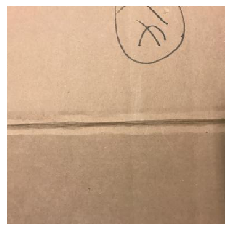

In [6]:
images = []
labels = []
trashnet_data_path = 'data/TrashNet'
trashnet_image_folders = os.listdir(trashnet_data_path)

category_hash = {
    0: 'nontrash',
    1: 'cardboard',
    2: 'glass',
    3: 'metal',
    4: 'paper',
    5: 'plastic',
    6: 'trash'
}

cat_count = 400
flag = True
for folder in trashnet_image_folders:
    if "_" not in folder:
        count = 0
        print(f"Loading TrashNet folder {folder}...")
        for img in os.listdir(f"{trashnet_data_path}/{folder}"):
            if count < cat_count:
                # Load image
                I = preprocess_image(f"{trashnet_data_path}/{folder}/{img}")

                # Show image
                if flag:
                    fig,ax = plt.subplots(1)
                    plt.axis('off')
                    plt.imshow(I)
                    flag = False

                if I.shape == (300, 300, 3):
                    images.append(I)
                    if folder == 'cardboard':
                        labels.append(1)
                    elif folder == 'glass':
                        labels.append(2)
                    elif folder == 'metal':
                        labels.append(3)
                    elif folder == 'paper':
                        labels.append(4)
                    elif folder == 'plastic':
                        labels.append(5)
                    elif folder == 'trash':
                        labels.append(6)
                    count = count + 1
                else:
                    print(f"Not adding {img} due to improper shape...")

trashnet_img_count = len(images)
print(f"TrashNet Image Count: {trashnet_img_count}")

pos_label_count = trashnet_img_count
print(f"Label count: {pos_label_count}")

Random Image Count: 2400
Not adding 000000007888.jpg due to improper shape...
Not adding 000000024021.jpg due to improper shape...


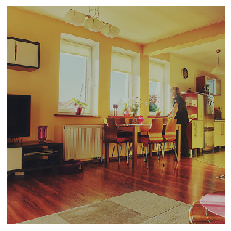

In [7]:
random_data_path = 'data/val2017'
random_image_files = os.listdir(random_data_path)[:trashnet_img_count]
random_img_count = len(random_image_files)
print(f"Random Image Count: {random_img_count}")
            
flag = True    
for i, img in enumerate(random_image_files):
    if count > 0:
        # Load image
        I = preprocess_image(random_data_path + '/' + img)

        # Show image
        if flag:
            flag = False
            fig,ax = plt.subplots(1)
            plt.axis('off')
            plt.imshow(I)

        if I.shape == (300, 300, 3):
            images.append(I)
            labels.append(0)
            count = count - 1
        else:
            print(f"Not adding {img} due to improper shape...")

In [8]:
# Split data
print(f"Image total: {len(images)}")
print(f"Label total: {len(labels)}")

train_x, val_x, train_y, val_y = train_test_split(np.array(images), np.array(labels), test_size=0.20, random_state=7)

Image total: 2800
Label total: 2800


In [9]:
# Create basic mobilenet binary classification model - TF 2.0 model layer
models = [#'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4',
          #'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4',
          #'https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/4',
          'https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4']

epochs = 10
batch_size = 64
best_model = None
best_history = None
best_acc = 0.0
for model_arch in models:
    print(f"Building {model_arch}... epochs={epochs}, batch_size={batch_size}")
    model = tf.keras.Sequential([
        #arguments=dict(batch_norm_momentum=0.997)
        tf_hub.KerasLayer(model_arch, trainable=False),  
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.build([None, 300, 300, 3])  
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])
    print("Fitting...")
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) 
    
    val_acc = history.history['val_accuracy'][1]
    print(f"Val Acc: {val_acc}")

    if val_acc > best_acc:
        best_history = history
        best_model = model
        best_acc = val_acc

Building https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4... epochs=10, batch_size=64
Fitting...
Train on 2240 samples, validate on 560 samples
Epoch 1/10
2240/2240 [==============================] - 317s 142ms/sample - loss: 1.0526 - accuracy: 0.6170 - val_loss: 0.6502 - val_accuracy: 0.7696
Epoch 2/10
2240/2240 [==============================] - 303s 135ms/sample - loss: 0.4352 - accuracy: 0.8705 - val_loss: 0.4490 - val_accuracy: 0.8482
Epoch 3/10
2240/2240 [==============================] - 304s 136ms/sample - loss: 0.2969 - accuracy: 0.9174 - val_loss: 0.3547 - val_accuracy: 0.8875
Epoch 4/10
2240/2240 [==============================] - 300s 134ms/sample - loss: 0.2204 - accuracy: 0.9536 - val_loss: 0.3077 - val_accuracy: 0.9018
Epoch 5/10
2240/2240 [==============================] - 300s 134ms/sample - loss: 0.1748 - accuracy: 0.9634 - val_loss: 0.2624 - val_accuracy: 0.9250
Epoch 6/10
2240/2240 [==============================] - 304s 136ms/sample - loss: 0.1417 - 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23561152  
_________________________________________________________________
dense (Dense)                multiple                  14343     
Total params: 23,575,495
Trainable params: 14,343
Non-trainable params: 23,561,152
_________________________________________________________________


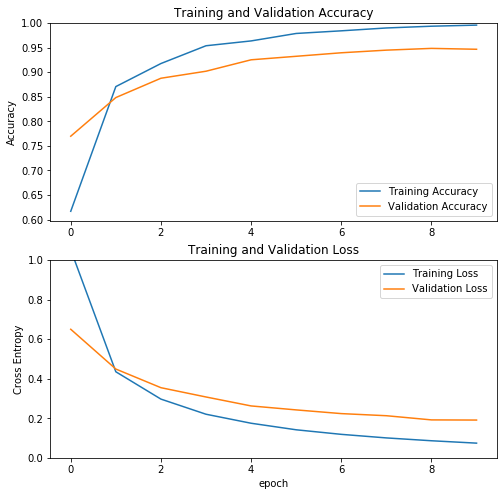

In [10]:
# Plot accuracy vs loss graphs
# Show model architecture
best_model.summary()

acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']

loss = best_history.history['loss']
val_loss = best_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

array([[9.6778560e-01, 1.0505623e-02, 1.6933473e-04, 5.1173787e-03,
        3.6864071e-03, 9.6015064e-03, 3.1341421e-03]], dtype=float32)

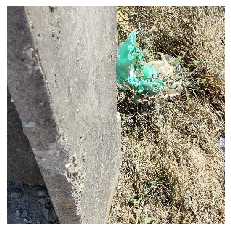

In [11]:
# example prediction
test_img = preprocess_image('../TACO/data/batch_10/000006.jpg')
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(test_img)

best_model.predict(np.array([test_img]),
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False)

In [14]:
# Helper functions for inferring and using OpenCV object detection
import cv2

def infer(infer_img):
    results = best_model.predict(np.array([infer_img]),
            batch_size=None,
            verbose=0,
            steps=None,
            callbacks=None,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False)
    
    pred_index = np.argmax(results)
    pred_confidence = np.amax(results)
    pred_cat = category_hash[pred_index]
    print(f"{image_path}: {pred_cat} - {pred_confidence}\n")
    return pred_confidence, pred_cat

def detect_objects(image, best_model):
    # Load image, grayscale, Otsu's threshold 
    original = image.copy()
    gray = cv2.cvtColor(image, 6)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find contours, obtain bounding box, extract and save ROI
    ROI_number = 0
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        
        # Write rectangle on original image
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
        
        # Create NP array of contour object
        ROI = original[y:y+h, x:x+w]
        
        # Save contour object image
        ROI_img_name = f'ROI_{ROI_number}.png'
        cv2.imwrite(ROI_img_name, ROI)
        
        # Infer against contour object image
        img = Image.open(ROI_img_name)
        w, h = img.size
        img = crop_center(img, min(w,h), min(w,h))
        img = img.resize((300, 300))    
        img = np.asarray(img)/256.0    
        
        pred_conf, pred_cat = infer(img)

        # Display only contour object image IF not trash
        if pred_cat != 'nontrash' and pred_conf > 0.50:
            fig,ax = plt.subplots(1)
            plt.axis('off')
            plt.imshow(img)
            ROI_number += 1

    # Display original with bounding box
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(image)

Detecting objects in OpenStreet
data/OpenStreet/12232_2715.jpg: cardboard - 0.6520171761512756

data/OpenStreet/12232_2715.jpg: cardboard - 0.647739052772522

data/OpenStreet/12232_2715.jpg: cardboard - 0.6322742104530334

data/OpenStreet/12232_2715.jpg: cardboard - 0.6422761082649231

data/OpenStreet/12232_2715.jpg: cardboard - 0.6480947136878967

data/OpenStreet/12232_2715.jpg: cardboard - 0.6511481404304504

data/OpenStreet/12232_2715.jpg: cardboard - 0.6332869529724121

data/OpenStreet/12232_2715.jpg: cardboard - 0.5532448887825012

data/OpenStreet/12232_2715.jpg: cardboard - 0.5440512299537659

data/OpenStreet/12232_2715.jpg: cardboard - 0.6281265616416931

data/OpenStreet/12232_2715.jpg: cardboard - 0.619859516620636

data/OpenStreet/12232_2715.jpg: cardboard - 0.6332869529724121

data/OpenStreet/12232_2715.jpg: cardboard - 0.644561767578125

data/OpenStreet/12232_2715.jpg: cardboard - 0.647739052772522

data/OpenStreet/12232_2715.jpg: cardboard - 0.6360657215118408

data/OpenStr

c:\software\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


data/OpenStreet/12232_2715.jpg: cardboard - 0.6287974715232849

data/OpenStreet/12232_2715.jpg: cardboard - 0.3815981149673462

data/OpenStreet/12232_2715.jpg: cardboard - 0.6371010541915894

data/OpenStreet/12232_2715.jpg: cardboard - 0.6437497138977051

data/OpenStreet/12232_2715.jpg: cardboard - 0.647739052772522

data/OpenStreet/12232_2715.jpg: cardboard - 0.6332869529724121

data/OpenStreet/12232_2715.jpg: cardboard - 0.6530647873878479

data/OpenStreet/12232_2715.jpg: cardboard - 0.6413478851318359

data/OpenStreet/12232_2715.jpg: cardboard - 0.6511481404304504

data/OpenStreet/12232_2715.jpg: cardboard - 0.6308251619338989

data/OpenStreet/12232_2715.jpg: cardboard - 0.6204558610916138

data/OpenStreet/12232_2715.jpg: cardboard - 0.6511481404304504

data/OpenStreet/12232_2715.jpg: cardboard - 0.6999666094779968

data/OpenStreet/12232_2715.jpg: cardboard - 0.6511481404304504

data/OpenStreet/12232_2715.jpg: paper - 0.41981443762779236

data/OpenStreet/12232_2715.jpg: cardboard - 

data/OpenStreet/12232_2715.jpg: cardboard - 0.6687145233154297

data/OpenStreet/12232_2715.jpg: cardboard - 0.6762608289718628

data/OpenStreet/12232_2715.jpg: cardboard - 0.6777501106262207

data/OpenStreet/12232_2715.jpg: cardboard - 0.6777501106262207

data/OpenStreet/12232_2715.jpg: cardboard - 0.8310131430625916

data/OpenStreet/12232_2715.jpg: cardboard - 0.6777501106262207

data/OpenStreet/12232_2715.jpg: paper - 0.4480404257774353

data/OpenStreet/12232_2715.jpg: cardboard - 0.6740961074829102

data/OpenStreet/12232_2715.jpg: cardboard - 0.6386330723762512

data/OpenStreet/12232_2715.jpg: cardboard - 0.6648672819137573

data/OpenStreet/12232_2715.jpg: cardboard - 0.8279876708984375

data/OpenStreet/12232_2715.jpg: cardboard - 0.6777501106262207

data/OpenStreet/12232_2715.jpg: cardboard - 0.6639753580093384

data/OpenStreet/12232_2715.jpg: cardboard - 0.6777501106262207

data/OpenStreet/12232_2715.jpg: cardboard - 0.7873251438140869

data/OpenStreet/12232_2715.jpg: cardboard - 

c:\software\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
c:\software\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


data/OpenStreet/12232_2715.jpg: nontrash - 0.9986625909805298

data/OpenStreet/12527_2037.jpg: cardboard - 0.6494687795639038

data/OpenStreet/12527_2037.jpg: cardboard - 0.6745245456695557

data/OpenStreet/12527_2037.jpg: cardboard - 0.2981060743331909

data/OpenStreet/12527_2037.jpg: cardboard - 0.6447692513465881

data/OpenStreet/12527_2037.jpg: cardboard - 0.5259461998939514

data/OpenStreet/12527_2037.jpg: cardboard - 0.7185018062591553

data/OpenStreet/12527_2037.jpg: cardboard - 0.6894217133522034

data/OpenStreet/12527_2037.jpg: glass - 0.29856666922569275

data/OpenStreet/12527_2037.jpg: cardboard - 0.5335191488265991

data/OpenStreet/12527_2037.jpg: cardboard - 0.7183285355567932

data/OpenStreet/12527_2037.jpg: cardboard - 0.6496357917785645

data/OpenStreet/12527_2037.jpg: cardboard - 0.6902870535850525

data/OpenStreet/12527_2037.jpg: cardboard - 0.4506828784942627

data/OpenStreet/12527_2037.jpg: cardboard - 0.6668211221694946

data/OpenStreet/12527_2037.jpg: cardboard - 

data/OpenStreet/13916_168.jpg: cardboard - 0.6515352129936218

data/OpenStreet/13916_168.jpg: cardboard - 0.5993450284004211

data/OpenStreet/13916_168.jpg: cardboard - 0.7513365745544434

data/OpenStreet/13916_168.jpg: cardboard - 0.6553478240966797

data/OpenStreet/13916_168.jpg: metal - 0.5084424614906311

data/OpenStreet/13916_168.jpg: cardboard - 0.6762848496437073

data/OpenStreet/13916_168.jpg: glass - 0.4084167182445526

data/OpenStreet/13916_168.jpg: cardboard - 0.33395570516586304

data/OpenStreet/13916_168.jpg: cardboard - 0.6342697143554688

data/OpenStreet/13916_168.jpg: cardboard - 0.6537657976150513

data/OpenStreet/13916_168.jpg: cardboard - 0.6396886110305786

data/OpenStreet/13916_168.jpg: plastic - 0.48793694376945496

data/OpenStreet/13916_168.jpg: glass - 0.35904088616371155

data/OpenStreet/13916_168.jpg: cardboard - 0.5331572890281677

data/OpenStreet/13916_168.jpg: cardboard - 0.7018840312957764

data/OpenStreet/13916_168.jpg: cardboard - 0.6562390327453613

dat

data/OpenStreet/13916_168.jpg: cardboard - 0.6650091409683228

data/OpenStreet/13916_168.jpg: cardboard - 0.6821799278259277

data/OpenStreet/13916_168.jpg: glass - 0.32800766825675964

data/OpenStreet/13916_168.jpg: cardboard - 0.6195279359817505

data/OpenStreet/13916_168.jpg: plastic - 0.37041670083999634

data/OpenStreet/13916_168.jpg: cardboard - 0.6646575331687927

data/OpenStreet/13916_168.jpg: cardboard - 0.6673268675804138

data/OpenStreet/13916_168.jpg: cardboard - 0.6684223413467407

data/OpenStreet/13916_168.jpg: cardboard - 0.6550886034965515

data/OpenStreet/13916_168.jpg: cardboard - 0.6441534161567688

data/OpenStreet/13916_168.jpg: cardboard - 0.6723066568374634

data/OpenStreet/13916_168.jpg: cardboard - 0.6701613664627075

data/OpenStreet/13916_168.jpg: cardboard - 0.6741799712181091

data/OpenStreet/13916_168.jpg: cardboard - 0.6871440410614014

data/OpenStreet/13916_168.jpg: cardboard - 0.6864057183265686

data/OpenStreet/13916_168.jpg: cardboard - 0.66979348659515

data/OpenStreet/13916_168.jpg: glass - 0.9640092253684998

data/OpenStreet/13916_168.jpg: cardboard - 0.6705949306488037

data/OpenStreet/13916_168.jpg: glass - 0.9622502326965332

data/OpenStreet/13916_168.jpg: cardboard - 0.3213913142681122

data/OpenStreet/13916_168.jpg: cardboard - 0.6691923141479492

data/OpenStreet/13916_168.jpg: paper - 0.7120131850242615

data/OpenStreet/13916_168.jpg: cardboard - 0.6523304581642151

data/OpenStreet/13916_168.jpg: metal - 0.8037329316139221

data/OpenStreet/13916_168.jpg: glass - 0.4225771725177765

data/OpenStreet/13916_168.jpg: cardboard - 0.6697934865951538

data/OpenStreet/13916_168.jpg: cardboard - 0.6860252022743225

data/OpenStreet/13916_168.jpg: cardboard - 0.665564239025116

data/OpenStreet/13916_168.jpg: glass - 0.3401135206222534

data/OpenStreet/13916_168.jpg: cardboard - 0.6002404689788818

data/OpenStreet/13916_168.jpg: cardboard - 0.6812521815299988

data/OpenStreet/13916_168.jpg: cardboard - 0.7398214936256409

data/OpenStreet/1

data/OpenStreet/13916_168.jpg: cardboard - 0.665564239025116

data/OpenStreet/13916_168.jpg: metal - 0.8984541893005371

data/OpenStreet/13916_168.jpg: cardboard - 0.670663058757782

data/OpenStreet/13916_168.jpg: glass - 0.3755496144294739

data/OpenStreet/13916_168.jpg: cardboard - 0.5779345631599426

data/OpenStreet/13916_168.jpg: cardboard - 0.6389826536178589

data/OpenStreet/13916_168.jpg: cardboard - 0.5821571946144104

data/OpenStreet/13916_168.jpg: cardboard - 0.6336727142333984

data/OpenStreet/13916_168.jpg: cardboard - 0.8005479574203491

data/OpenStreet/13916_168.jpg: cardboard - 0.652168333530426

data/OpenStreet/13916_168.jpg: metal - 0.580351710319519

data/OpenStreet/13916_168.jpg: glass - 0.57819002866745

data/OpenStreet/13916_168.jpg: cardboard - 0.6881745457649231

data/OpenStreet/13916_168.jpg: cardboard - 0.6968643665313721

data/OpenStreet/13916_168.jpg: cardboard - 0.6964674592018127

data/OpenStreet/13916_168.jpg: cardboard - 0.6900545954704285

data/OpenStree

data/OpenStreet/13916_168.jpg: cardboard - 0.6596371531486511

data/OpenStreet/13916_168.jpg: cardboard - 0.6810463070869446

data/OpenStreet/13916_168.jpg: cardboard - 0.6924630403518677

data/OpenStreet/13916_168.jpg: cardboard - 0.7990981340408325

data/OpenStreet/13916_168.jpg: cardboard - 0.6620282530784607

data/OpenStreet/13916_168.jpg: cardboard - 0.6971189975738525

data/OpenStreet/13916_168.jpg: cardboard - 0.6312004327774048

data/OpenStreet/13916_168.jpg: cardboard - 0.7211556434631348

data/OpenStreet/13916_168.jpg: cardboard - 0.6806026697158813

data/OpenStreet/13916_168.jpg: plastic - 0.5823015570640564

data/OpenStreet/13916_168.jpg: cardboard - 0.6884894967079163

data/OpenStreet/13916_168.jpg: cardboard - 0.6327869296073914

data/OpenStreet/13916_168.jpg: cardboard - 0.6312004327774048

data/OpenStreet/13916_168.jpg: paper - 0.9159486889839172

data/OpenStreet/13916_168.jpg: cardboard - 0.6469075083732605

data/OpenStreet/13916_168.jpg: cardboard - 0.5344476103782654


data/OpenStreet/13916_168.jpg: plastic - 0.5492377281188965

data/OpenStreet/13916_168.jpg: cardboard - 0.6871440410614014

data/OpenStreet/13916_168.jpg: cardboard - 0.3244239389896393

data/OpenStreet/13916_168.jpg: paper - 0.6945579051971436

data/OpenStreet/13916_168.jpg: cardboard - 0.6386614441871643

data/OpenStreet/13916_168.jpg: cardboard - 0.3620915114879608

data/OpenStreet/13916_168.jpg: cardboard - 0.6588142514228821

data/OpenStreet/13916_168.jpg: paper - 0.7240146398544312

data/OpenStreet/13916_168.jpg: cardboard - 0.6244815587997437

data/OpenStreet/13916_168.jpg: cardboard - 0.6523304581642151

data/OpenStreet/13916_168.jpg: cardboard - 0.473194420337677

data/OpenStreet/13916_168.jpg: glass - 0.4095117449760437

data/OpenStreet/13916_168.jpg: cardboard - 0.6656261682510376

data/OpenStreet/13916_168.jpg: cardboard - 0.553970992565155

data/OpenStreet/13916_168.jpg: cardboard - 0.6689032912254333

data/OpenStreet/13916_168.jpg: cardboard - 0.652168333530426

data/Ope

data/OpenStreet/13916_168.jpg: cardboard - 0.7129284143447876

data/OpenStreet/13916_168.jpg: cardboard - 0.6963158249855042

data/OpenStreet/13916_168.jpg: cardboard - 0.6210427284240723

data/OpenStreet/13916_168.jpg: cardboard - 0.6510072350502014

data/OpenStreet/13916_168.jpg: cardboard - 0.650109589099884

data/OpenStreet/13916_168.jpg: cardboard - 0.6410749554634094

data/OpenStreet/13916_168.jpg: cardboard - 0.573919415473938

data/OpenStreet/13916_168.jpg: cardboard - 0.6711627840995789

data/OpenStreet/13916_168.jpg: cardboard - 0.6543354392051697

data/OpenStreet/13916_168.jpg: cardboard - 0.5527764558792114

data/OpenStreet/13916_168.jpg: cardboard - 0.6464940905570984

data/OpenStreet/13916_168.jpg: cardboard - 0.665569543838501

data/OpenStreet/13916_168.jpg: cardboard - 0.6971189975738525

data/OpenStreet/13916_168.jpg: cardboard - 0.7372350692749023

data/OpenStreet/13916_168.jpg: cardboard - 0.6417661309242249

data/OpenStreet/13916_168.jpg: cardboard - 0.4639810621738


data/OpenStreet/13916_168.jpg: cardboard - 0.650109589099884

data/OpenStreet/13916_168.jpg: paper - 0.6767693758010864

data/OpenStreet/13916_168.jpg: cardboard - 0.7198317050933838

data/OpenStreet/13916_168.jpg: cardboard - 0.5767714977264404

data/OpenStreet/13916_168.jpg: cardboard - 0.6811105012893677

data/OpenStreet/13916_168.jpg: cardboard - 0.6410749554634094

data/OpenStreet/13916_168.jpg: cardboard - 0.6410749554634094

data/OpenStreet/13916_168.jpg: cardboard - 0.6317335367202759

data/OpenStreet/13916_168.jpg: cardboard - 0.6446839570999146

data/OpenStreet/13916_168.jpg: cardboard - 0.6630383729934692

data/OpenStreet/13916_168.jpg: cardboard - 0.6651538610458374

data/OpenStreet/13916_168.jpg: cardboard - 0.714885950088501

data/OpenStreet/13916_168.jpg: cardboard - 0.6553478240966797

data/OpenStreet/13916_168.jpg: cardboard - 0.6723066568374634

data/OpenStreet/13916_168.jpg: cardboard - 0.6553478240966797

data/OpenStreet/13916_168.jpg: cardboard - 0.660804629325866

data/OpenStreet/13916_168.jpg: cardboard - 0.6691923141479492

data/OpenStreet/13916_168.jpg: cardboard - 0.6608046293258667

data/OpenStreet/13916_168.jpg: cardboard - 0.6595539450645447

data/OpenStreet/13916_168.jpg: glass - 0.5418443083763123

data/OpenStreet/13916_168.jpg: cardboard - 0.6864057183265686

data/OpenStreet/13916_168.jpg: cardboard - 0.68601393699646

data/OpenStreet/13916_168.jpg: cardboard - 0.6712520122528076

data/OpenStreet/13916_168.jpg: cardboard - 0.696710467338562

data/OpenStreet/13916_168.jpg: glass - 0.37699127197265625

data/OpenStreet/13916_168.jpg: cardboard - 0.6426035761833191

data/OpenStreet/13916_168.jpg: cardboard - 0.6353079676628113

data/OpenStreet/13916_168.jpg: cardboard - 0.6332213282585144

data/OpenStreet/13916_168.jpg: cardboard - 0.6768755912780762

data/OpenStreet/13916_168.jpg: cardboard - 0.6878715753555298

data/OpenStreet/13916_168.jpg: cardboard - 0.6763525605201721

data/OpenStreet/13916_168.jpg: paper - 0.42244020104408264

data/

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.5966609120368958

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: glass - 0.4359772205352783

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.4956005811691284

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.6152280569076538

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.5764378905296326

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.5874733924865723

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.7306973934173584

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.6501619815826416

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: trash - 0.46210139989852905

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.650214672088623

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.635373055934906

data/Malaga/img_CAMERA1_1261232499.053447_right.jpg: cardboard - 0.6058049

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: cardboard - 0.49485087394714355

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: paper - 0.3269459903240204

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: glass - 0.5816616415977478

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: paper - 0.44531551003456116

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: cardboard - 0.6566749811172485

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: cardboard - 0.5400294065475464

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: plastic - 0.3681604564189911

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: cardboard - 0.41013553738594055

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: paper - 0.4564385414123535

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: glass - 0.41607484221458435

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: cardboard - 0.6655880808830261

data/Malaga/img_CAMERA1_1261233022.058281_right.jpg: cardboard - 0.611994743347168



data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.7634220123291016

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.6711627840995789

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.7019071578979492

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.40908536314964294

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.36936426162719727

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: plastic - 0.2943978011608124

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.6302761435508728

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.6693063378334045

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.6302036046981812

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.5921482443809509

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard - 0.5995025634765625

data/Malaga/img_CAMERA1_1261233369.061483_right.jpg: cardboard -

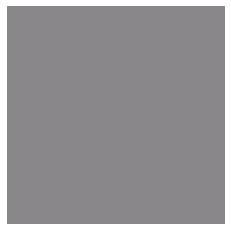

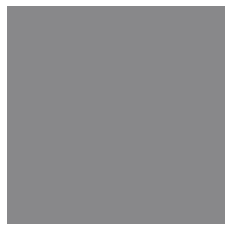

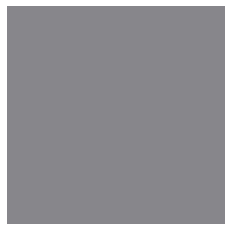

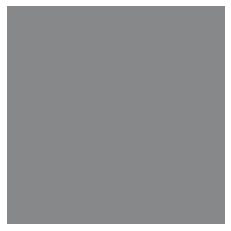

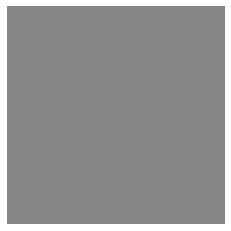

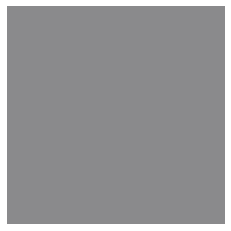

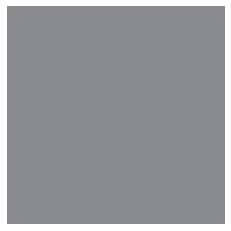

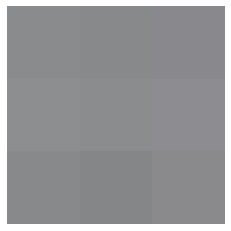

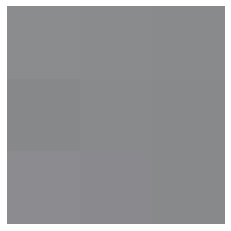

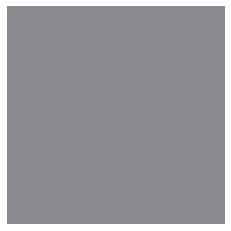

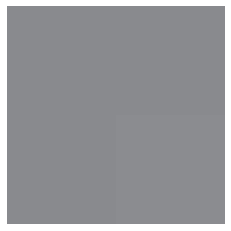

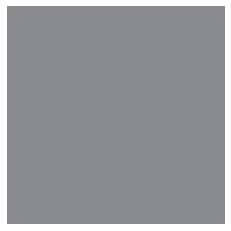

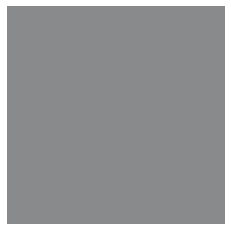

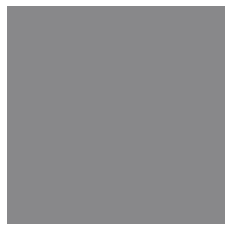

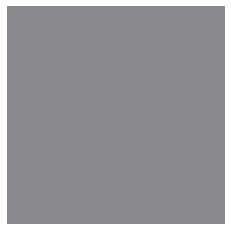

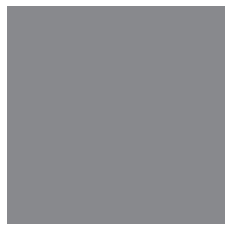

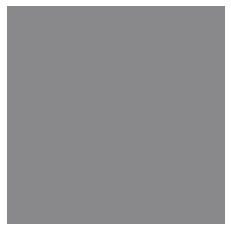

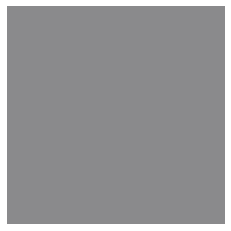

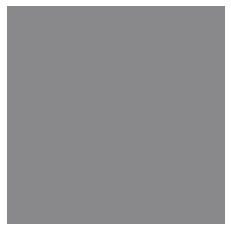

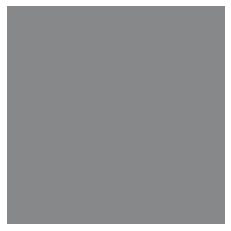

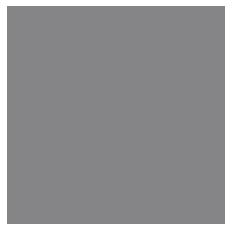

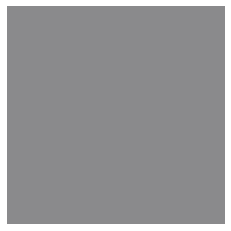

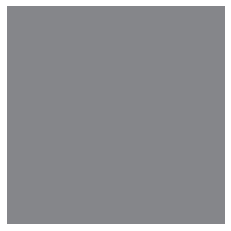

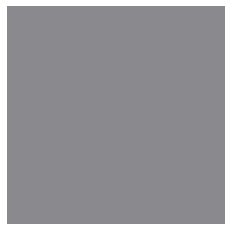

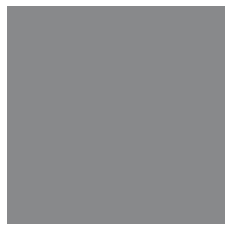

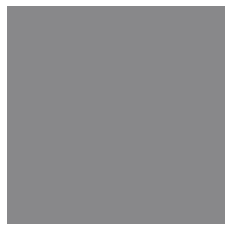

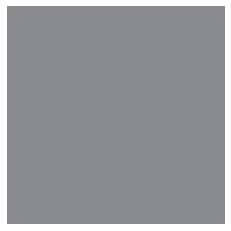

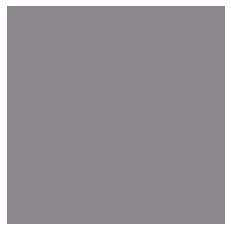

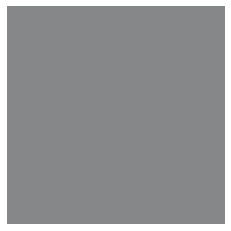

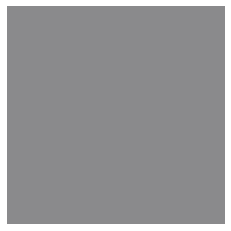

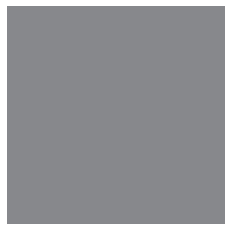

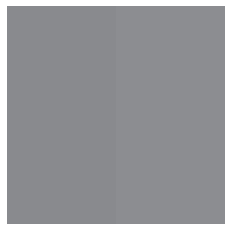

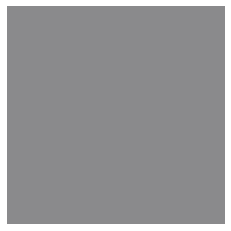

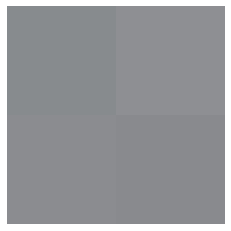

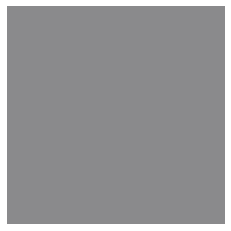

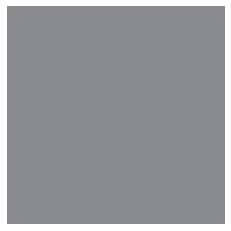

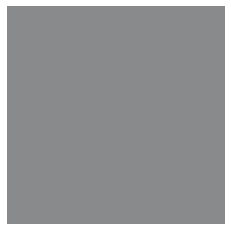

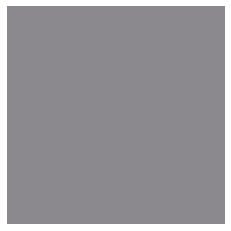

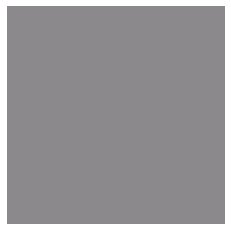

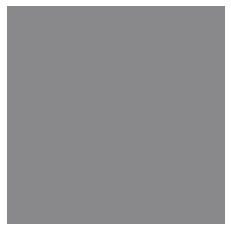

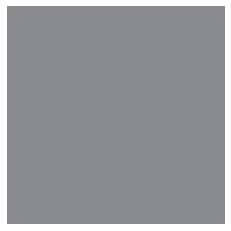

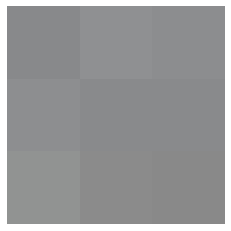

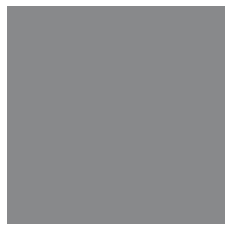

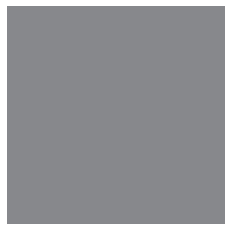

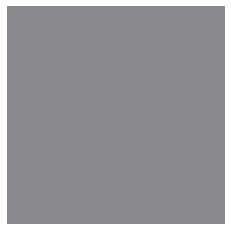

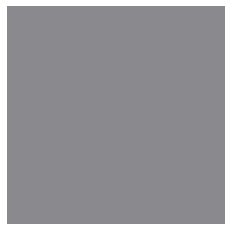

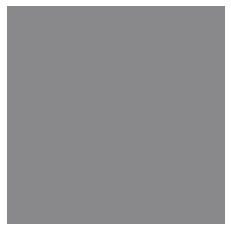

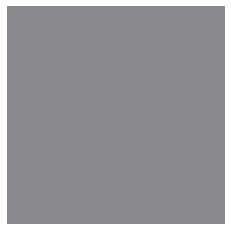

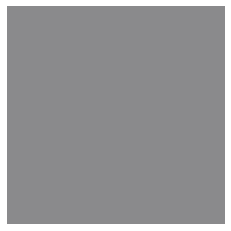

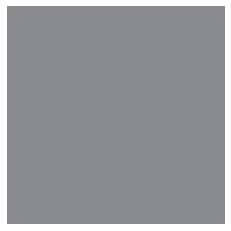

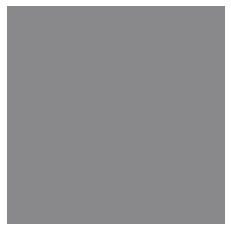

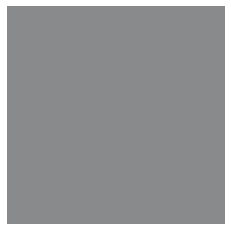

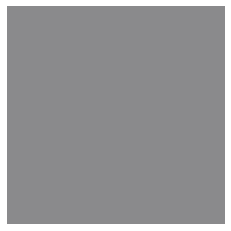

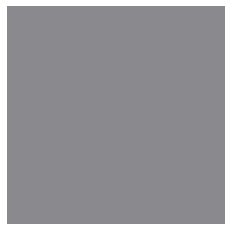

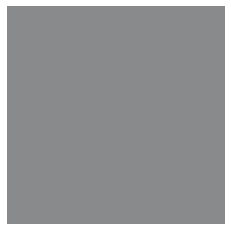

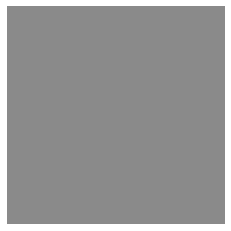

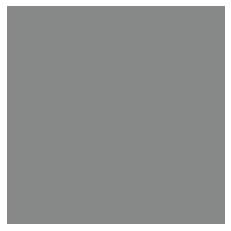

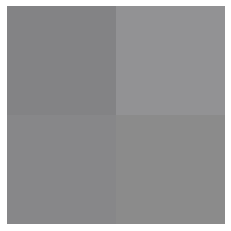

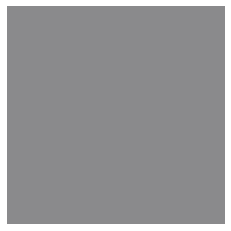

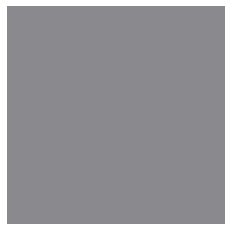

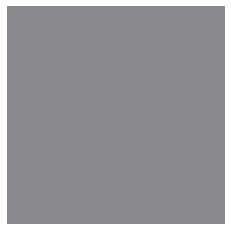

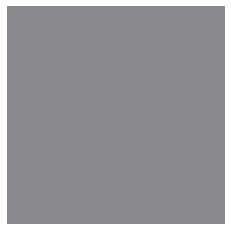

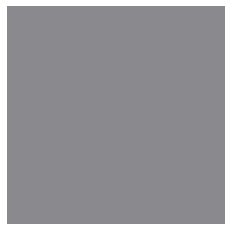

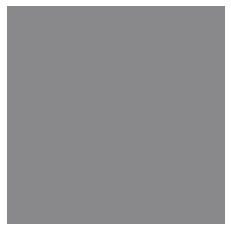

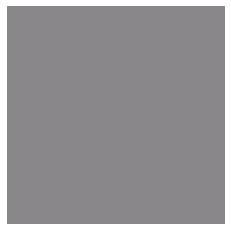

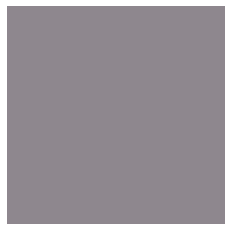

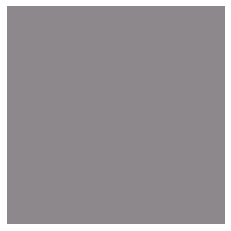

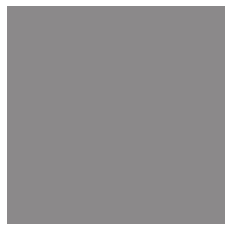

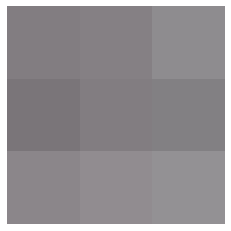

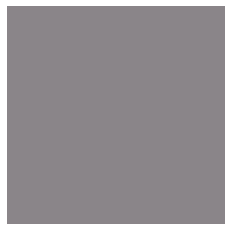

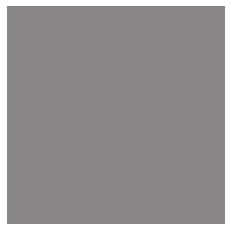

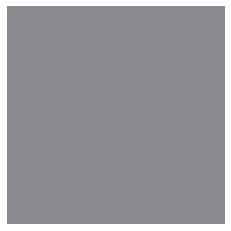

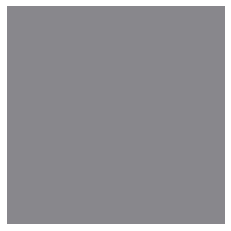

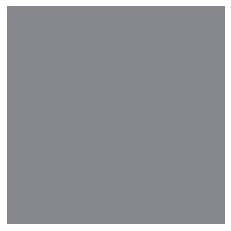

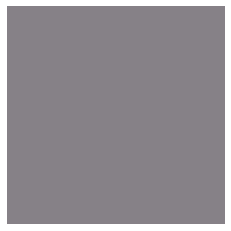

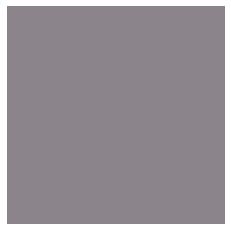

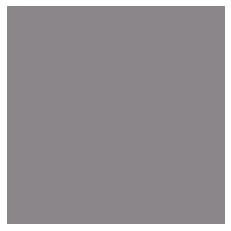

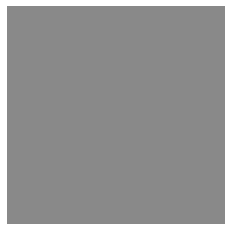

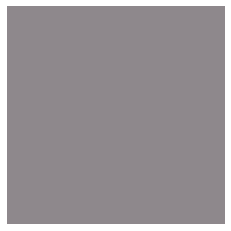

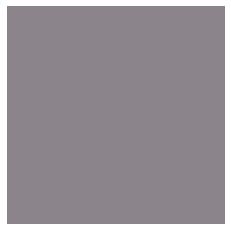

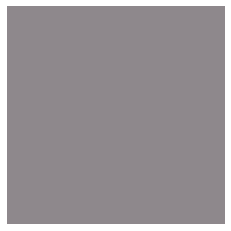

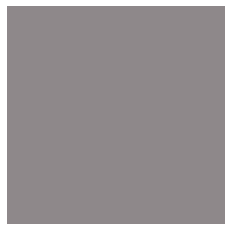

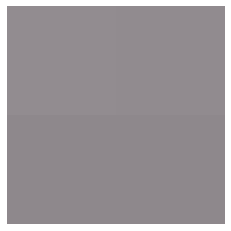

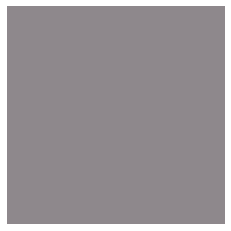

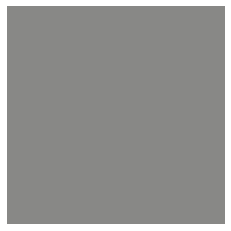

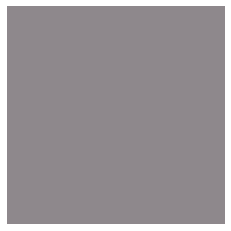

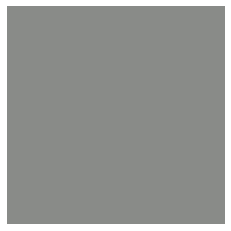

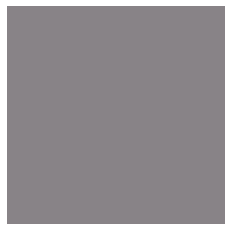

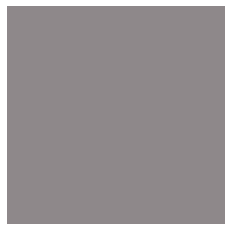

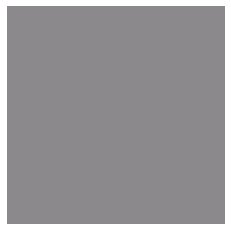

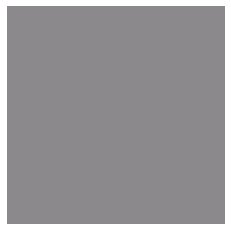

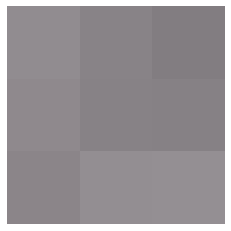

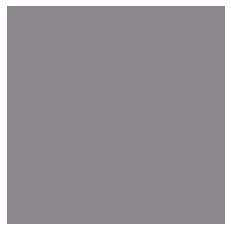

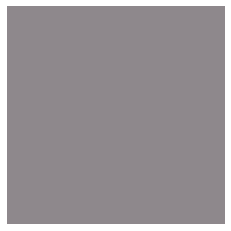

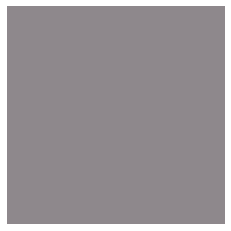

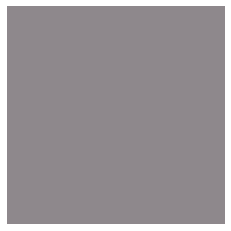

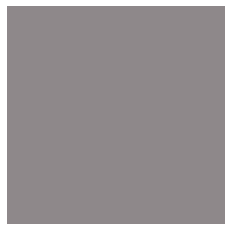

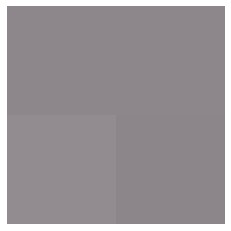

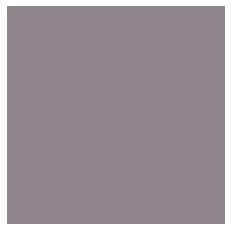

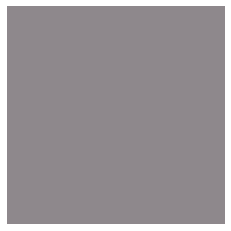

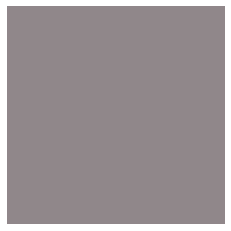

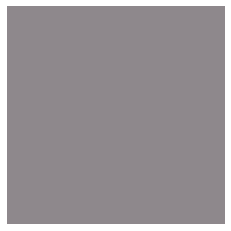

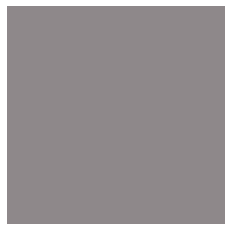

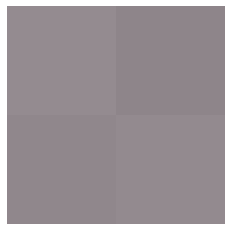

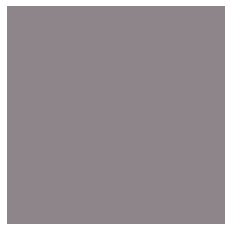

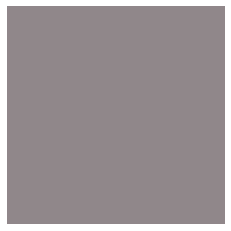

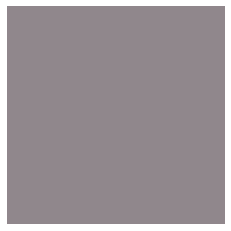

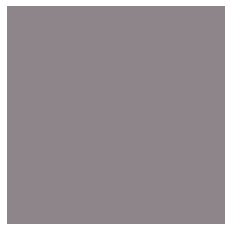

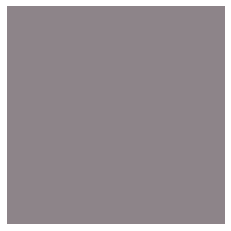

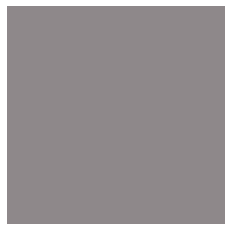

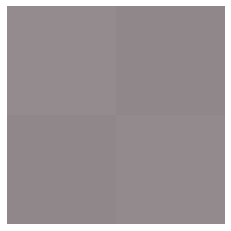

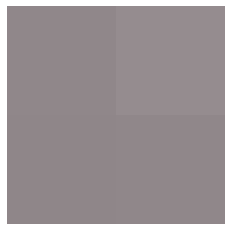

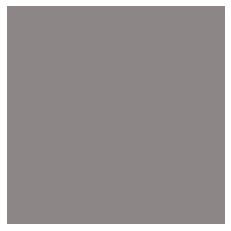

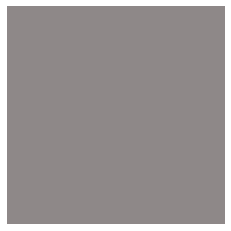

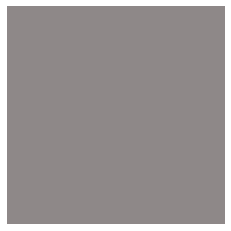

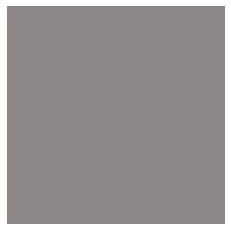

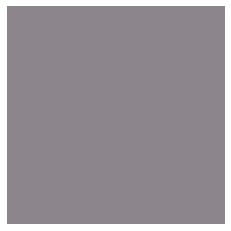

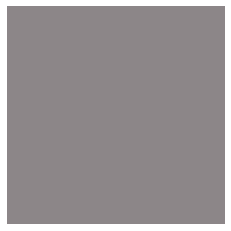

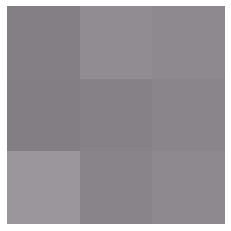

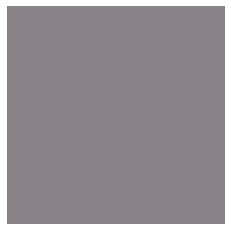

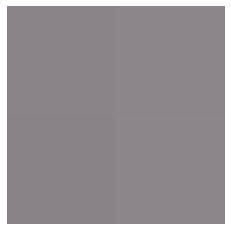

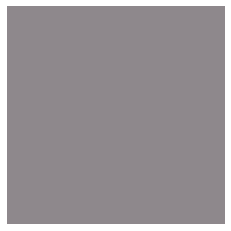

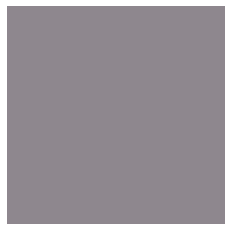

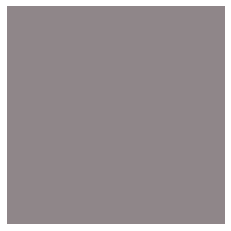

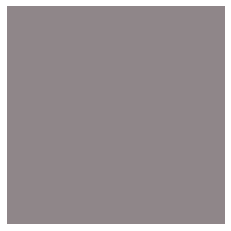

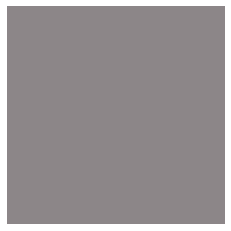

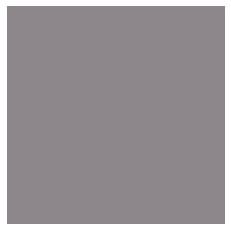

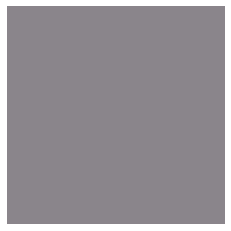

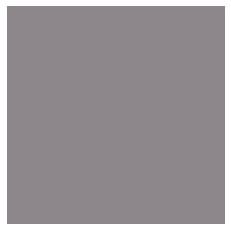

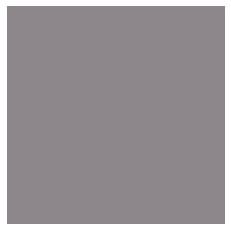

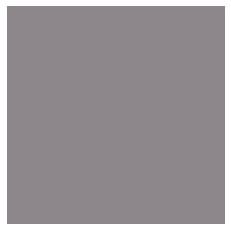

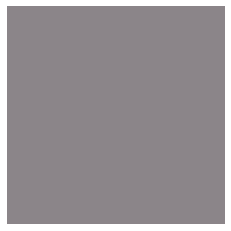

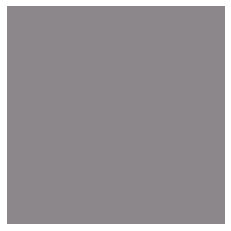

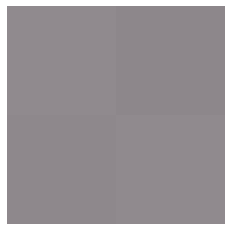

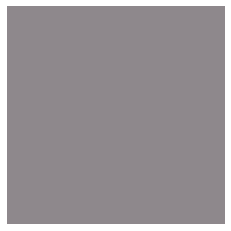

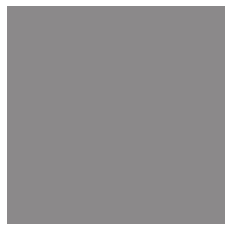

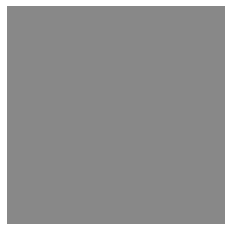

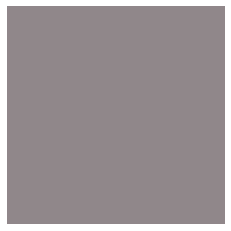

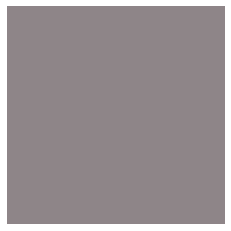

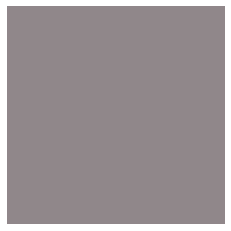

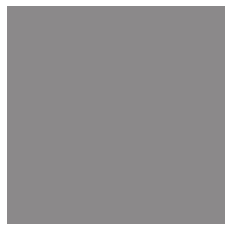

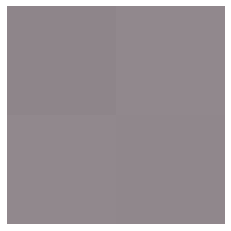

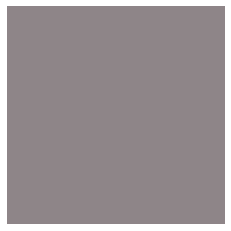

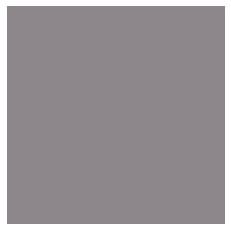

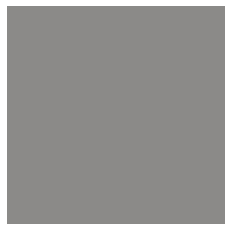

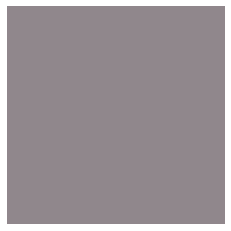

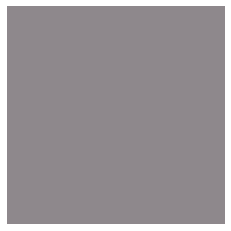

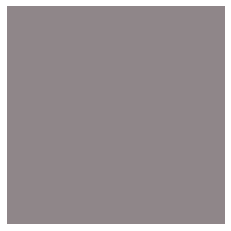

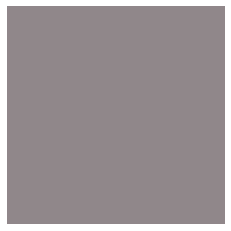

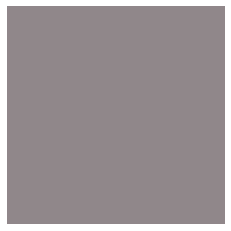

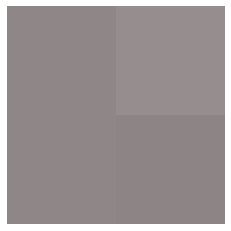

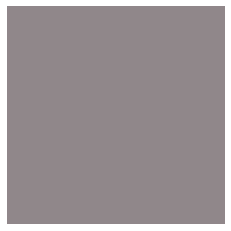

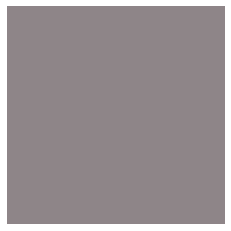

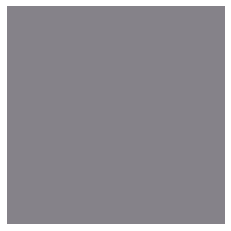

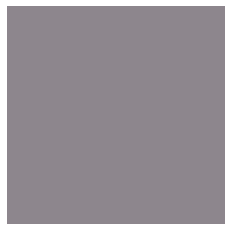

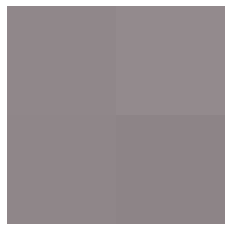

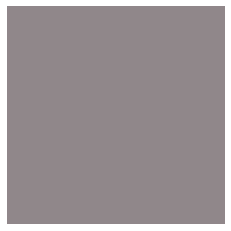

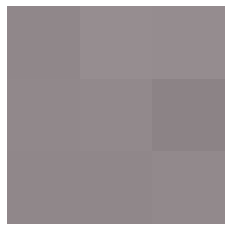

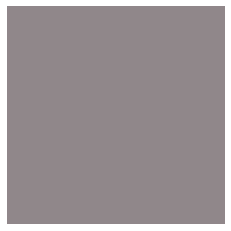

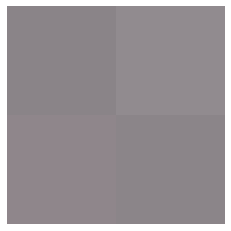

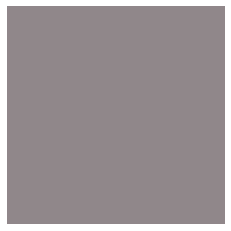

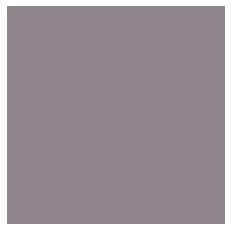

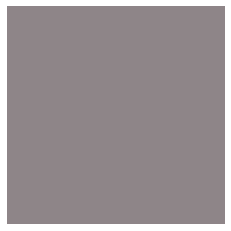

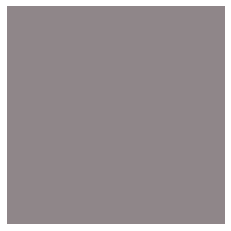

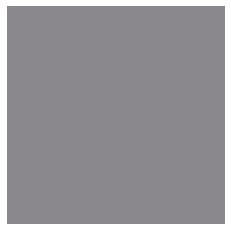

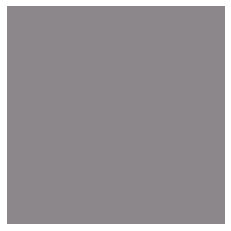

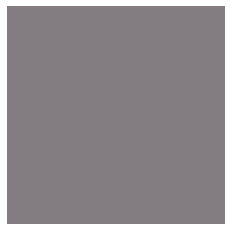

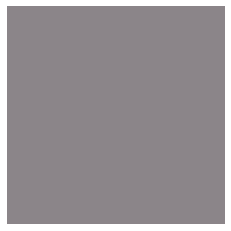

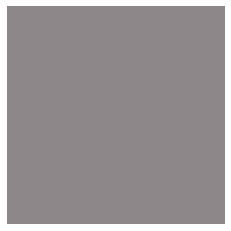

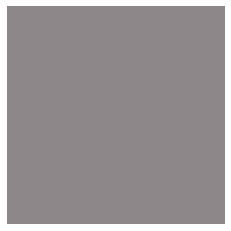

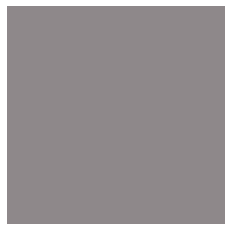

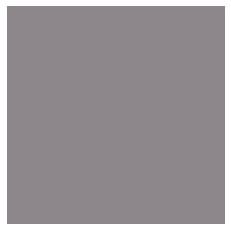

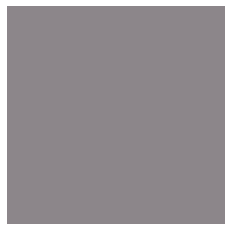

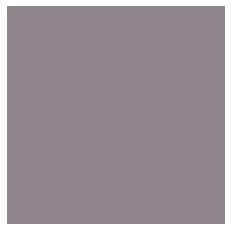

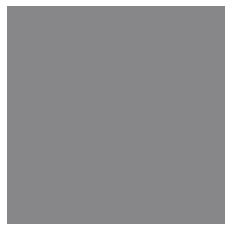

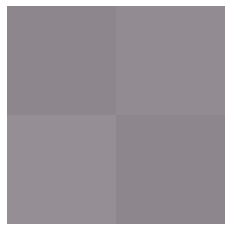

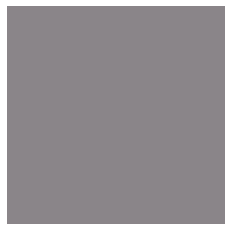

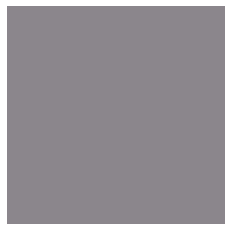

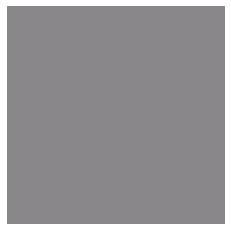

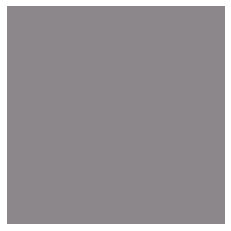

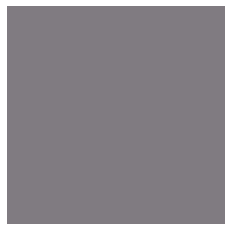

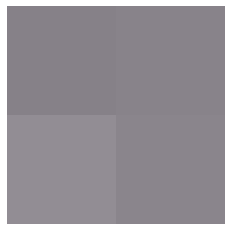

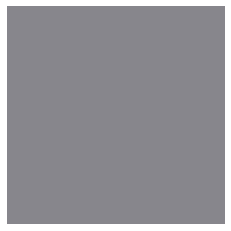

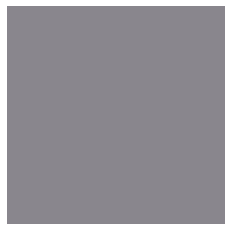

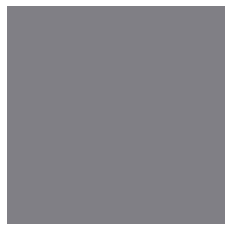

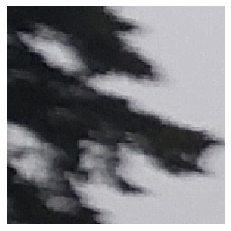

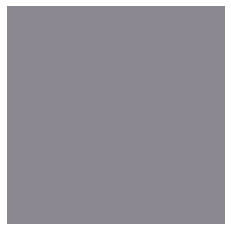

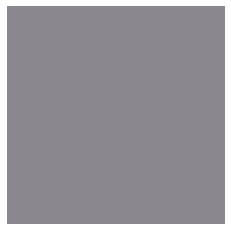

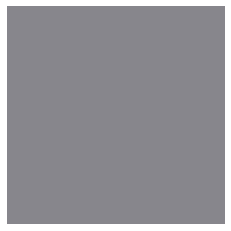

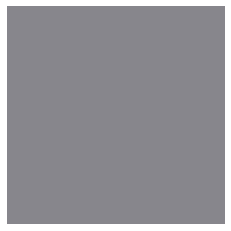

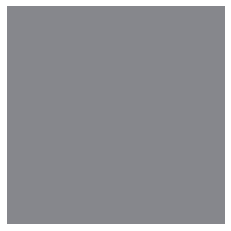

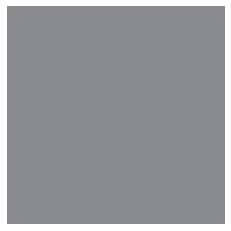

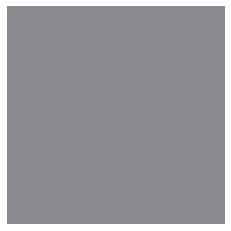

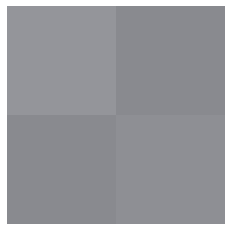

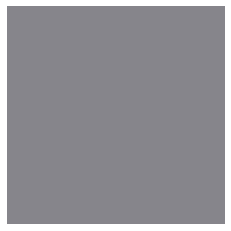

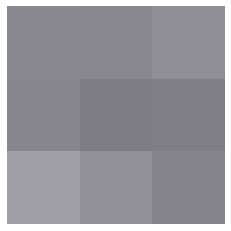

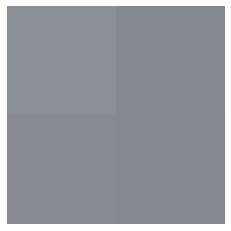

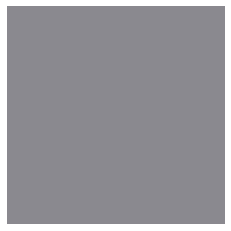

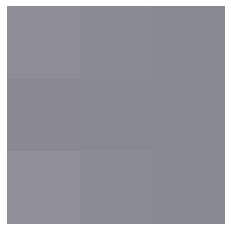

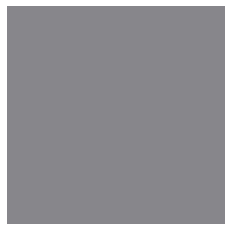

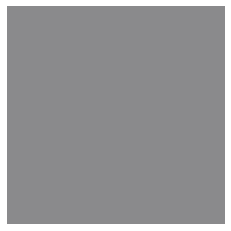

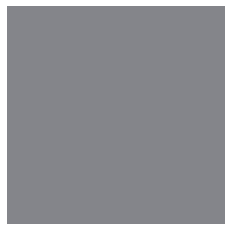

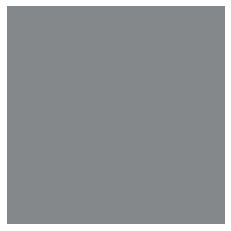

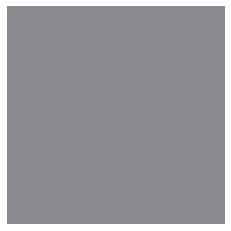

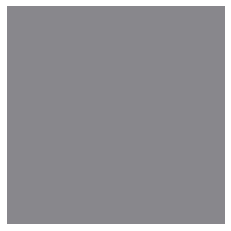

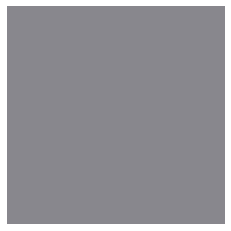

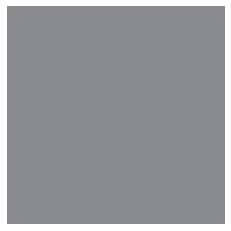

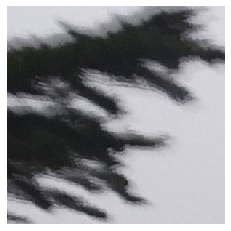

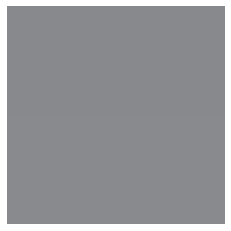

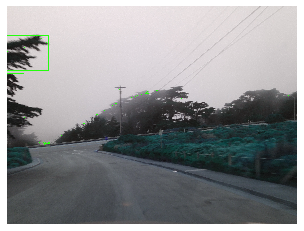

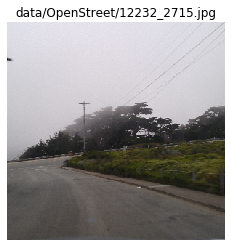

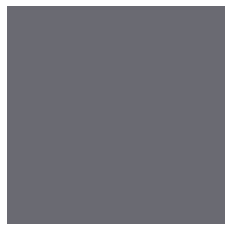

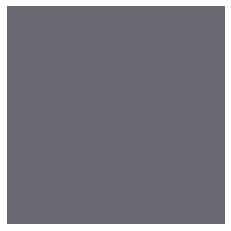

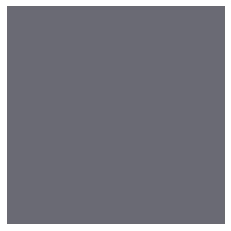

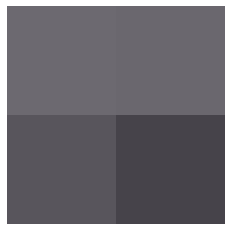

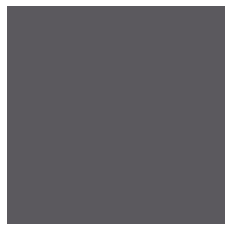

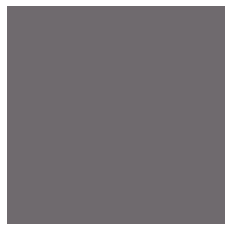

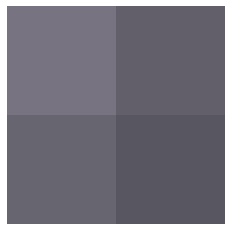

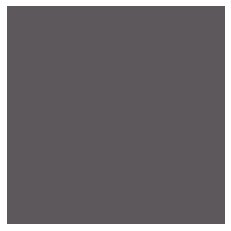

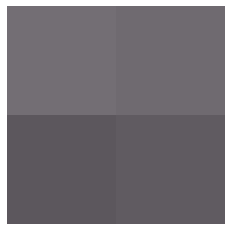

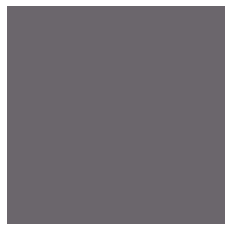

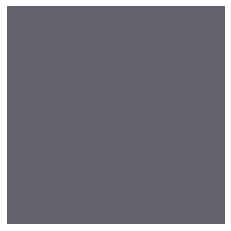

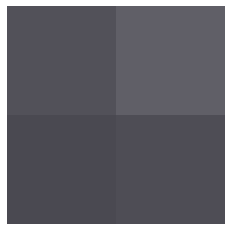

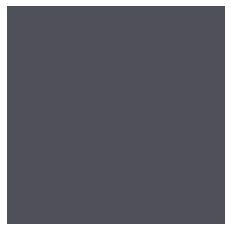

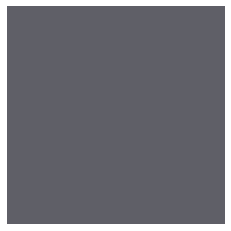

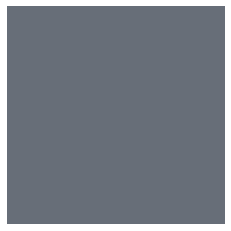

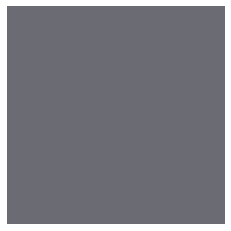

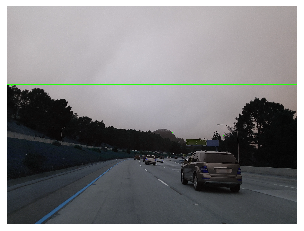

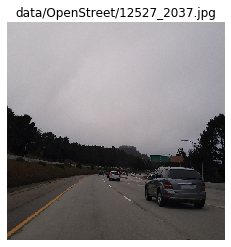

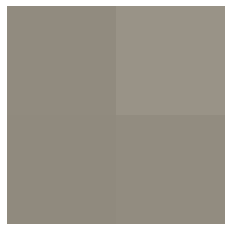

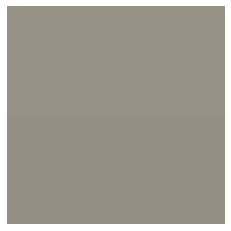

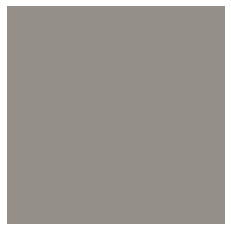

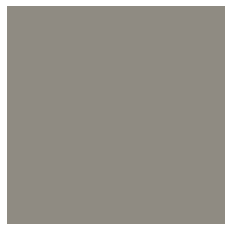

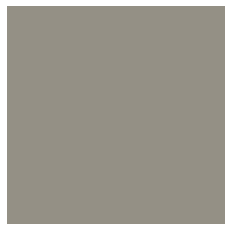

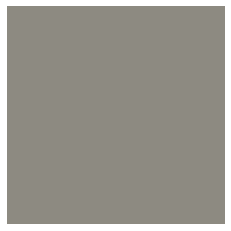

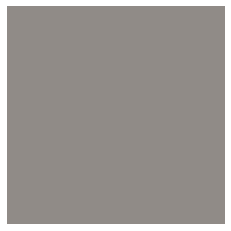

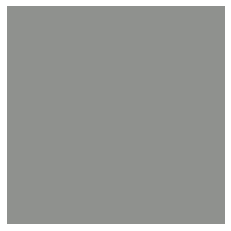

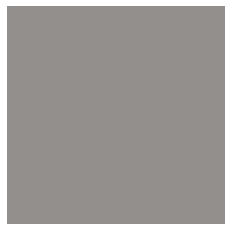

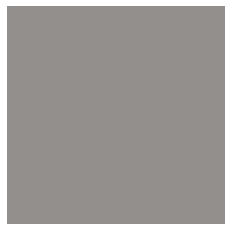

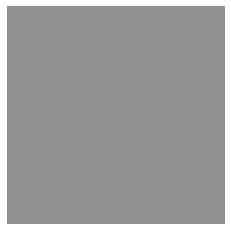

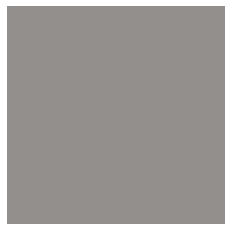

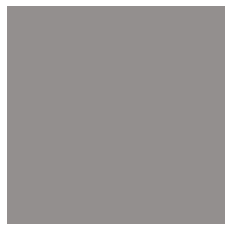

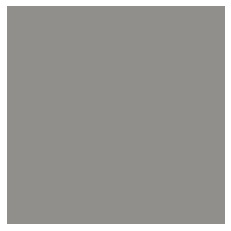

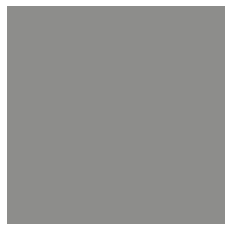

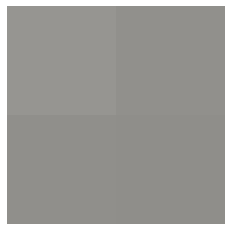

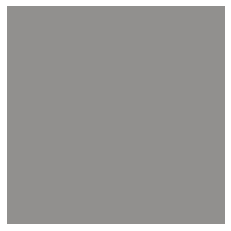

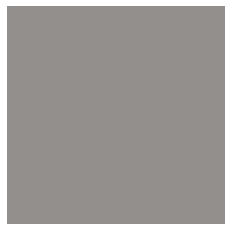

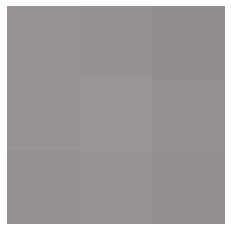

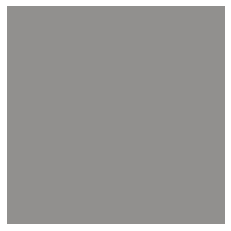

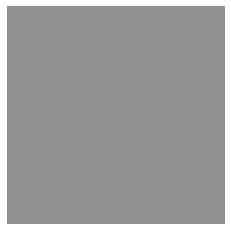

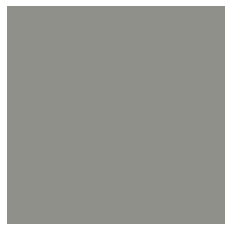

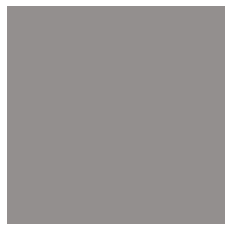

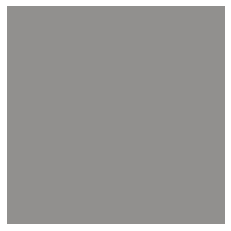

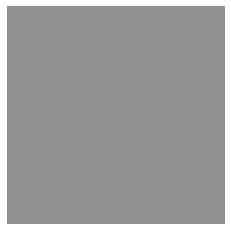

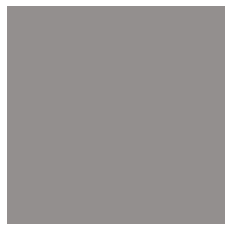

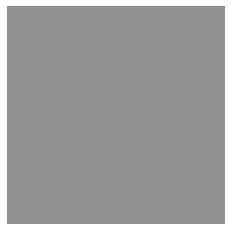

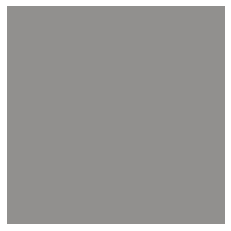

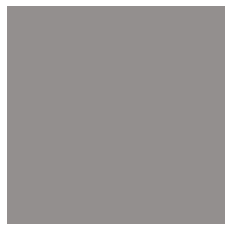

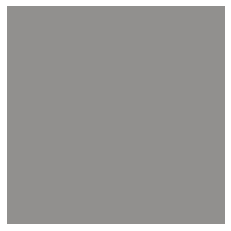

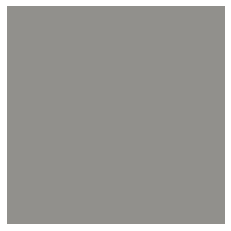

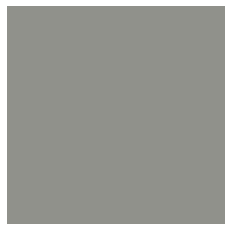

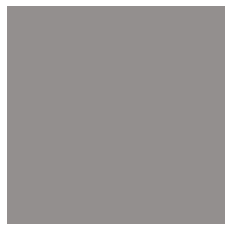

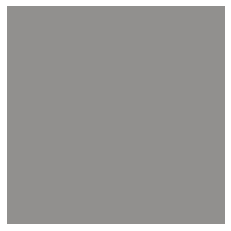

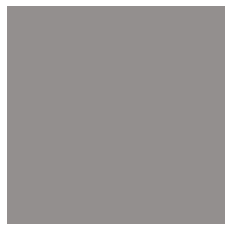

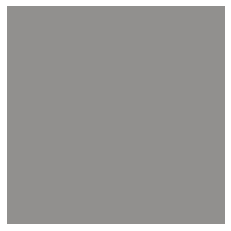

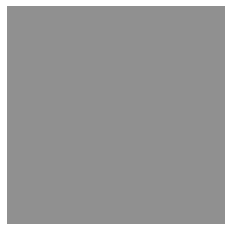

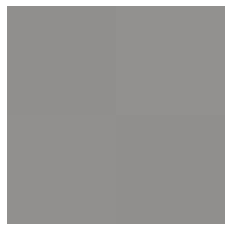

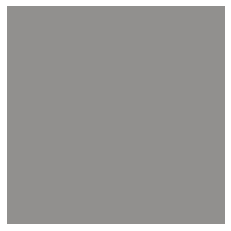

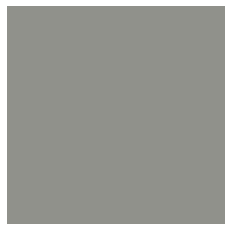

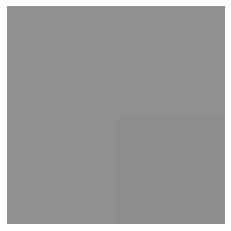

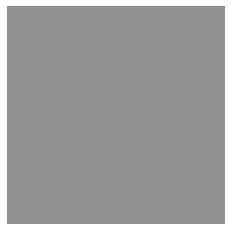

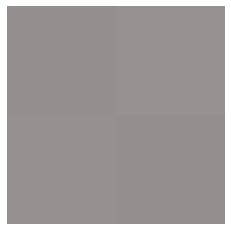

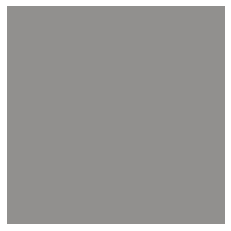

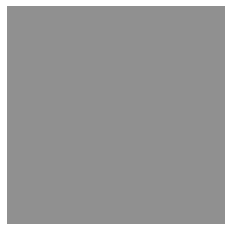

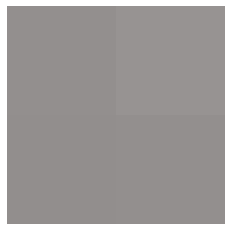

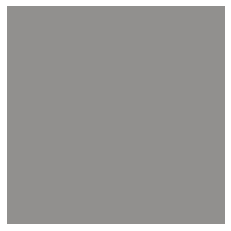

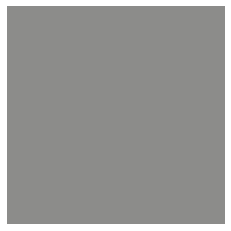

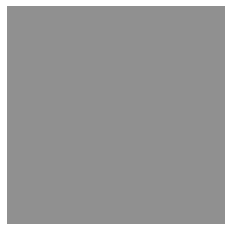

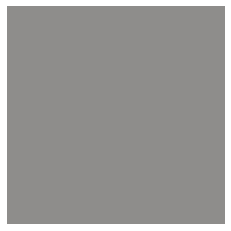

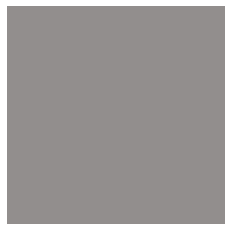

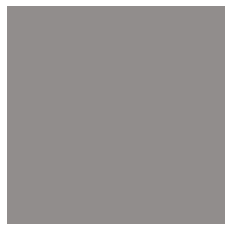

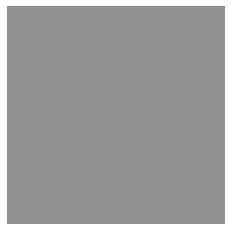

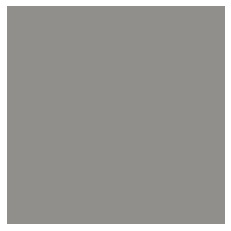

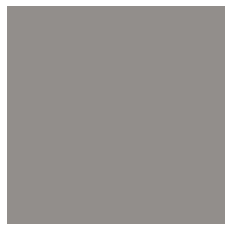

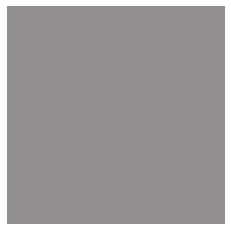

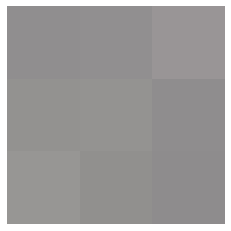

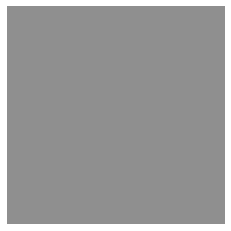

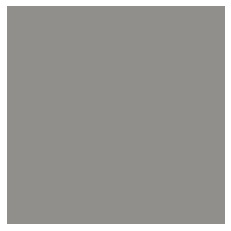

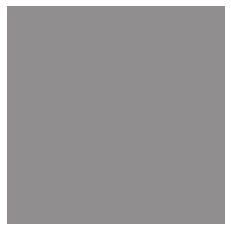

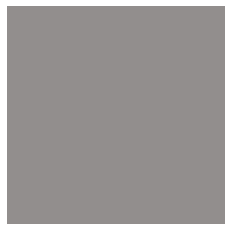

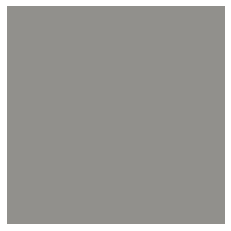

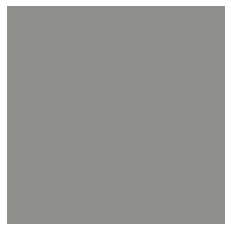

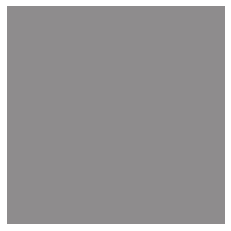

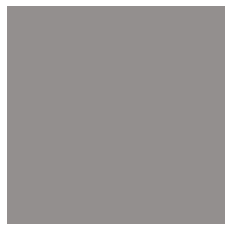

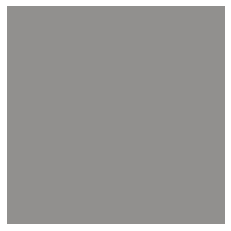

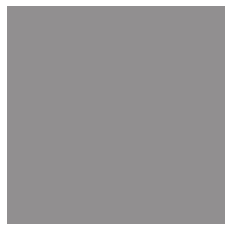

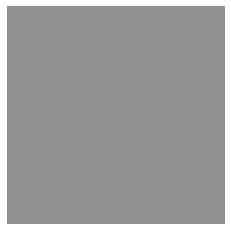

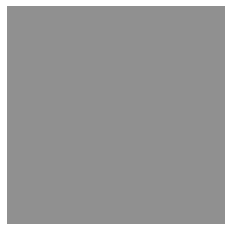

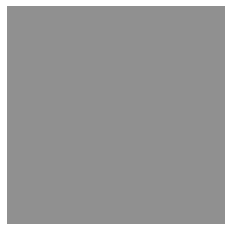

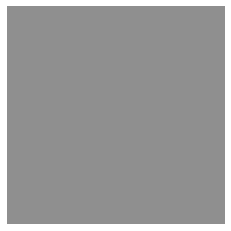

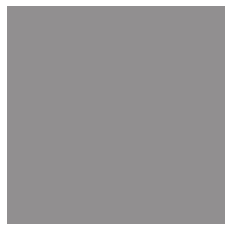

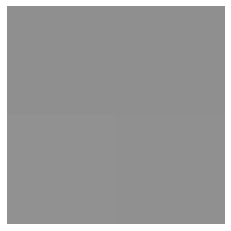

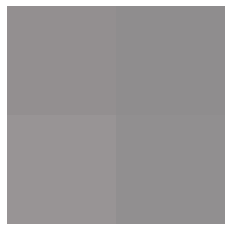

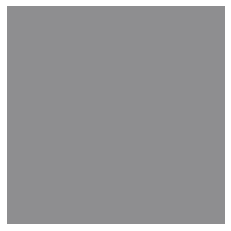

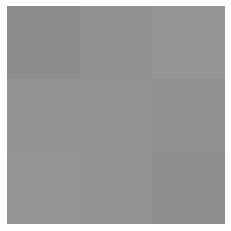

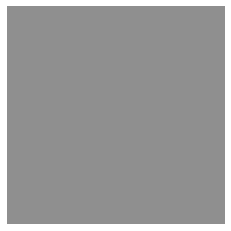

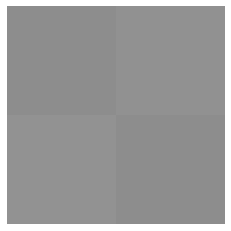

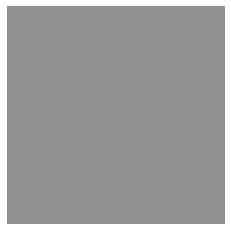

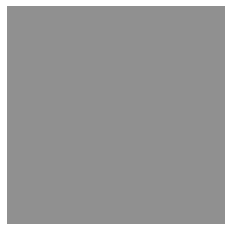

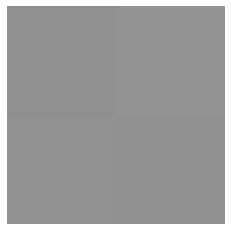

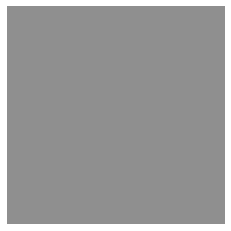

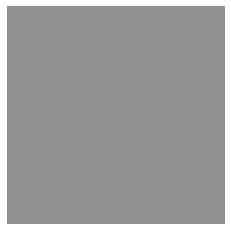

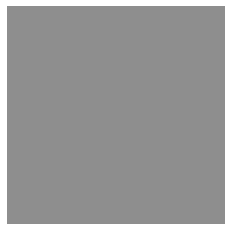

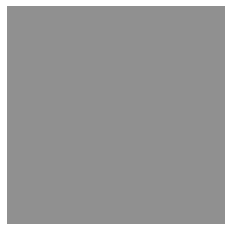

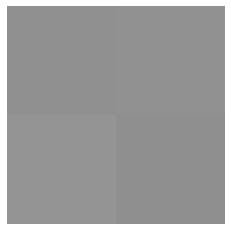

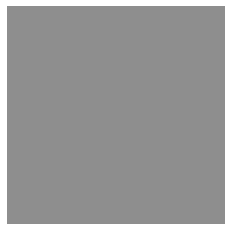

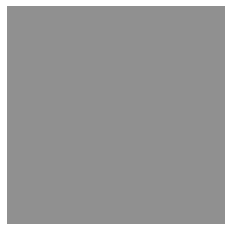

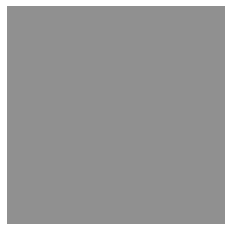

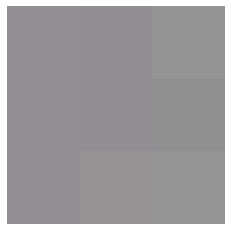

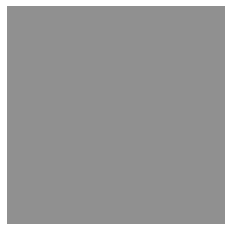

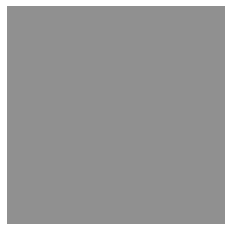

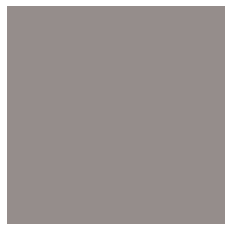

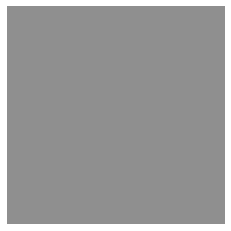

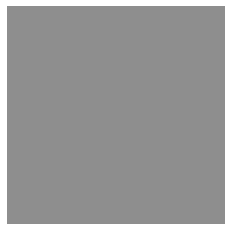

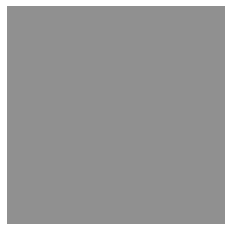

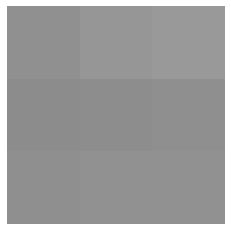

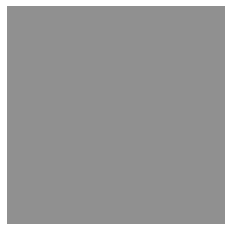

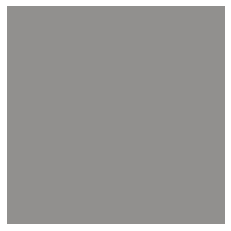

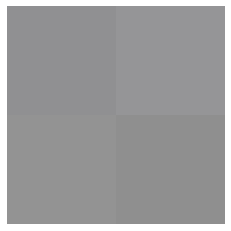

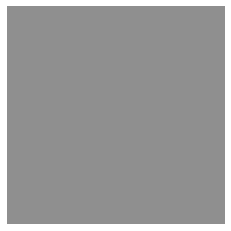

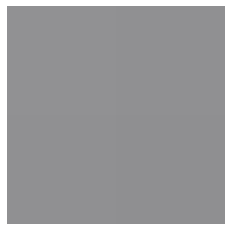

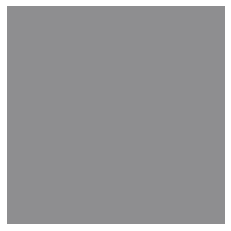

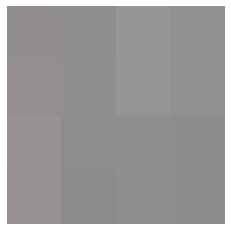

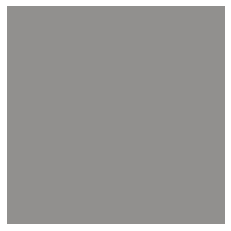

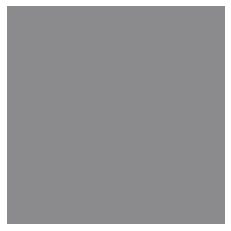

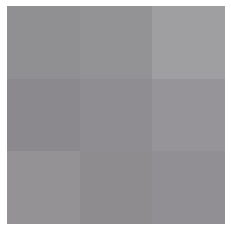

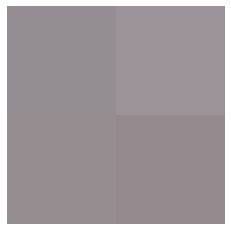

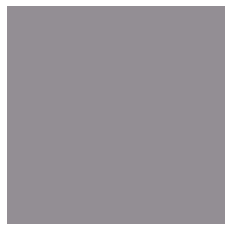

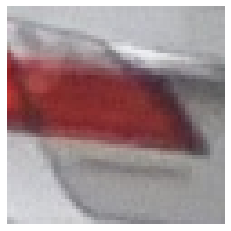

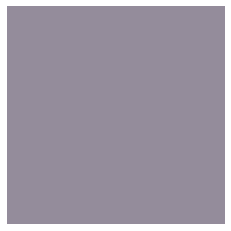

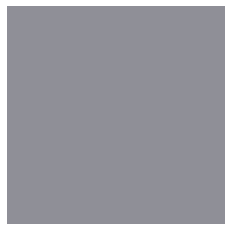

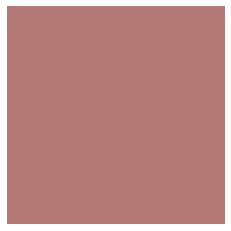

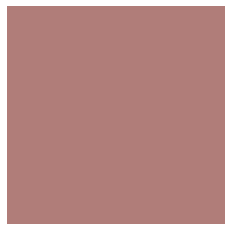

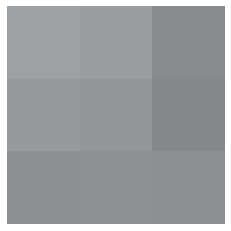

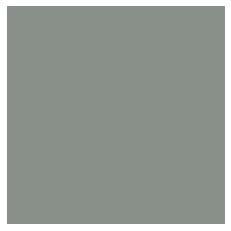

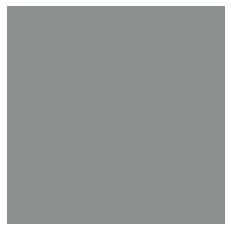

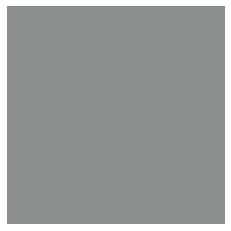

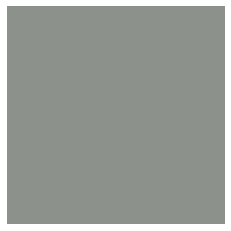

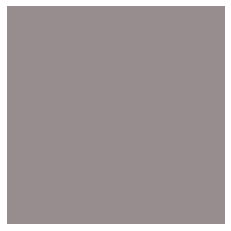

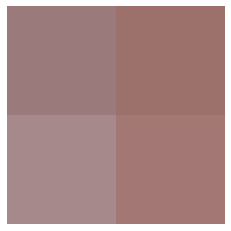

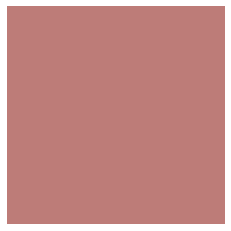

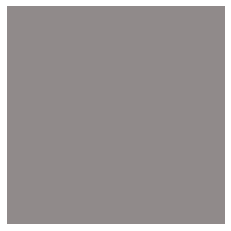

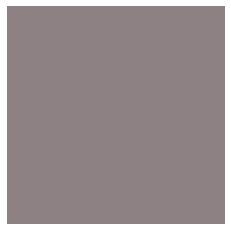

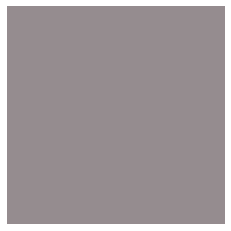

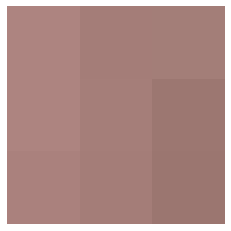

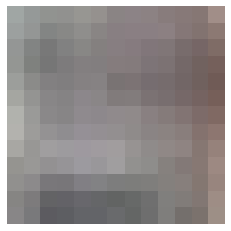

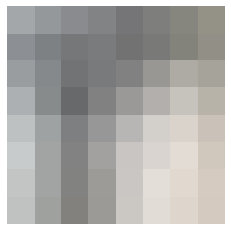

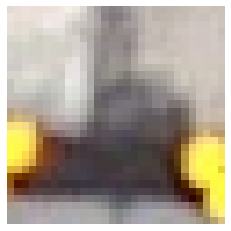

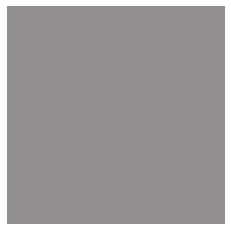

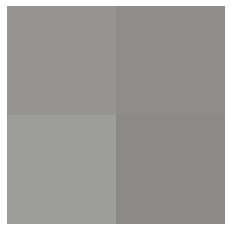

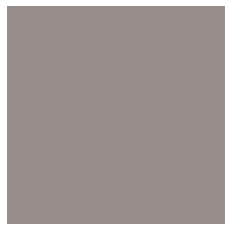

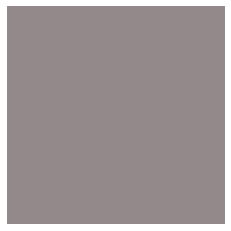

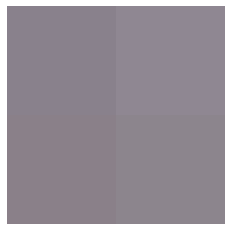

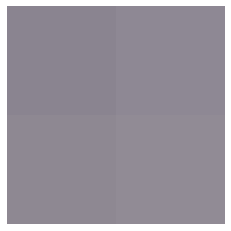

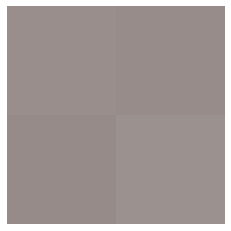

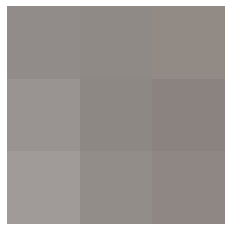

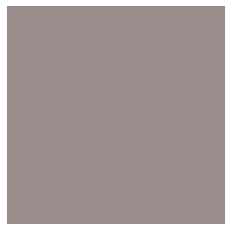

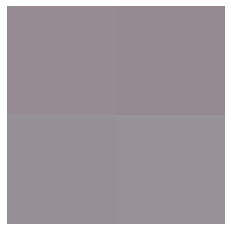

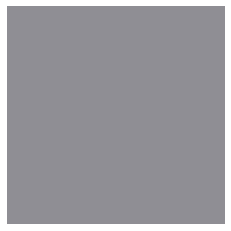

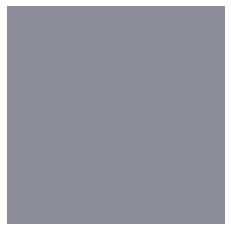

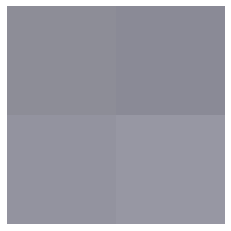

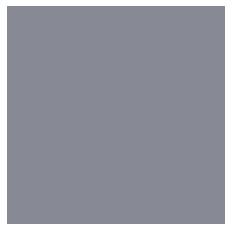

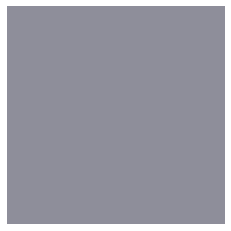

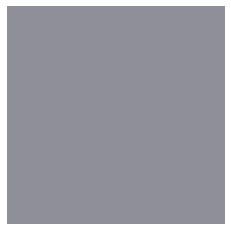

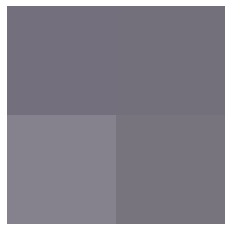

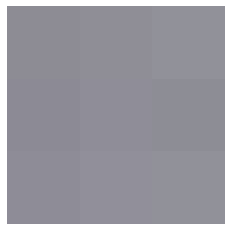

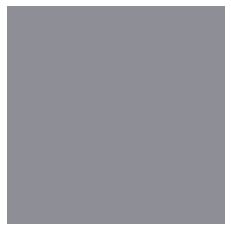

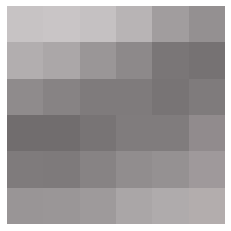

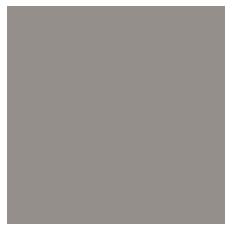

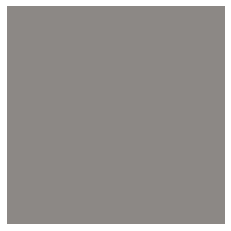

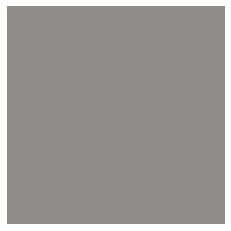

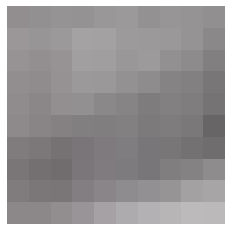

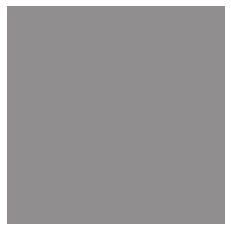

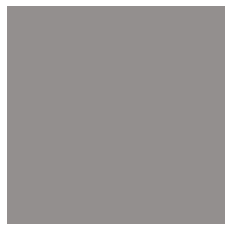

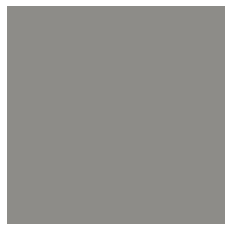

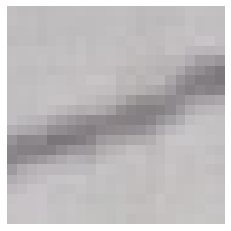

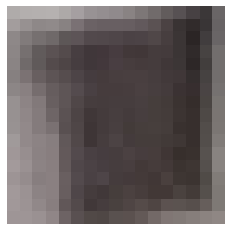

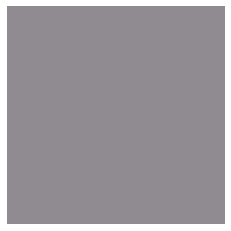

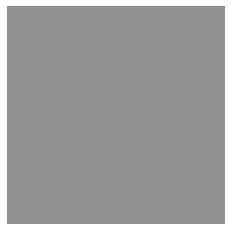

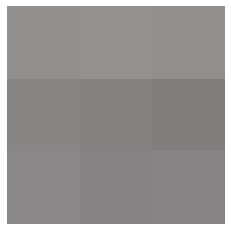

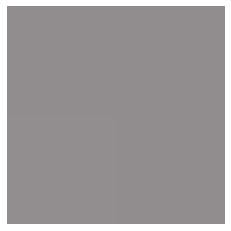

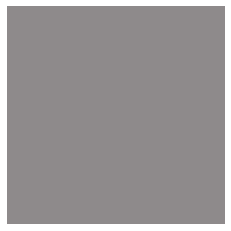

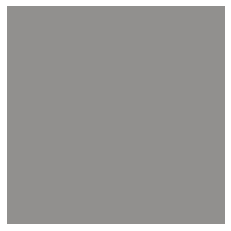

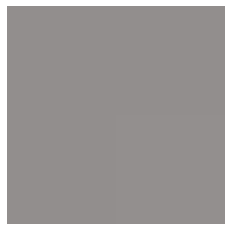

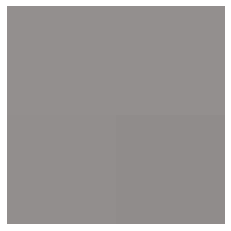

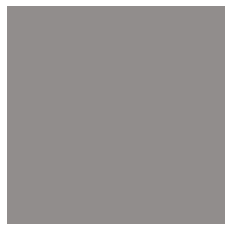

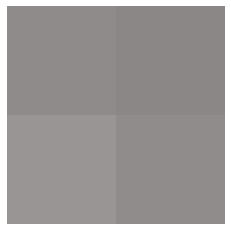

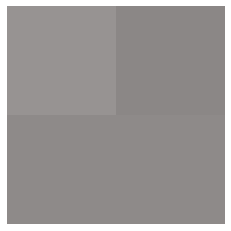

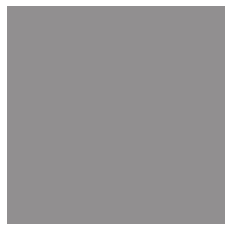

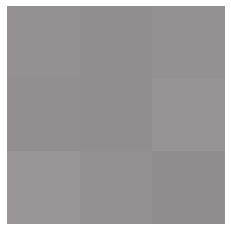

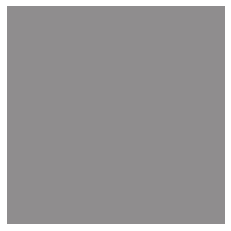

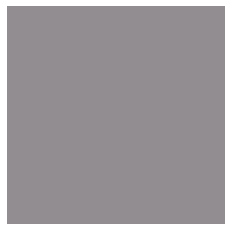

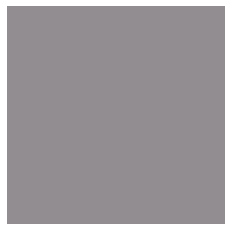

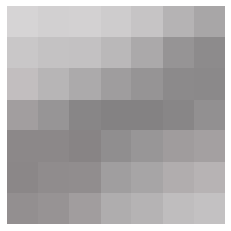

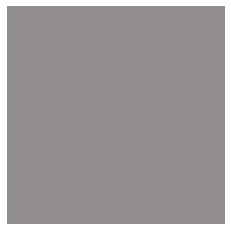

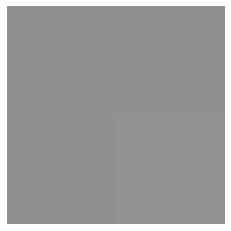

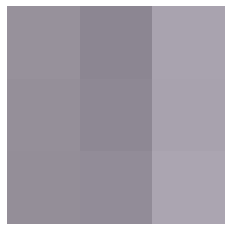

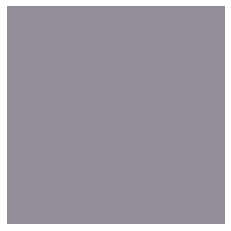

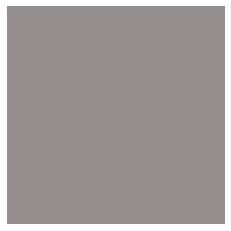

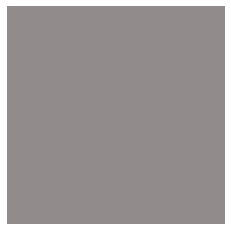

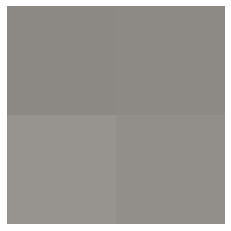

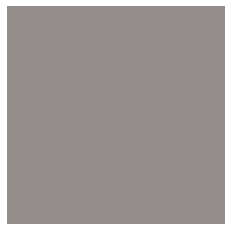

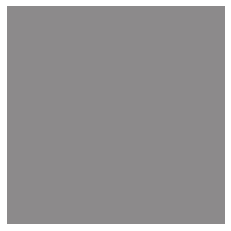

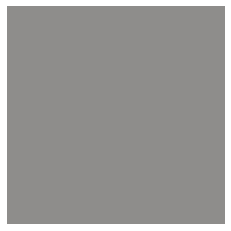

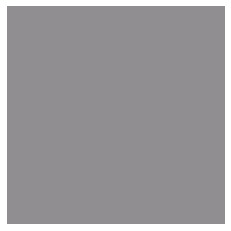

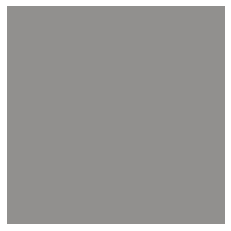

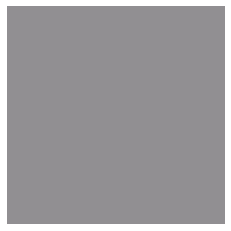

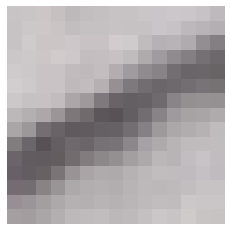

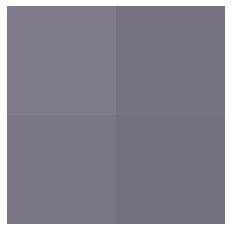

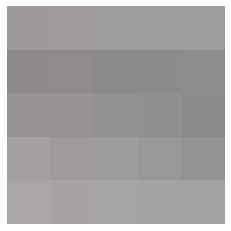

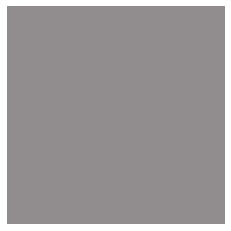

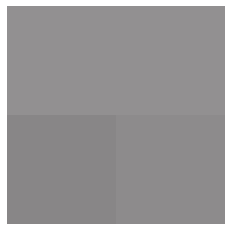

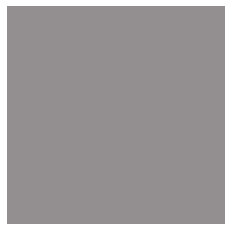

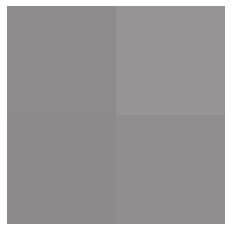

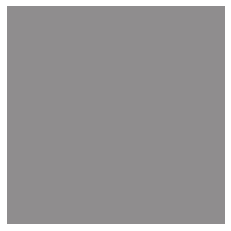

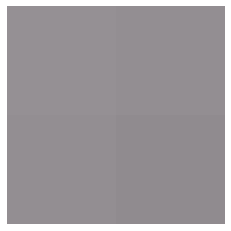

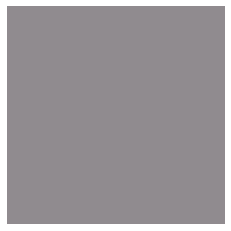

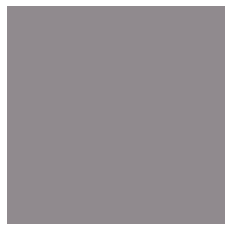

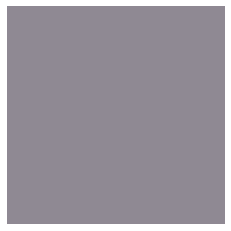

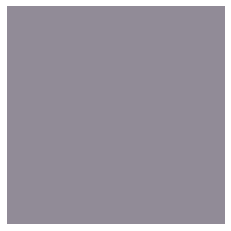

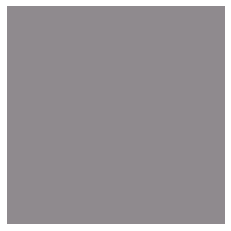

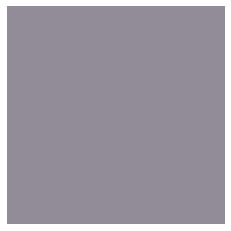

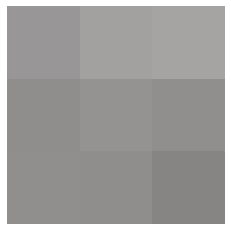

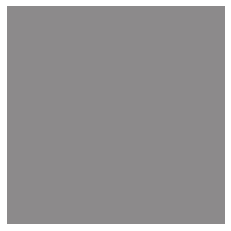

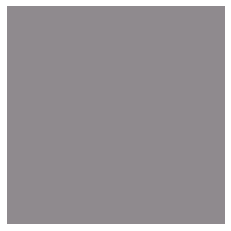

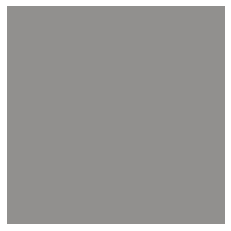

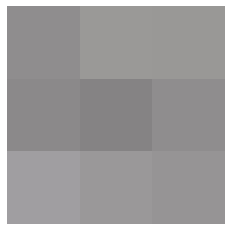

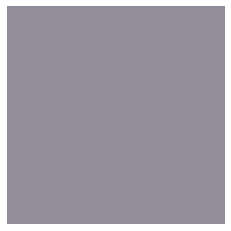

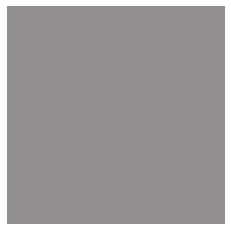

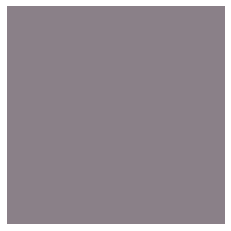

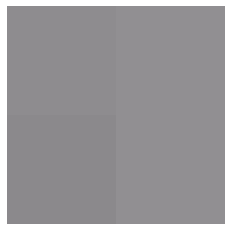

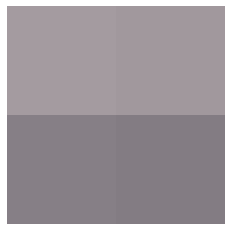

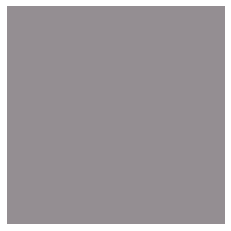

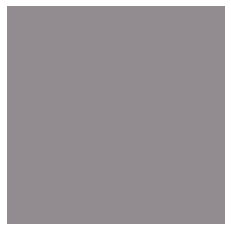

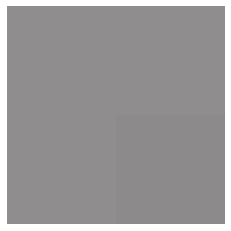

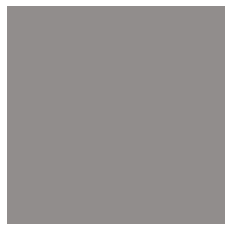

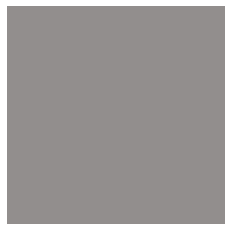

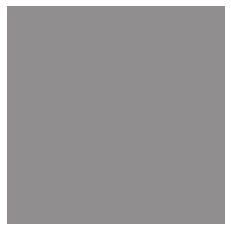

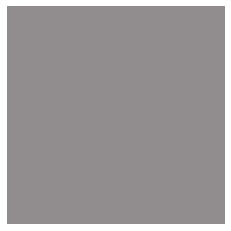

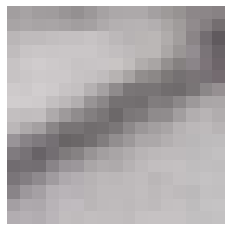

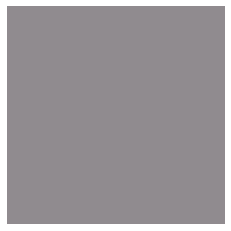

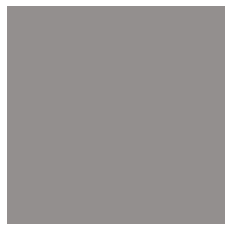

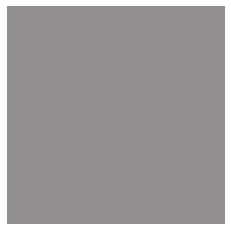

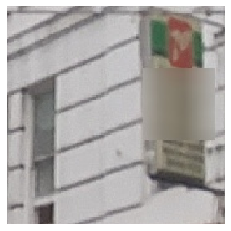

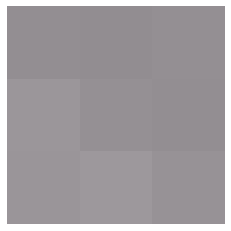

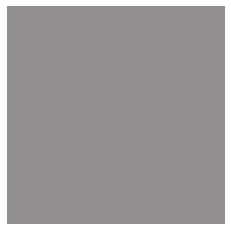

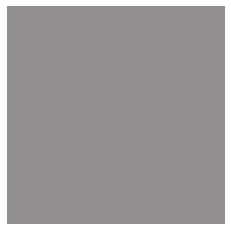

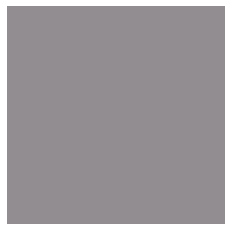

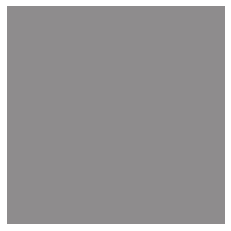

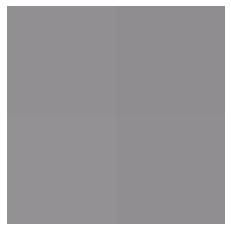

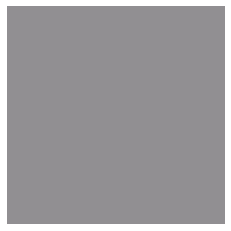

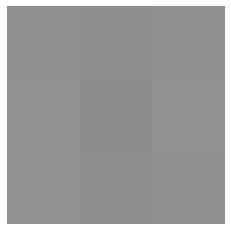

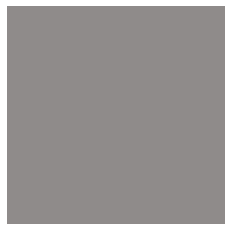

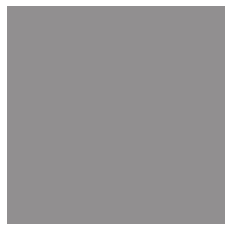

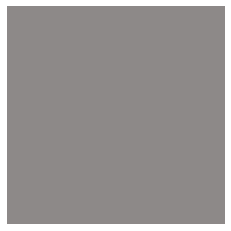

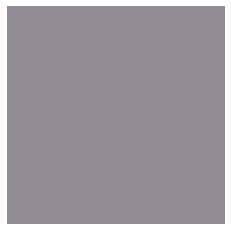

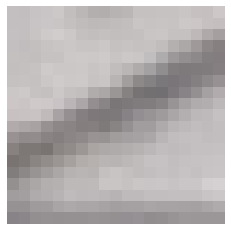

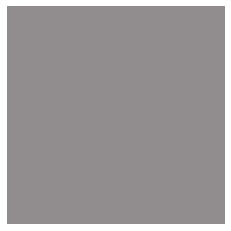

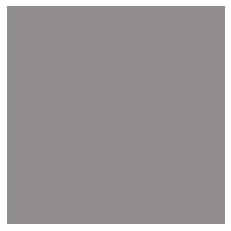

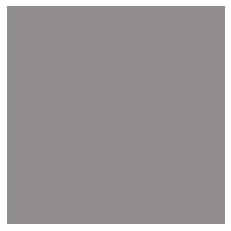

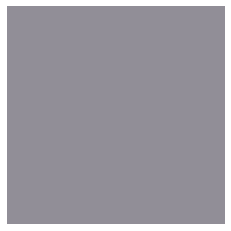

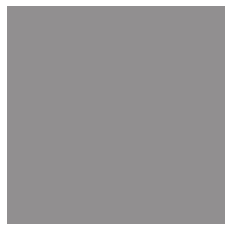

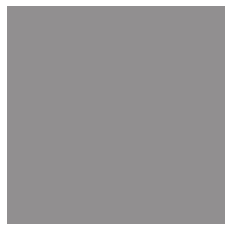

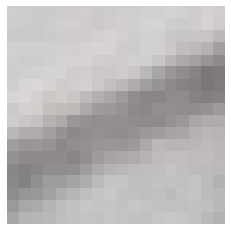

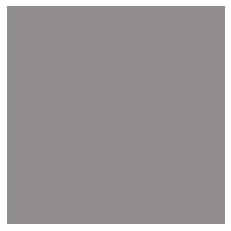

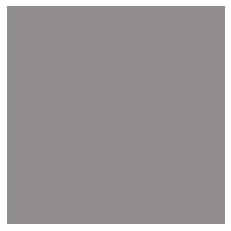

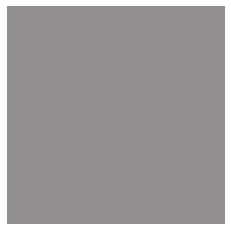

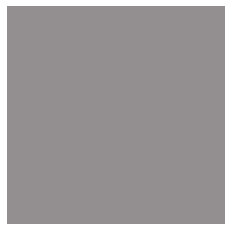

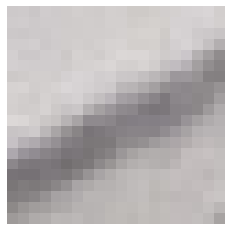

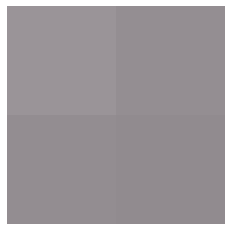

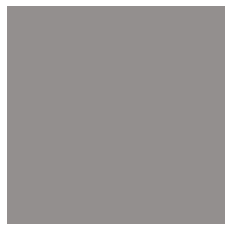

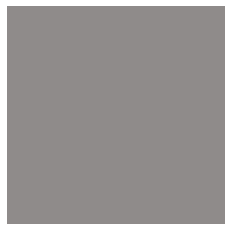

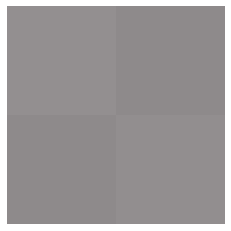

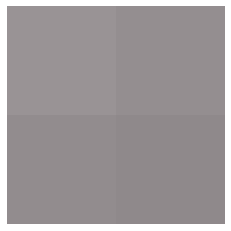

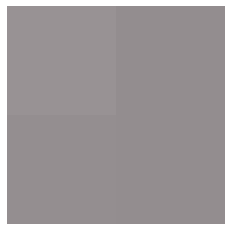

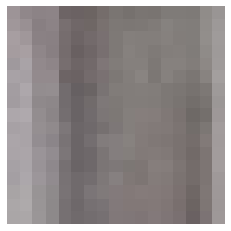

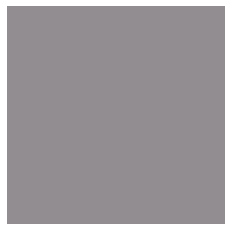

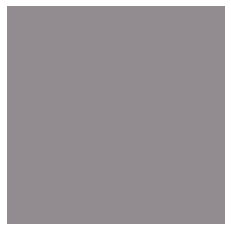

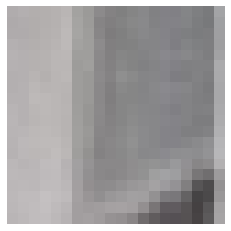

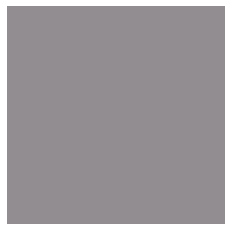

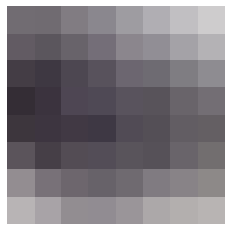

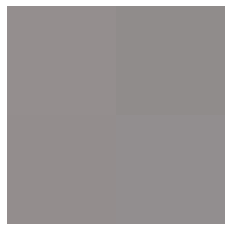

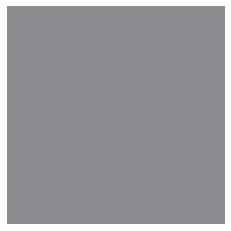

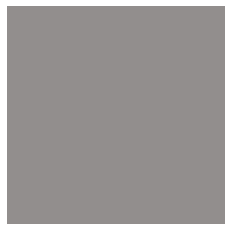

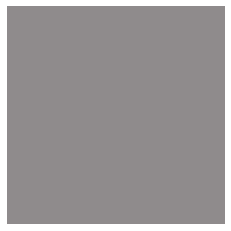

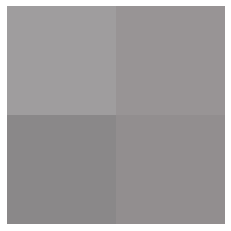

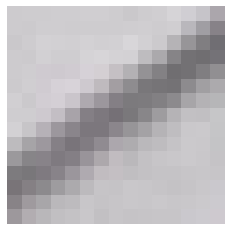

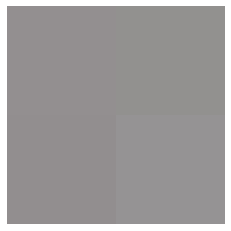

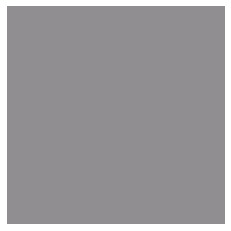

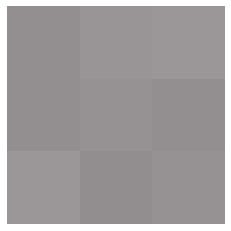

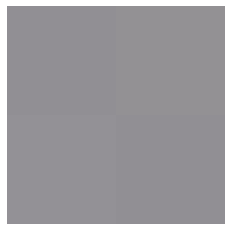

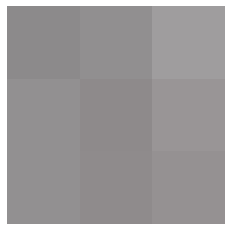

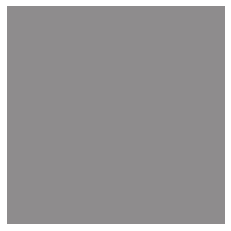

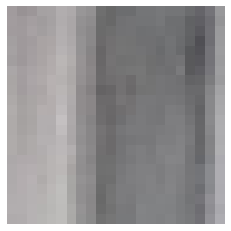

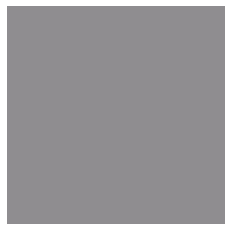

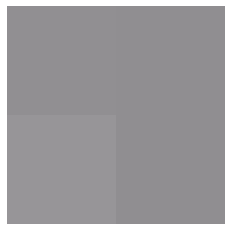

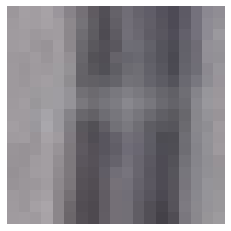

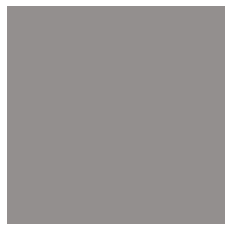

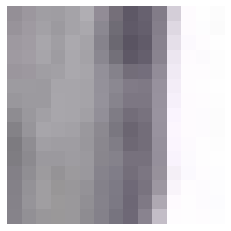

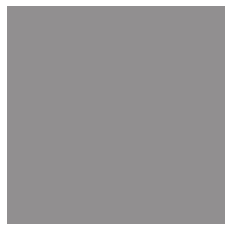

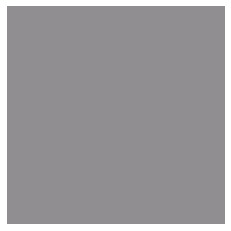

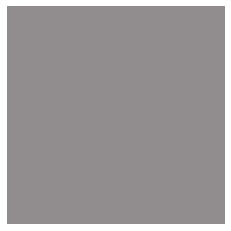

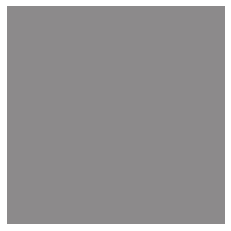

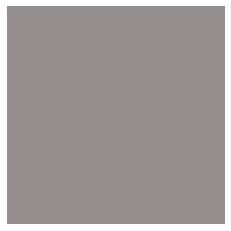

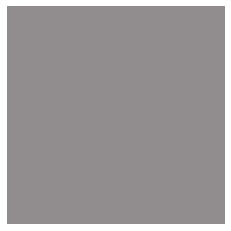

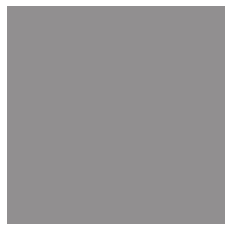

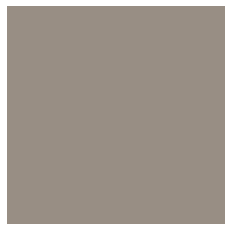

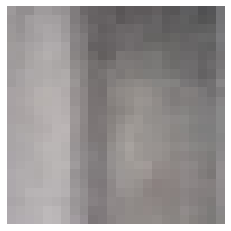

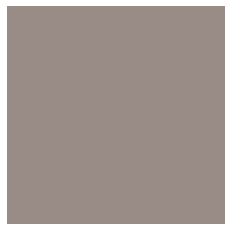

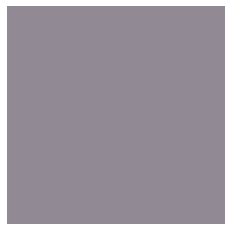

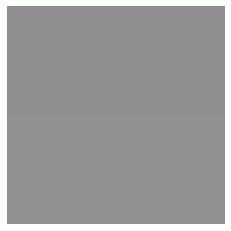

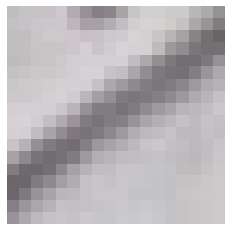

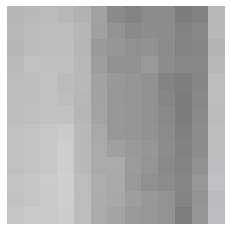

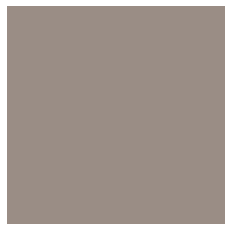

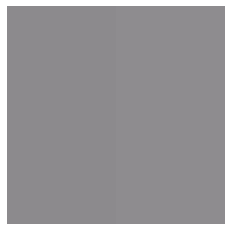

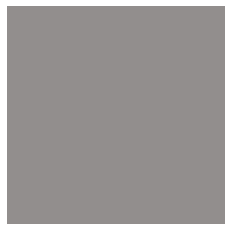

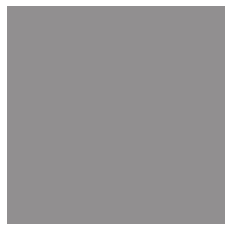

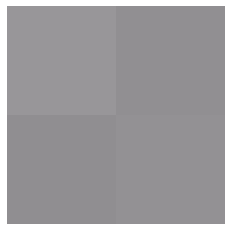

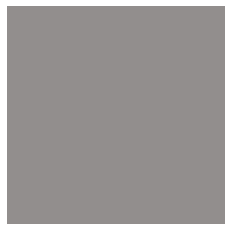

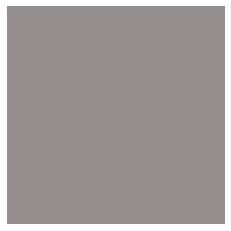

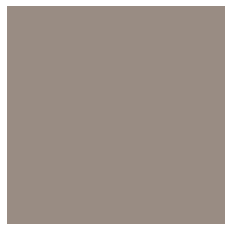

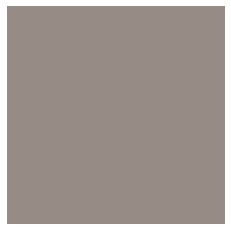

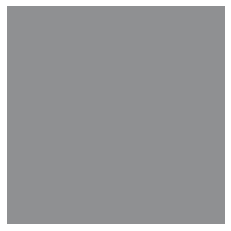

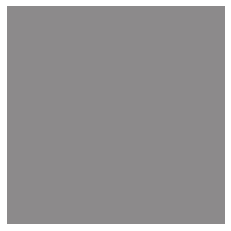

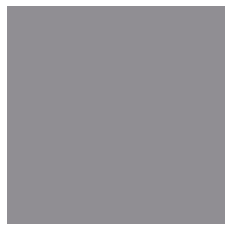

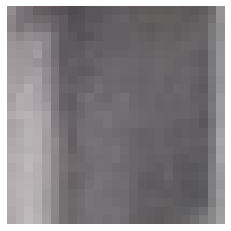

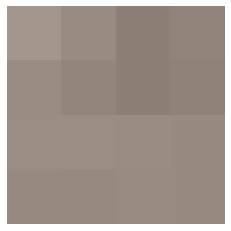

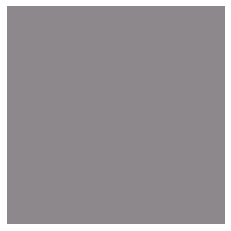

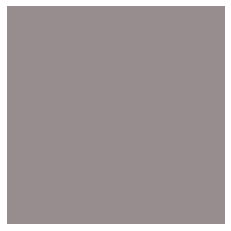

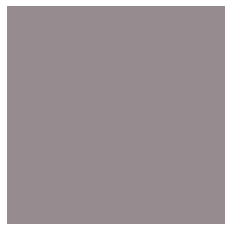

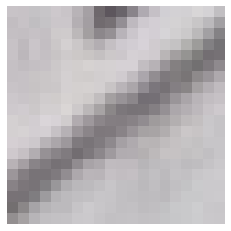

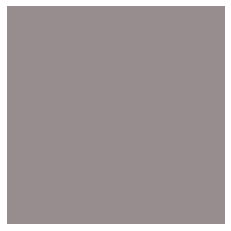

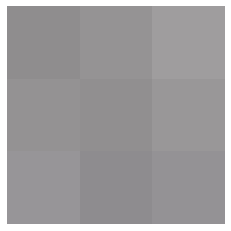

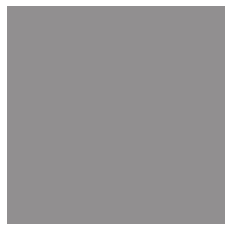

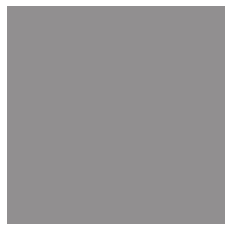

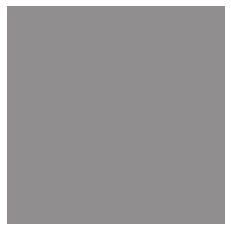

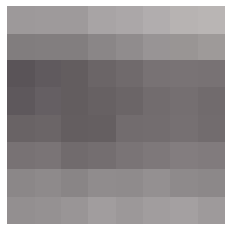

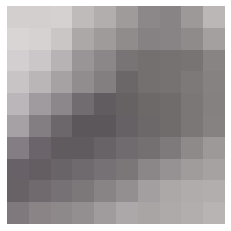

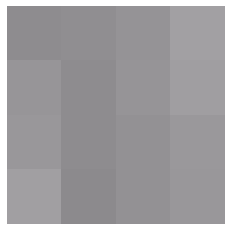

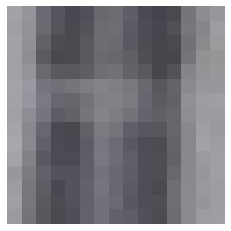

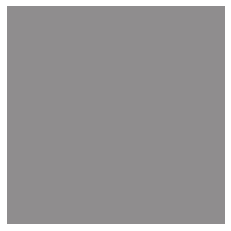

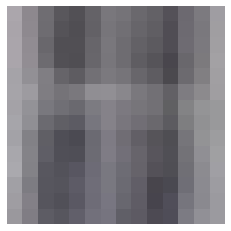

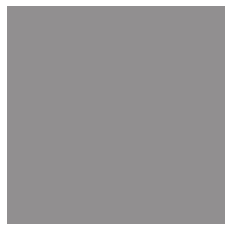

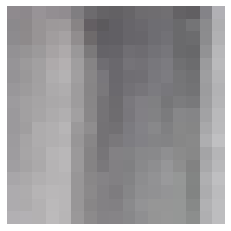

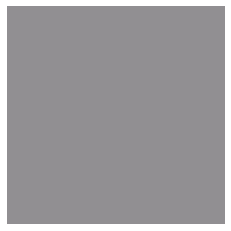

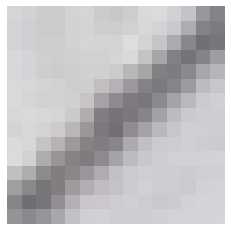

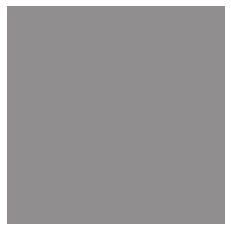

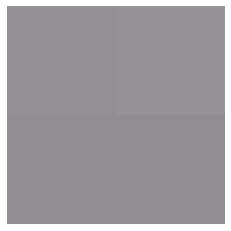

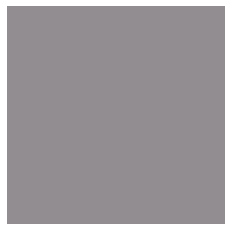

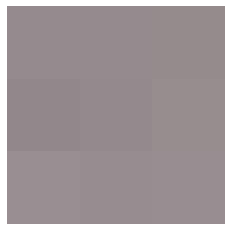

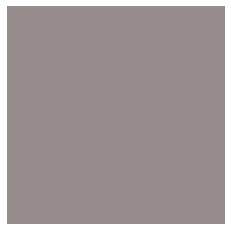

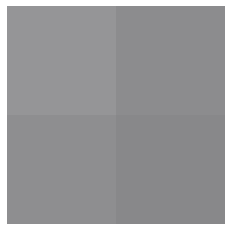

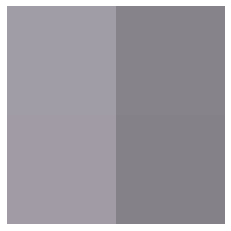

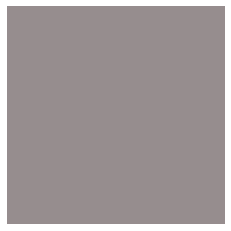

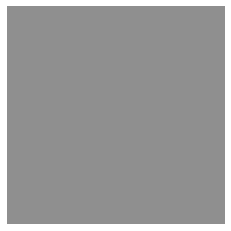

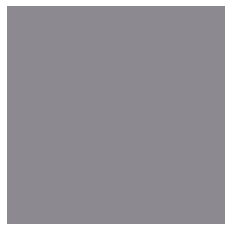

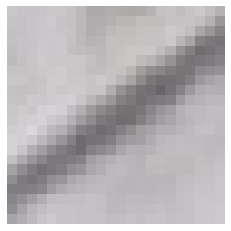

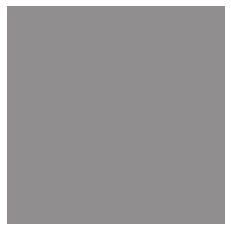

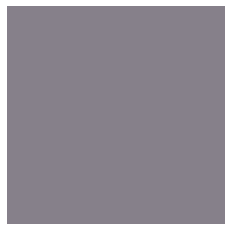

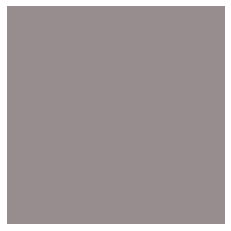

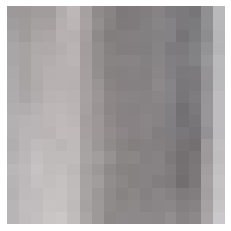

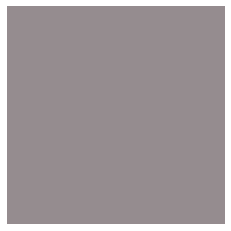

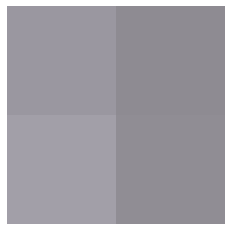

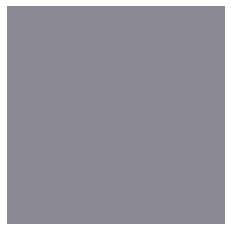

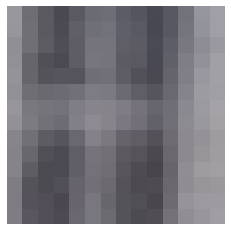

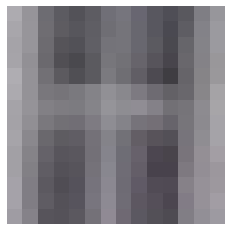

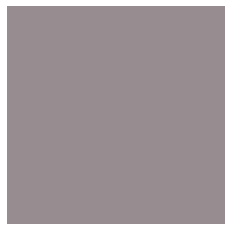

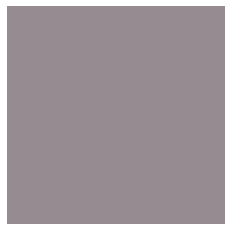

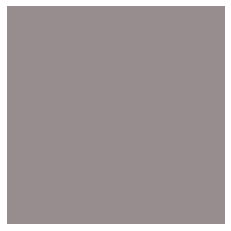

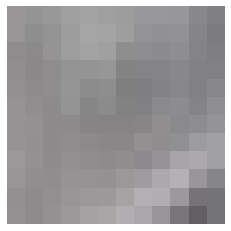

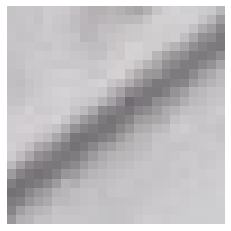

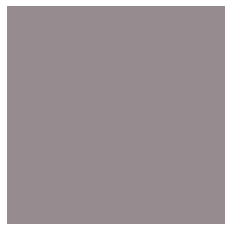

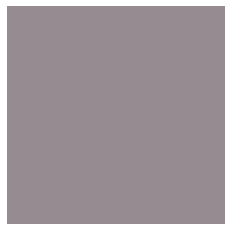

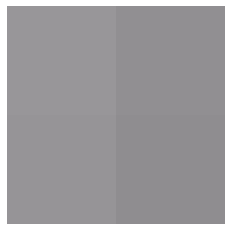

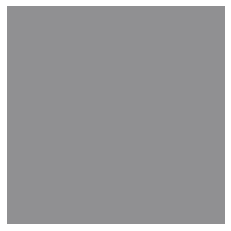

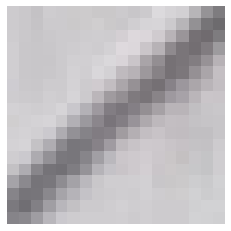

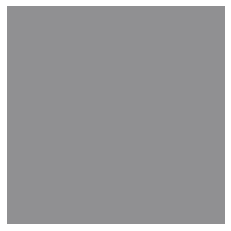

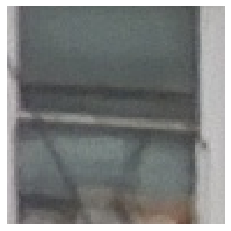

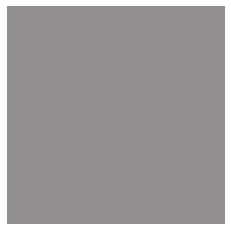

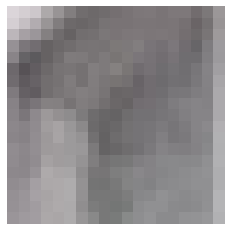

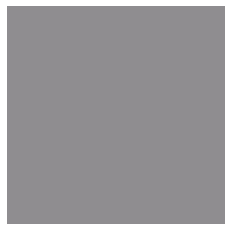

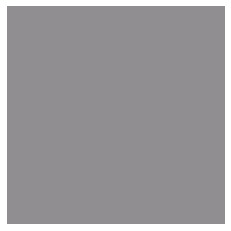

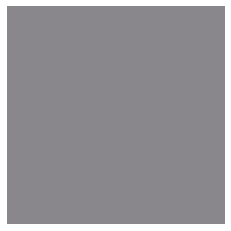

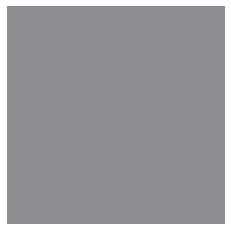

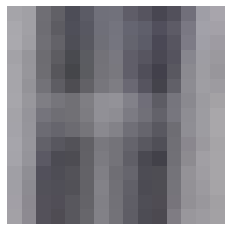

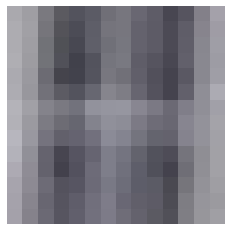

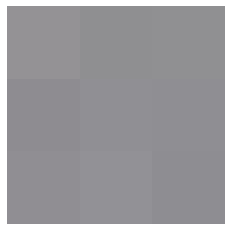

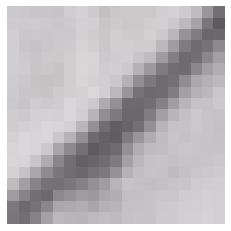

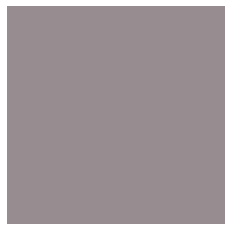

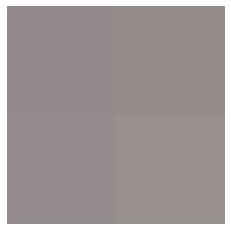

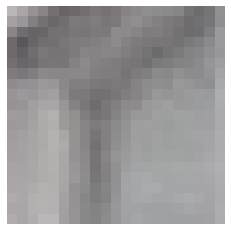

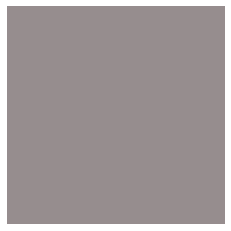

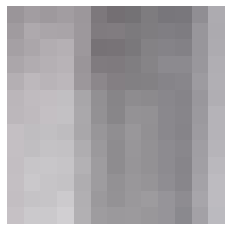

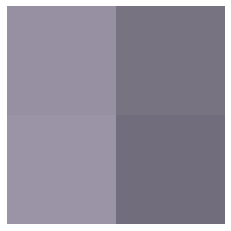

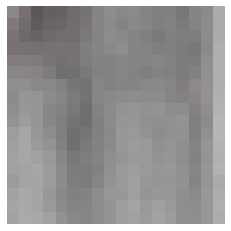

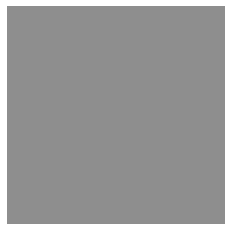

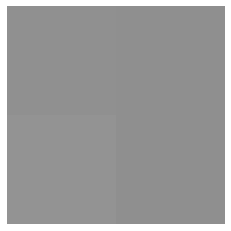

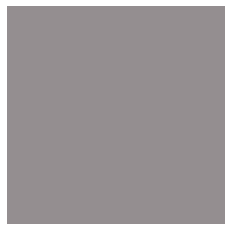

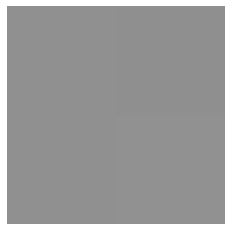

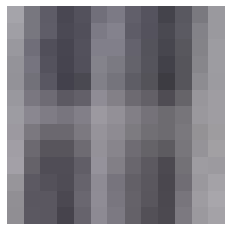

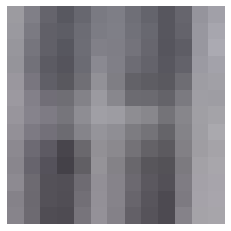

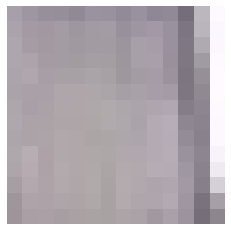

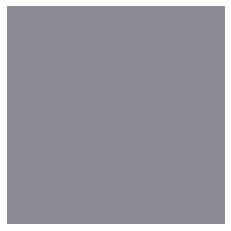

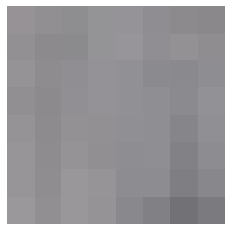

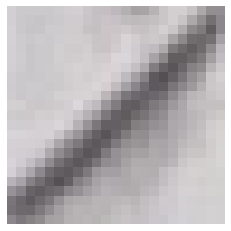

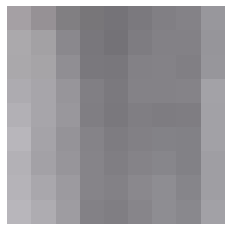

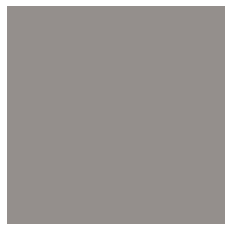

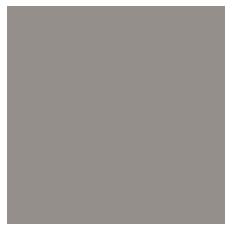

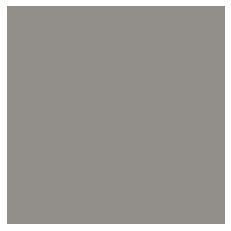

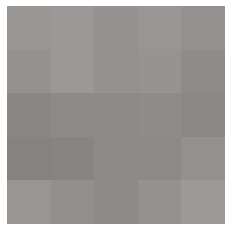

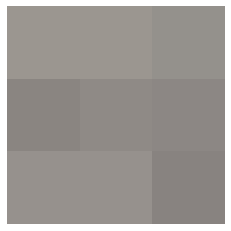

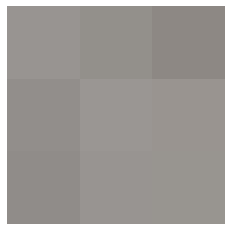

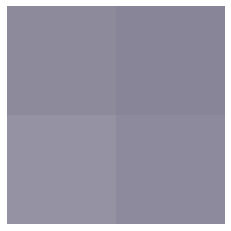

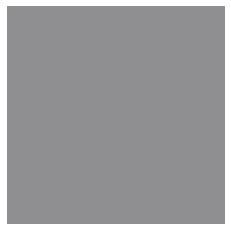

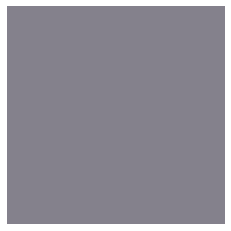

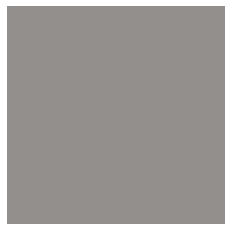

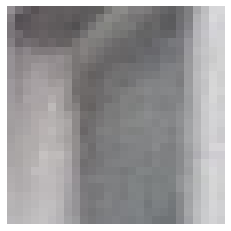

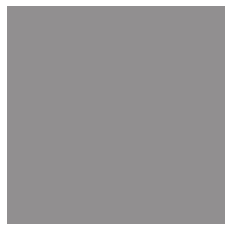

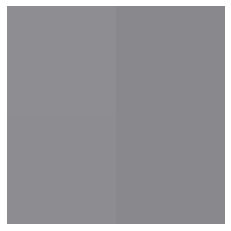

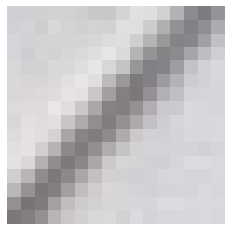

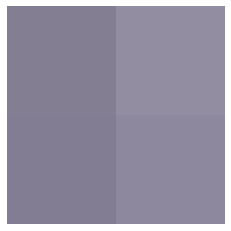

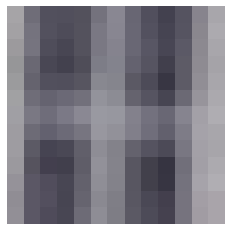

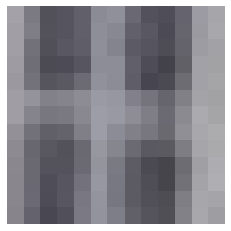

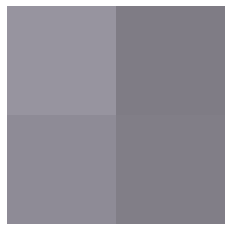

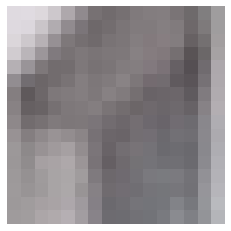

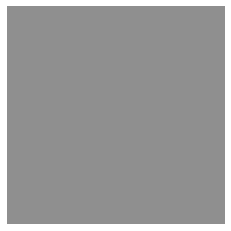

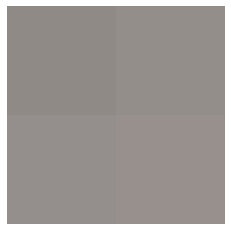

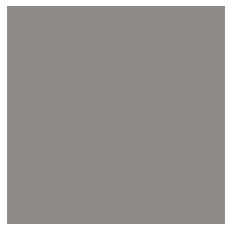

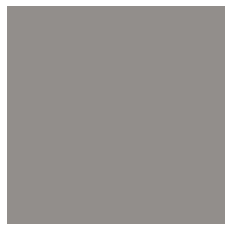

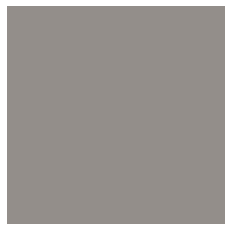

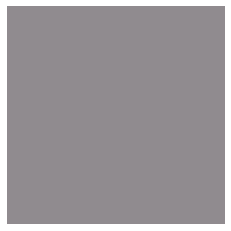

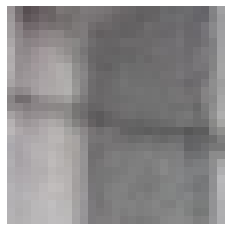

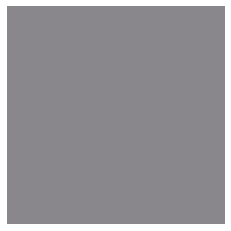

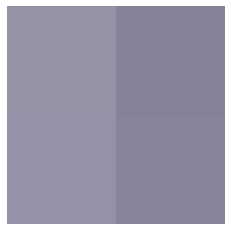

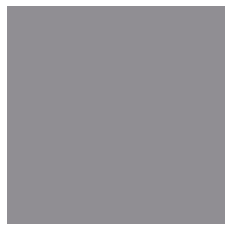

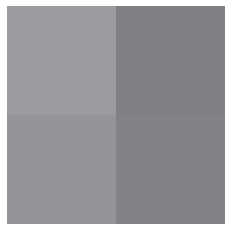

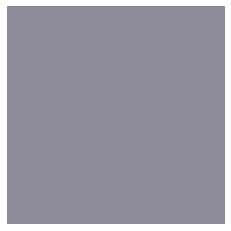

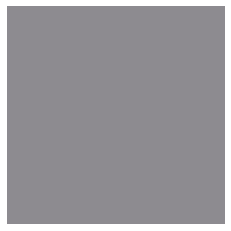

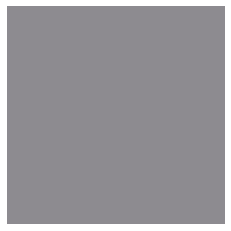

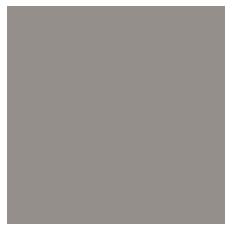

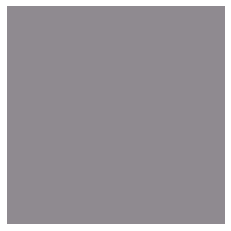

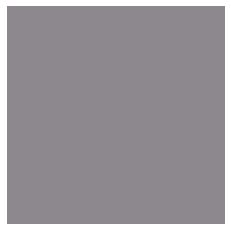

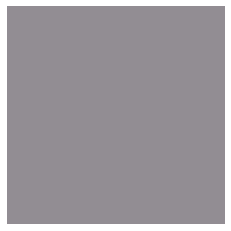

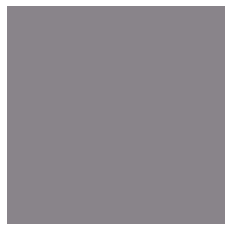

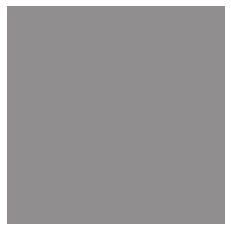

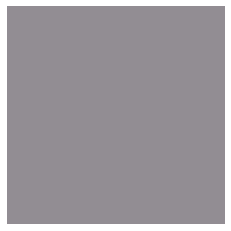

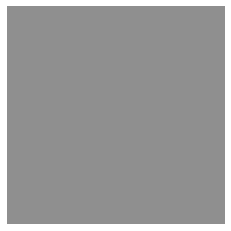

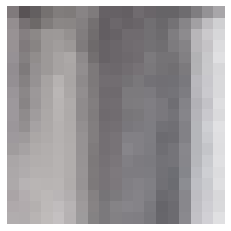

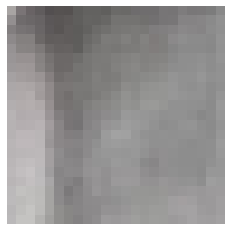

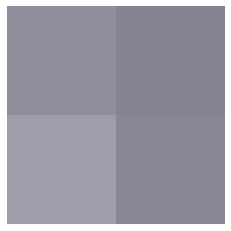

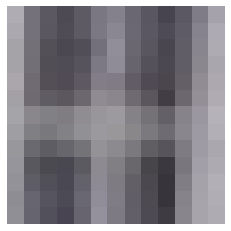

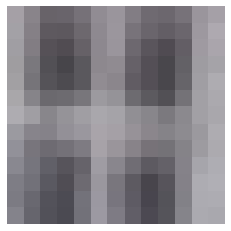

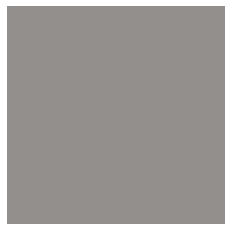

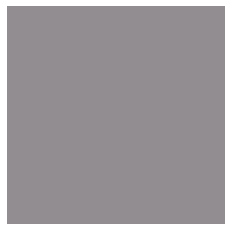

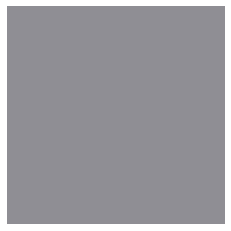

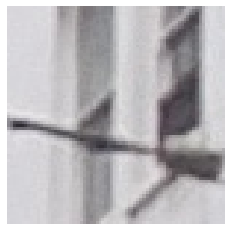

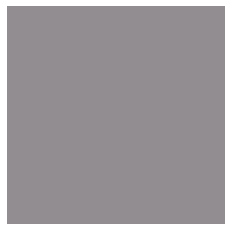

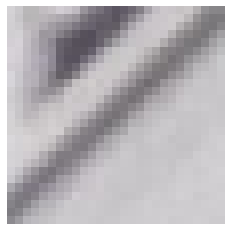

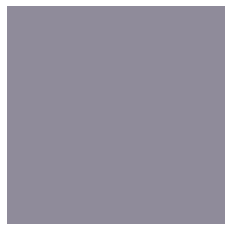

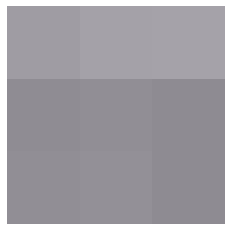

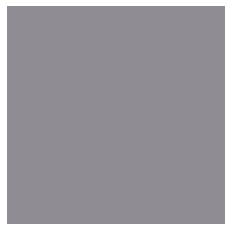

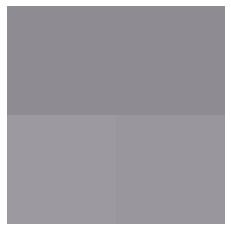

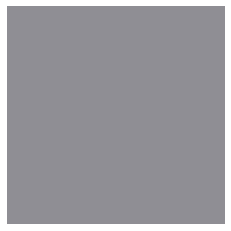

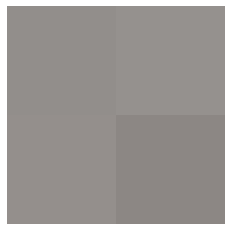

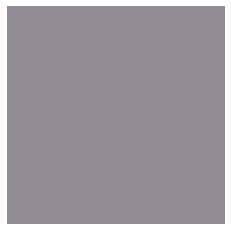

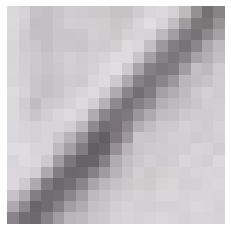

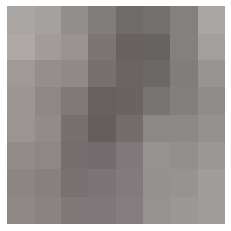

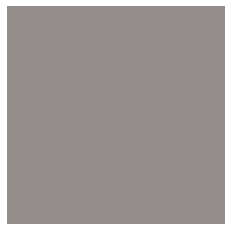

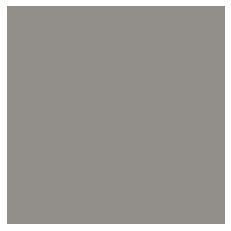

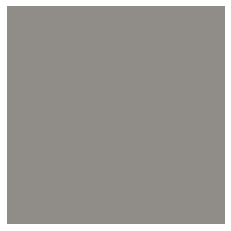

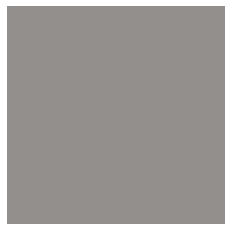

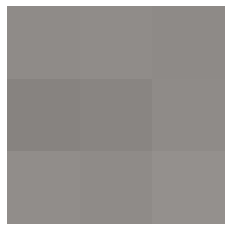

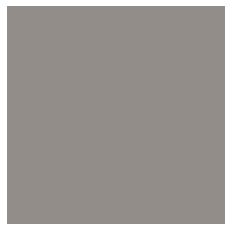

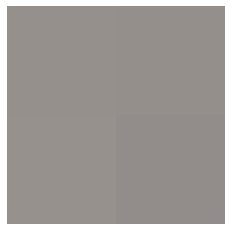

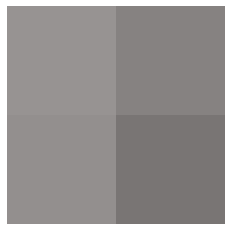

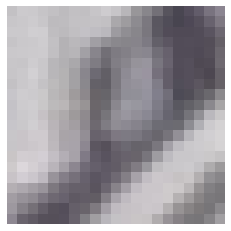

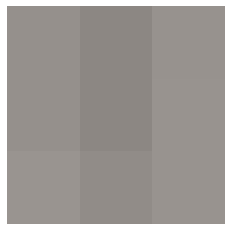

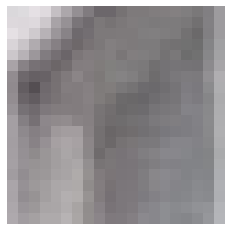

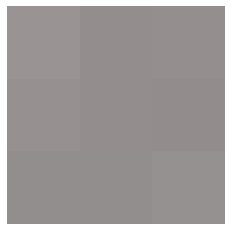

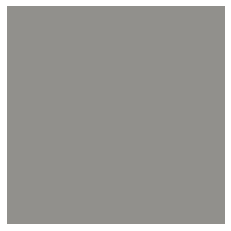

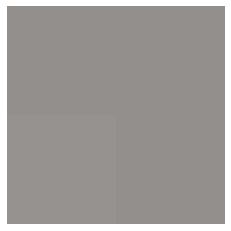

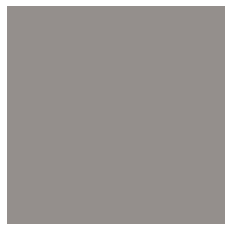

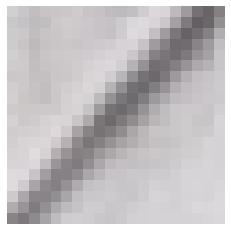

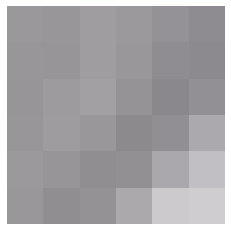

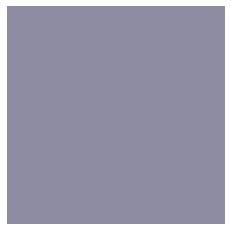

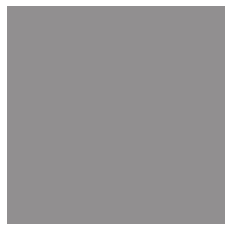

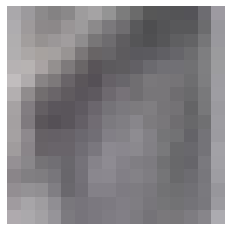

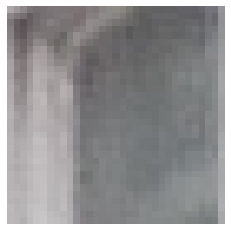

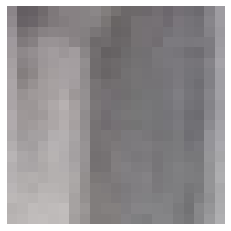

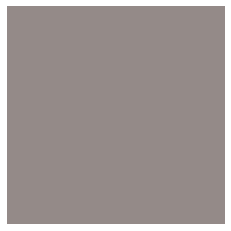

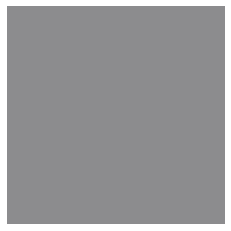

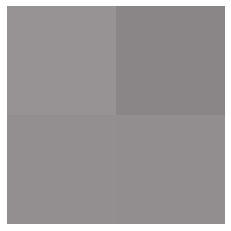

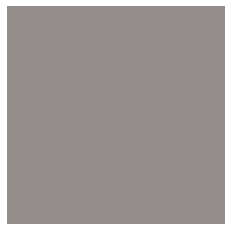

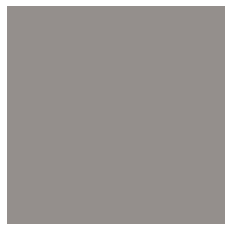

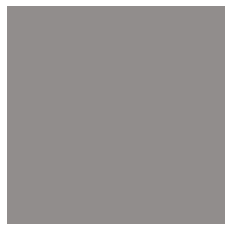

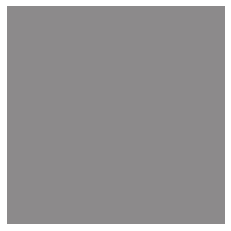

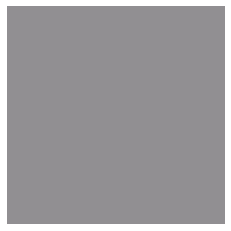

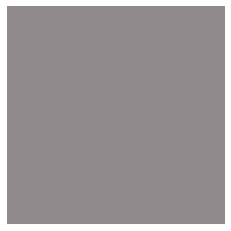

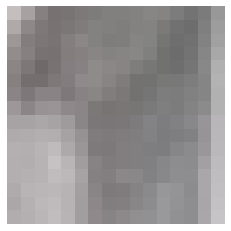

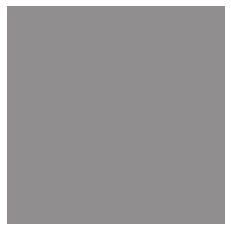

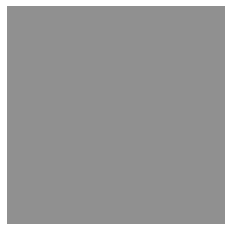

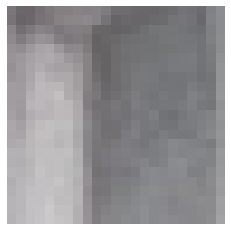

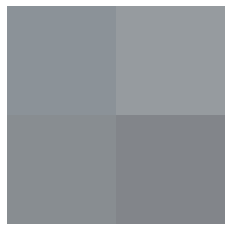

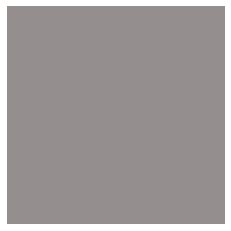

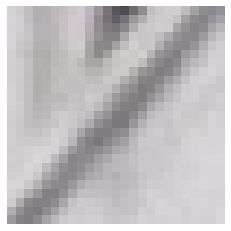

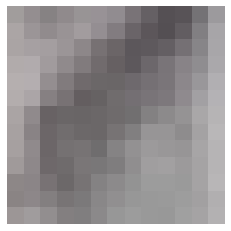

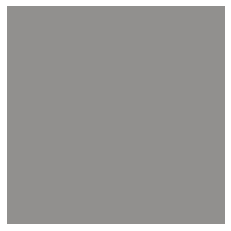

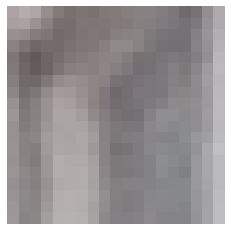

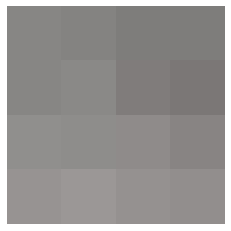

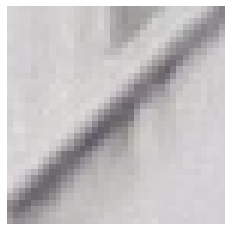

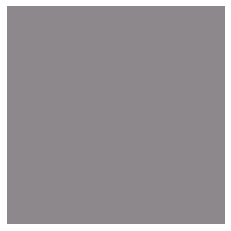

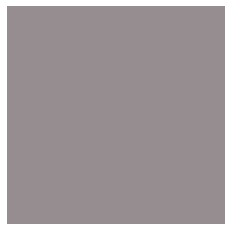

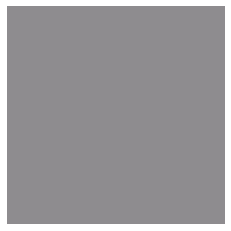

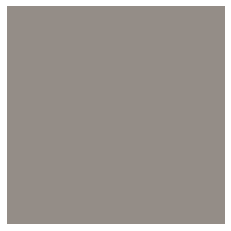

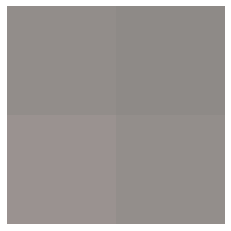

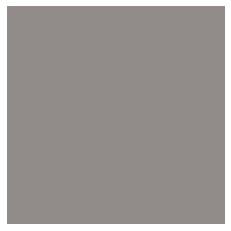

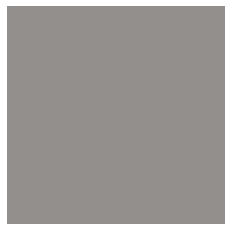

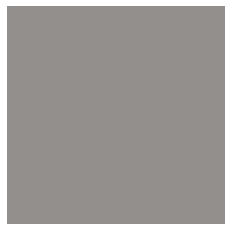

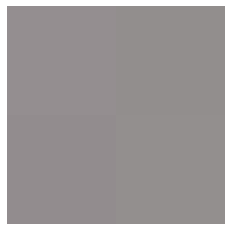

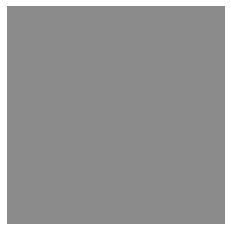

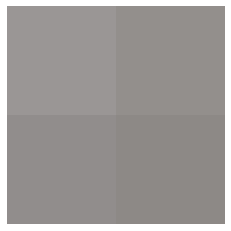

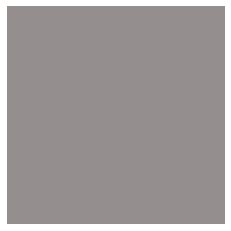

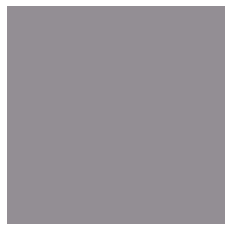

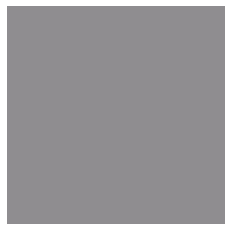

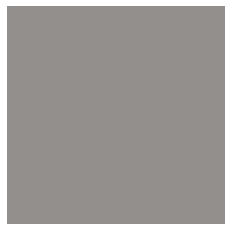

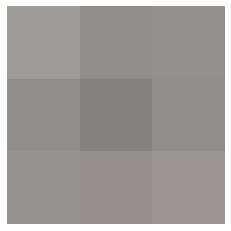

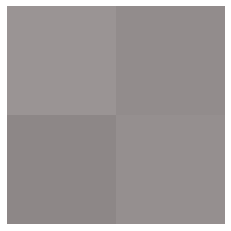

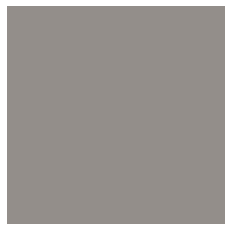

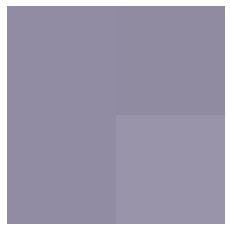

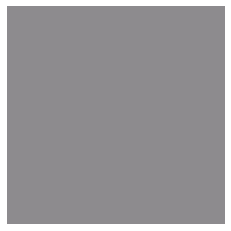

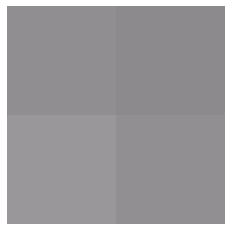

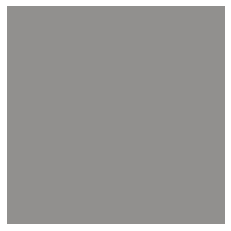

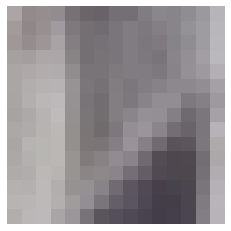

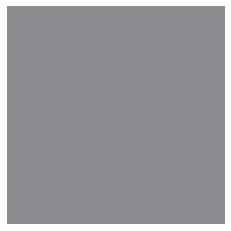

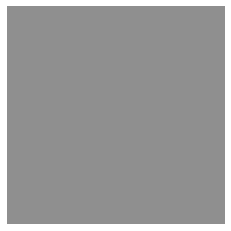

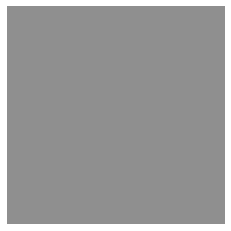

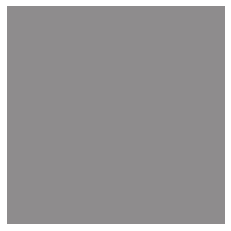

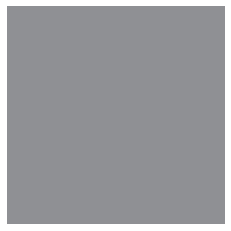

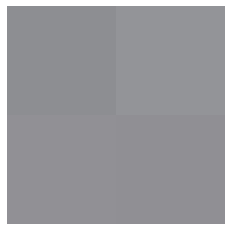

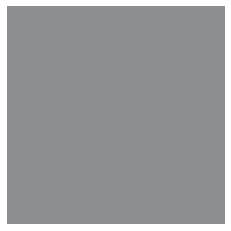

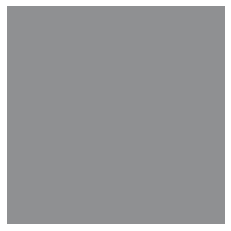

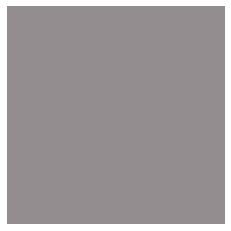

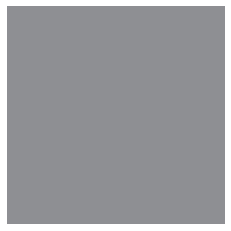

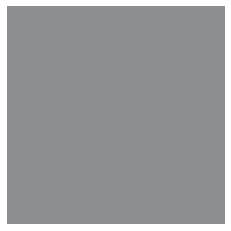

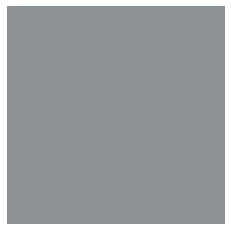

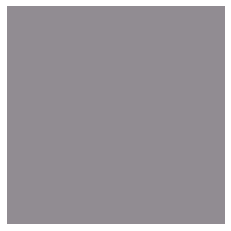

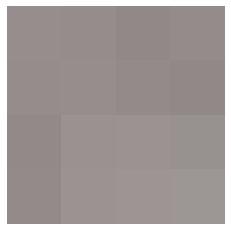

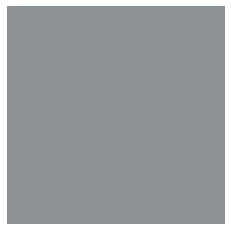

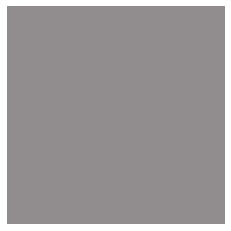

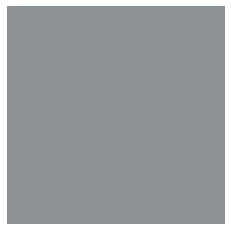

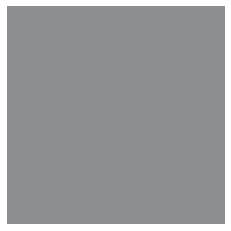

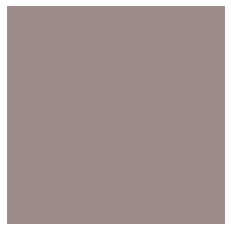

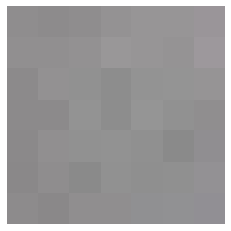

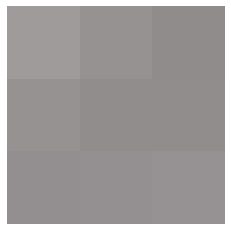

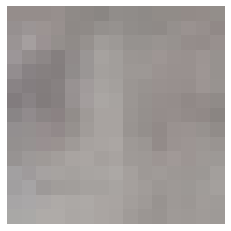

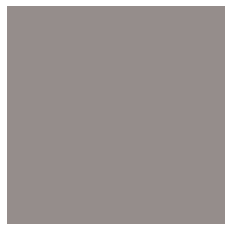

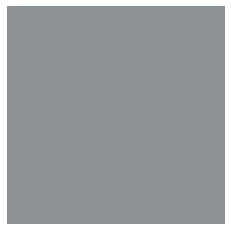

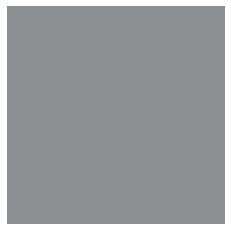

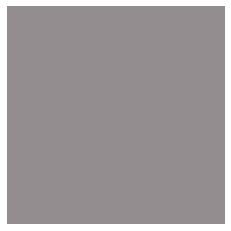

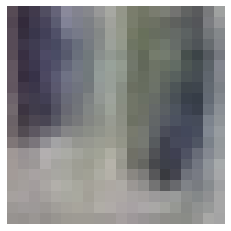

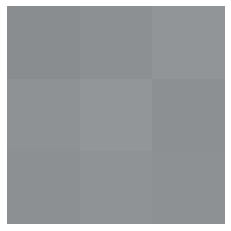

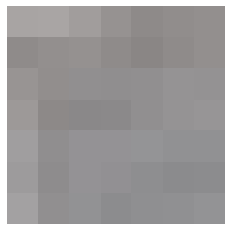

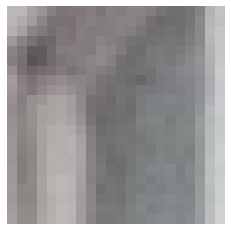

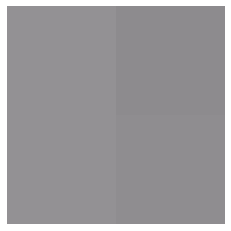

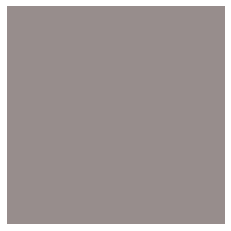

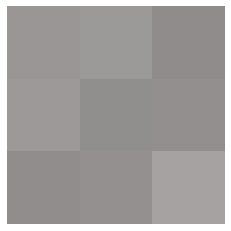

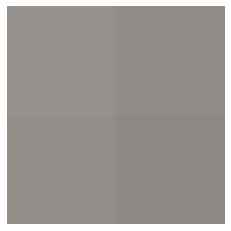

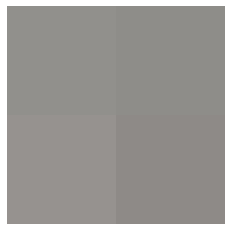

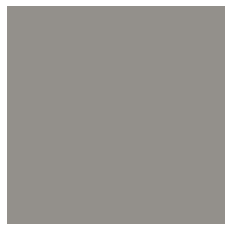

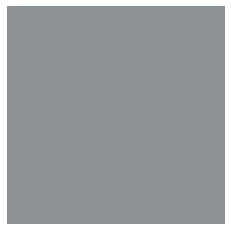

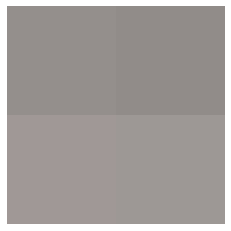

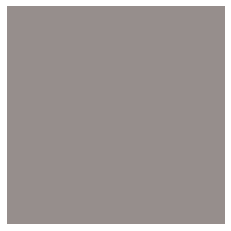

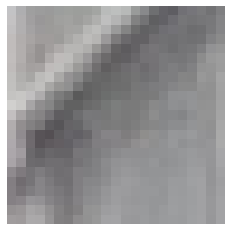

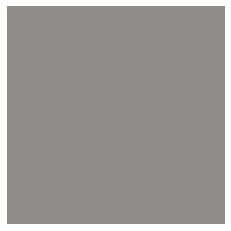

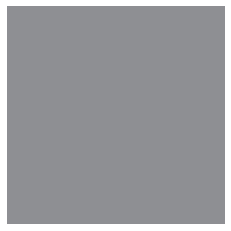

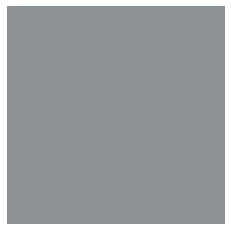

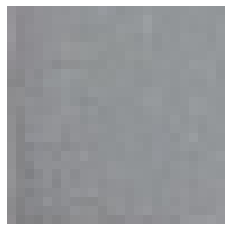

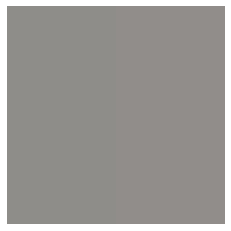

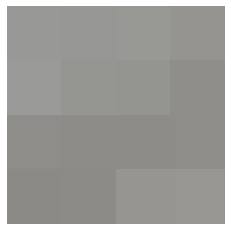

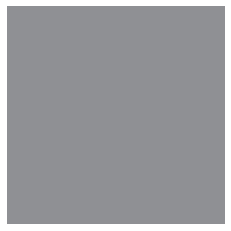

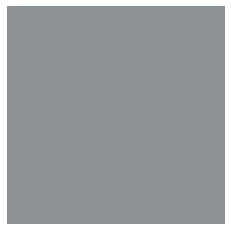

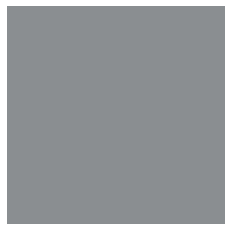

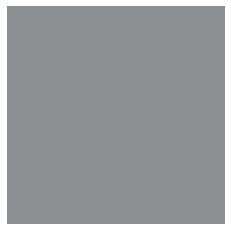

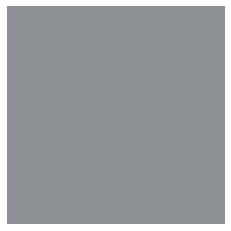

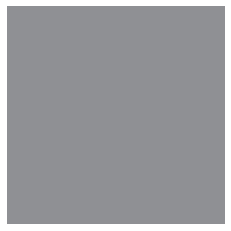

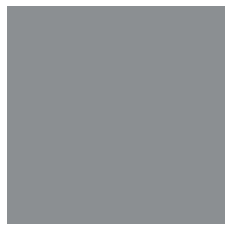

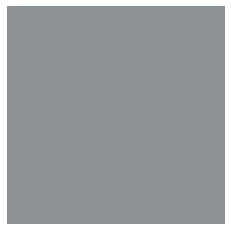

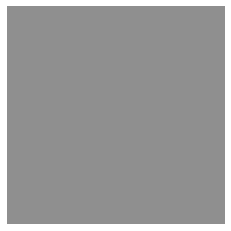

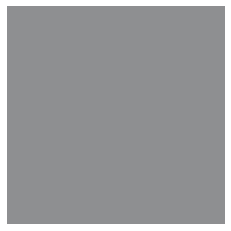

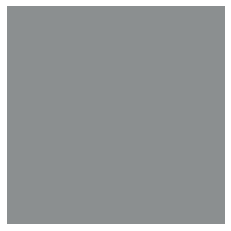

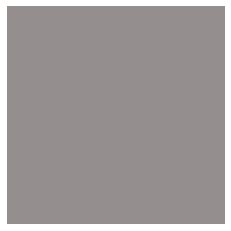

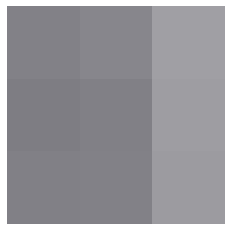

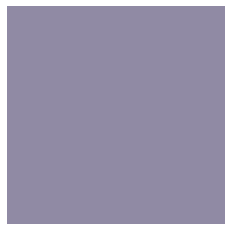

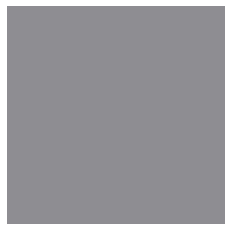

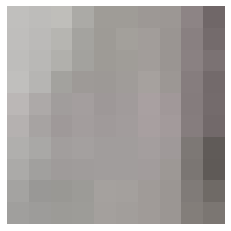

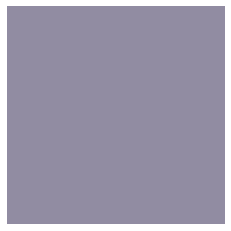

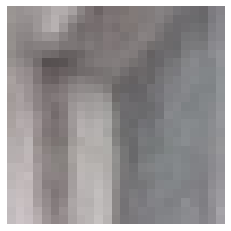

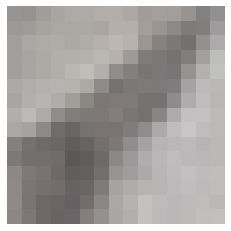

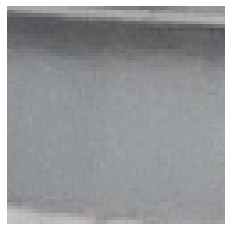

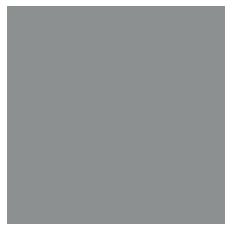

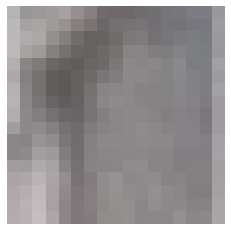

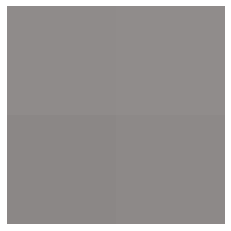

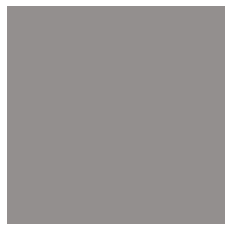

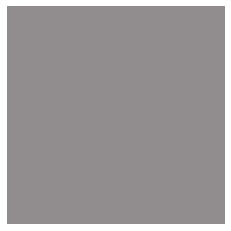

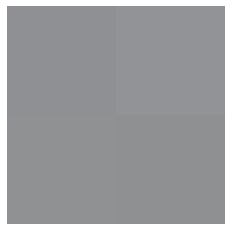

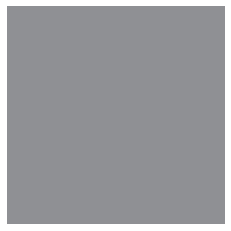

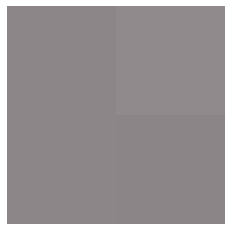

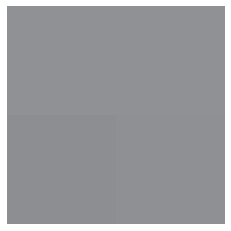

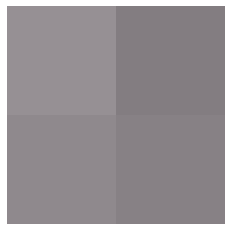

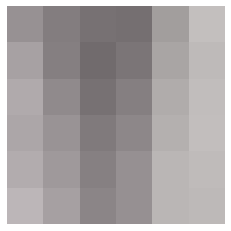

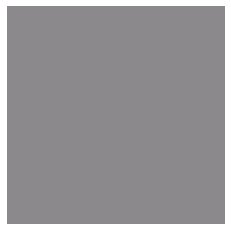

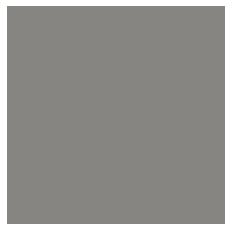

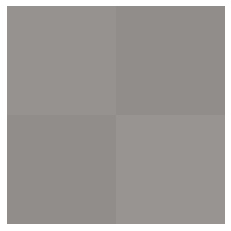

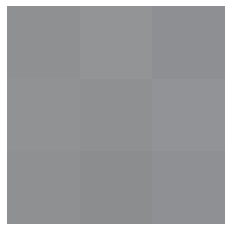

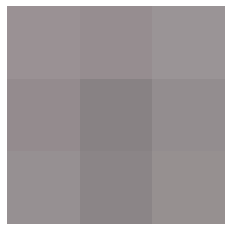

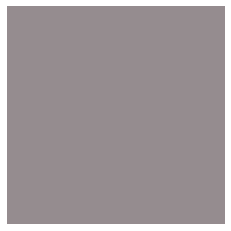

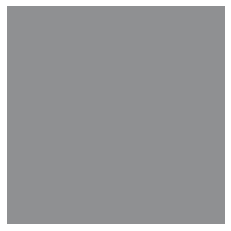

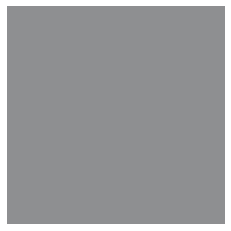

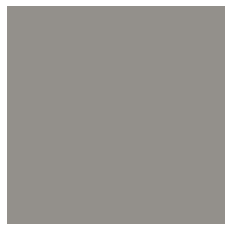

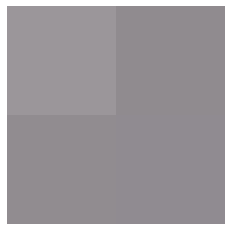

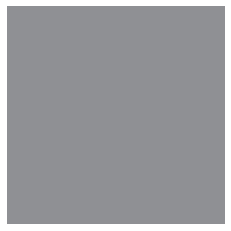

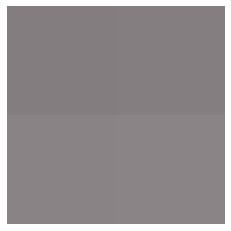

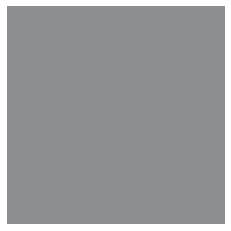

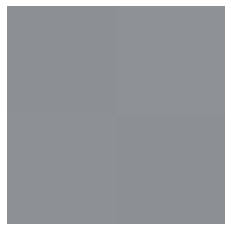

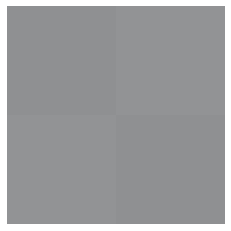

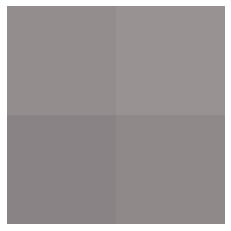

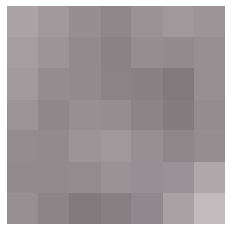

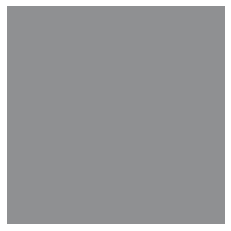

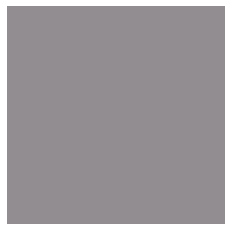

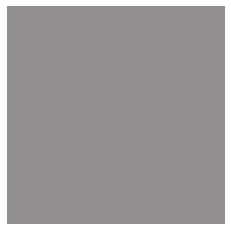

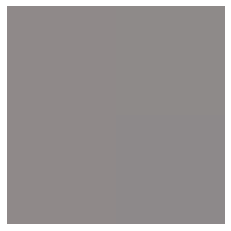

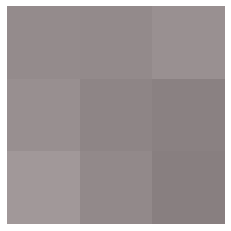

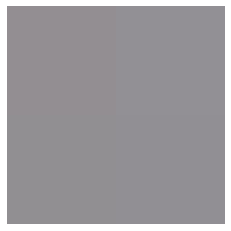

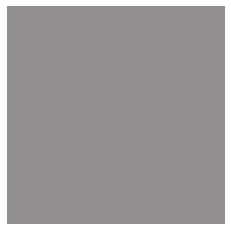

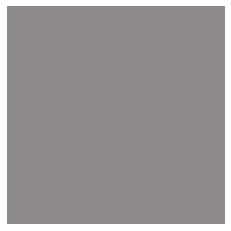

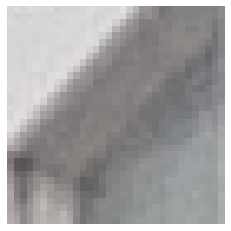

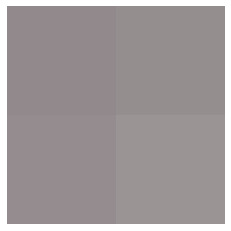

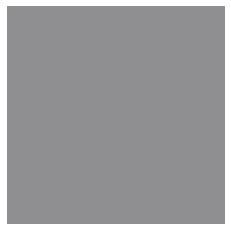

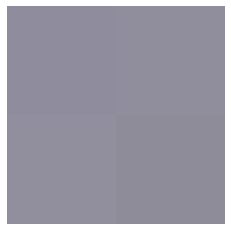

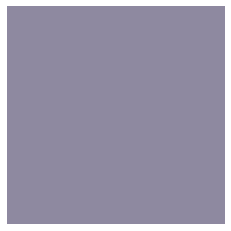

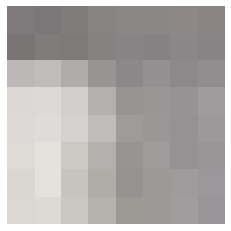

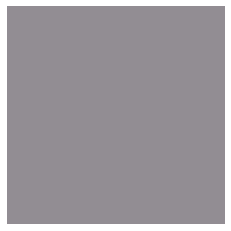

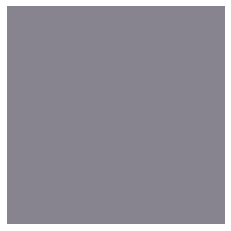

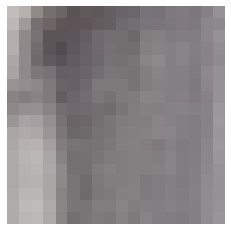

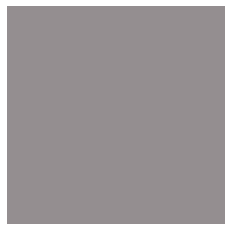

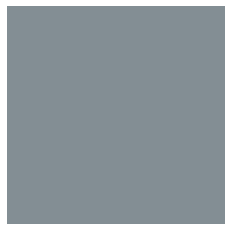

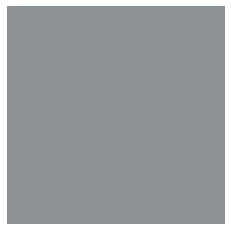

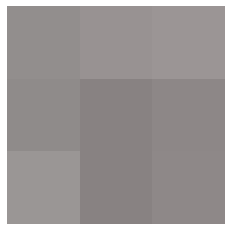

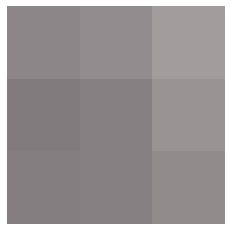

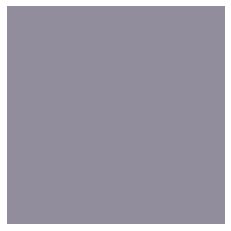

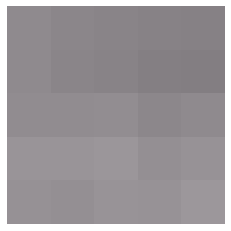

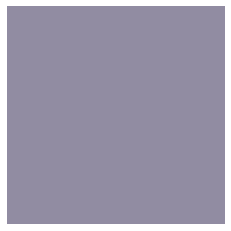

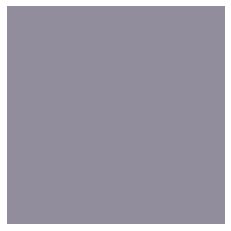

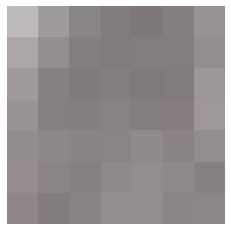

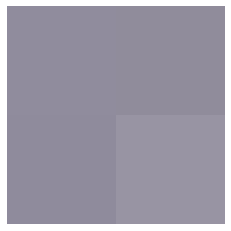

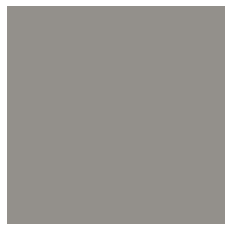

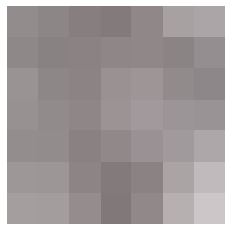

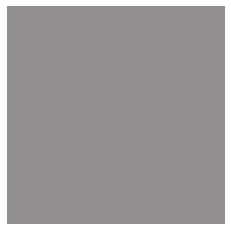

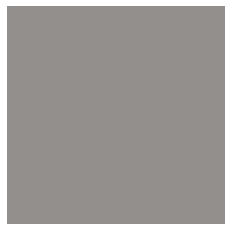

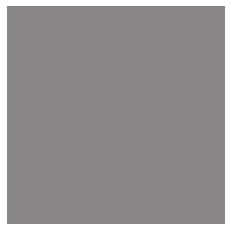

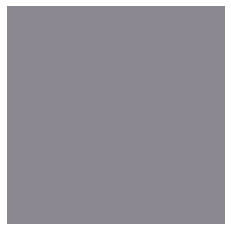

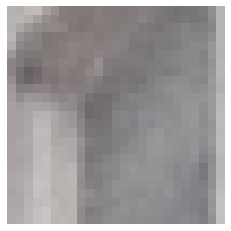

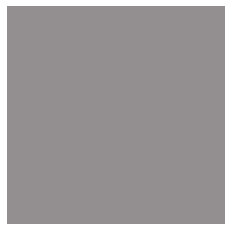

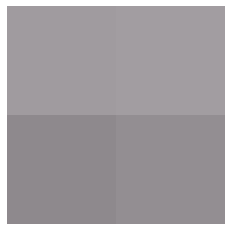

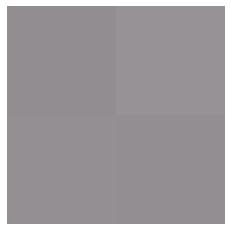

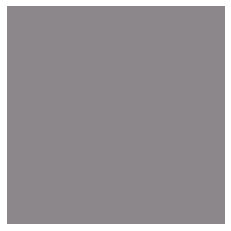

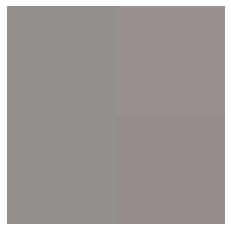

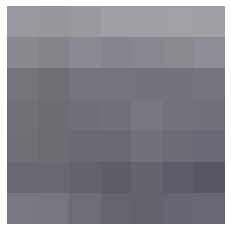

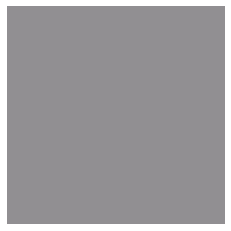

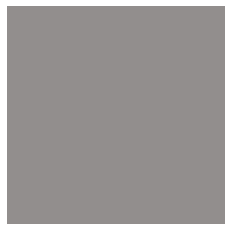

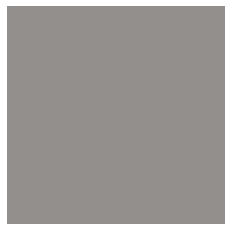

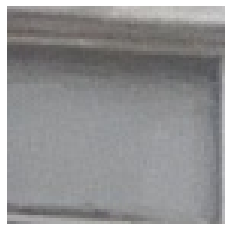

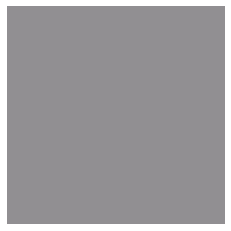

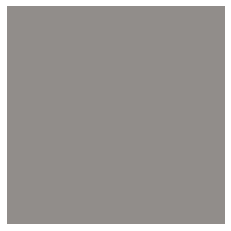

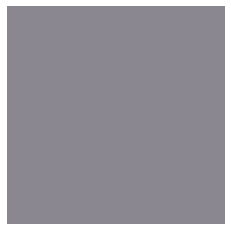

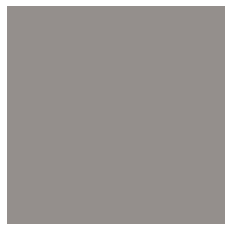

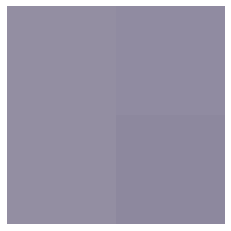

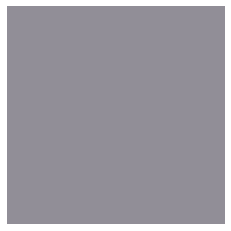

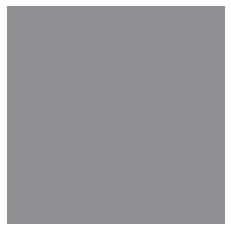

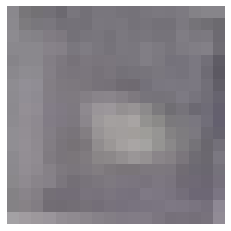

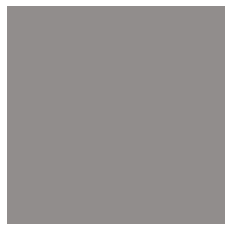

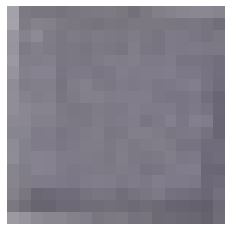

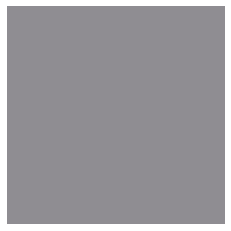

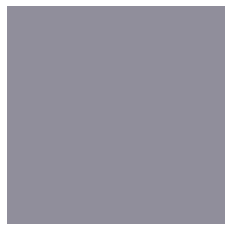

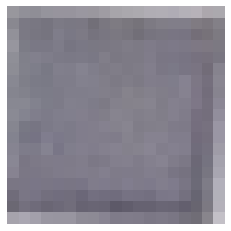

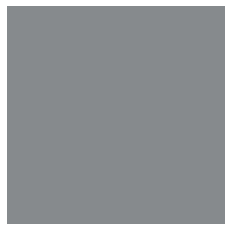

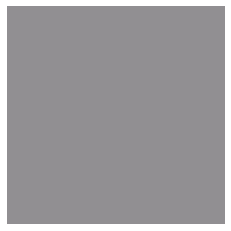

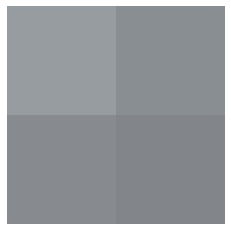

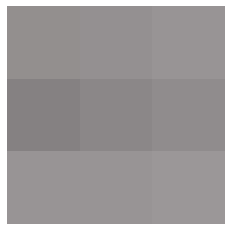

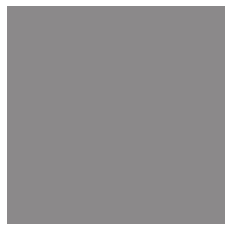

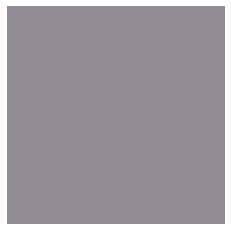

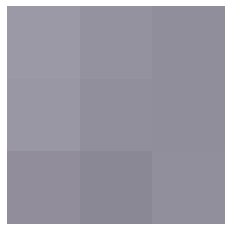

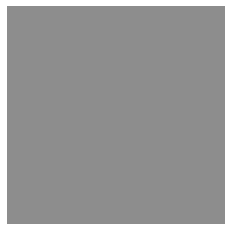

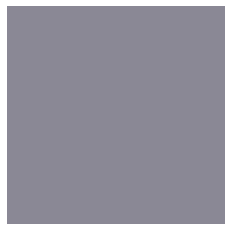

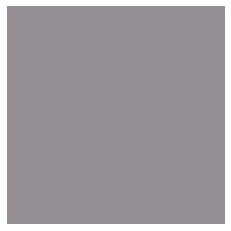

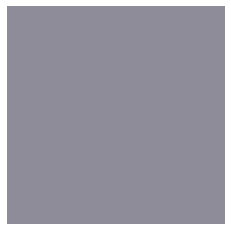

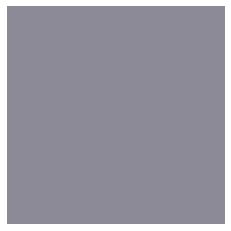

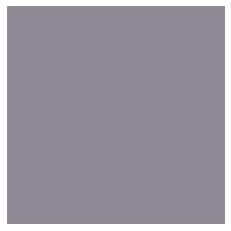

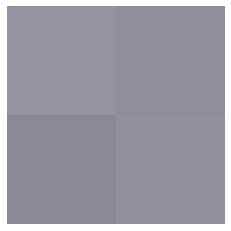

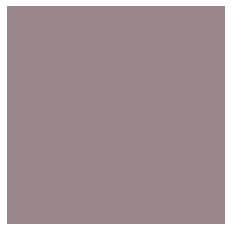

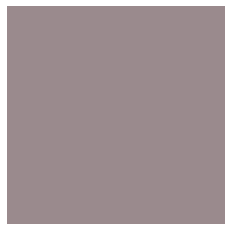

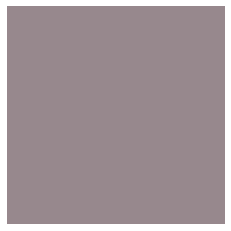

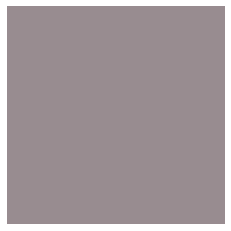

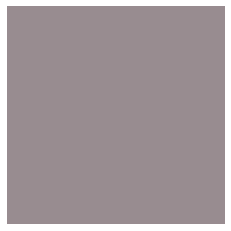

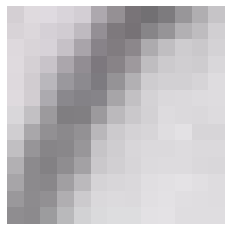

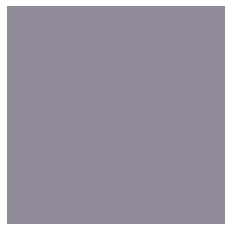

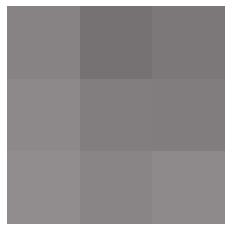

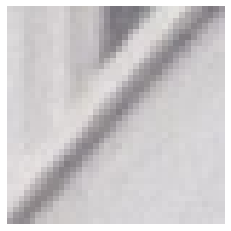

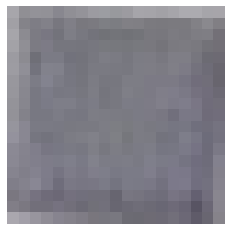

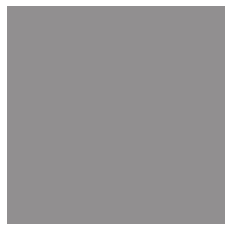

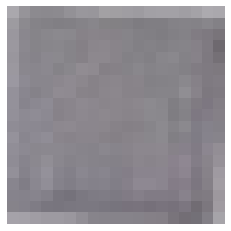

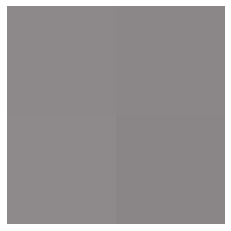

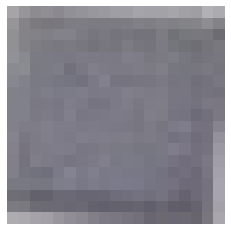

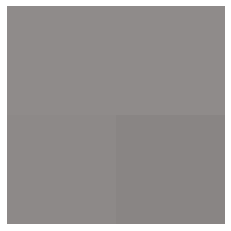

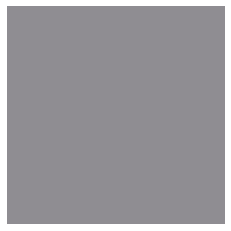

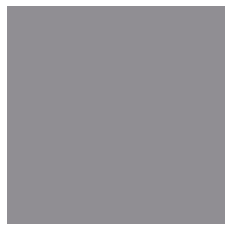

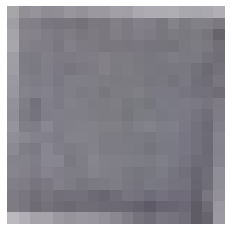

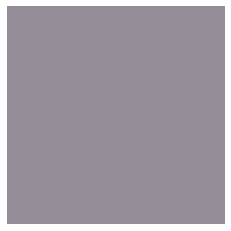

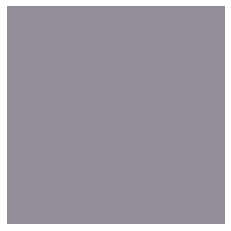

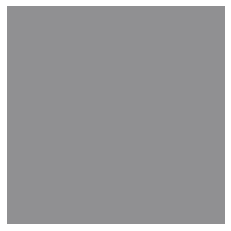

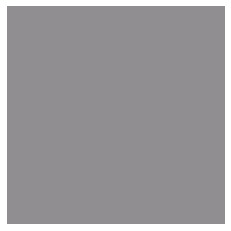

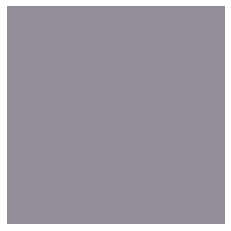

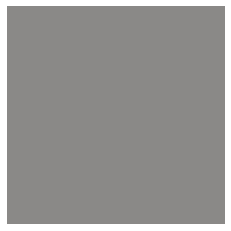

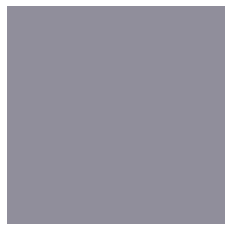

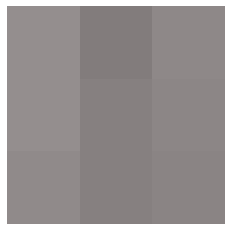

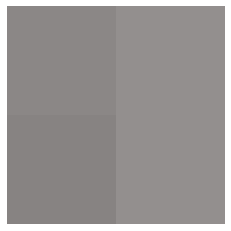

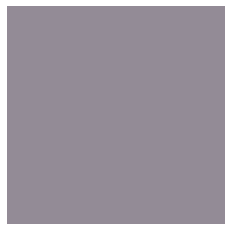

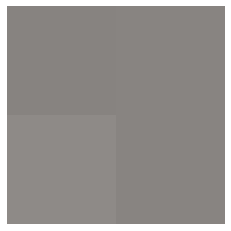

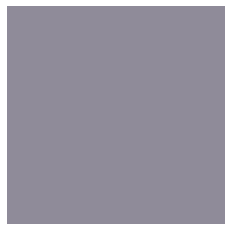

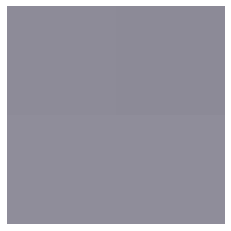

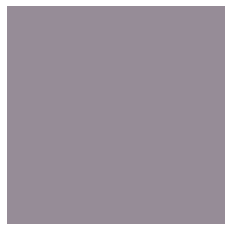

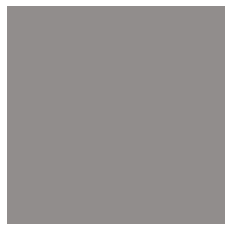

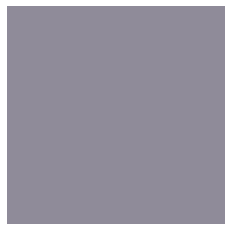

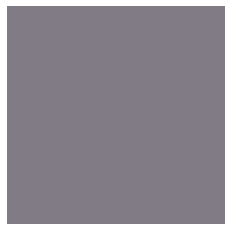

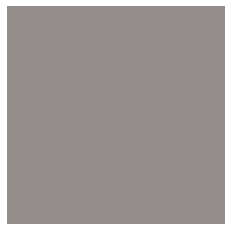

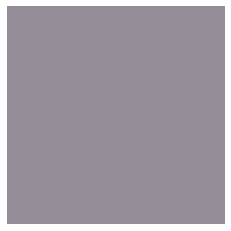

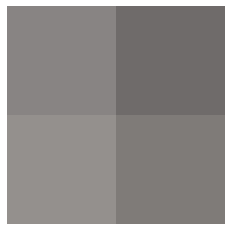

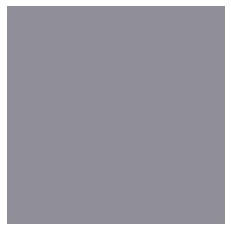

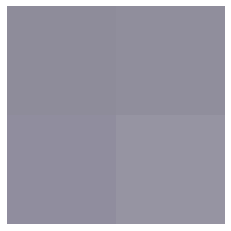

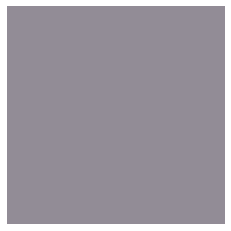

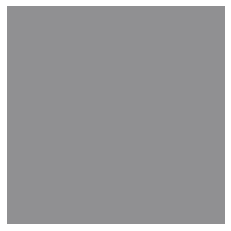

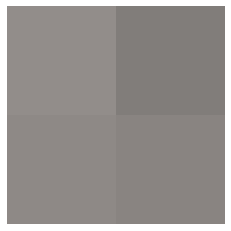

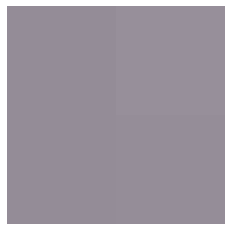

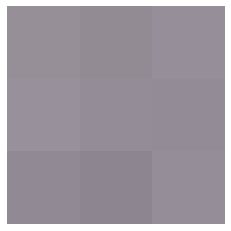

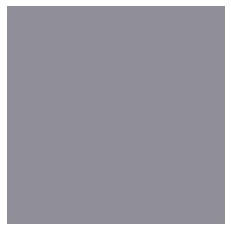

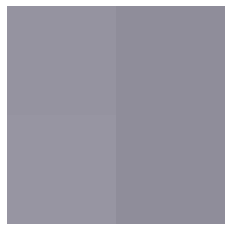

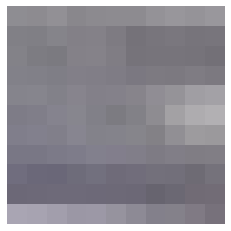

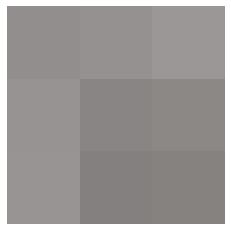

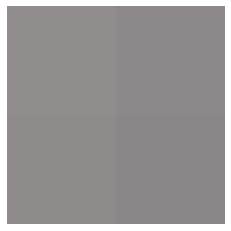

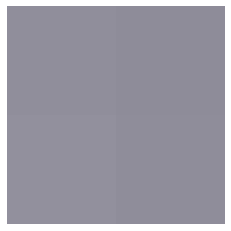

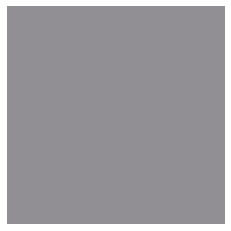

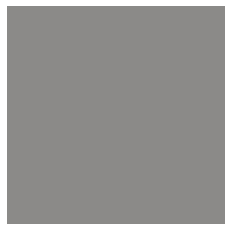

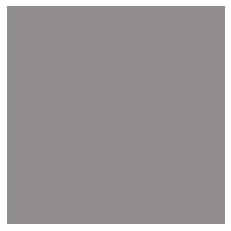

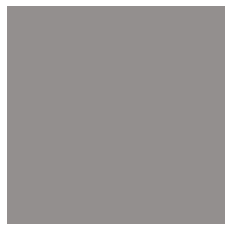

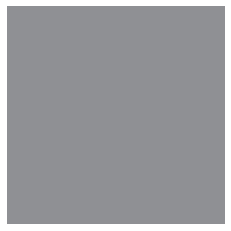

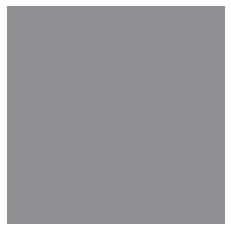

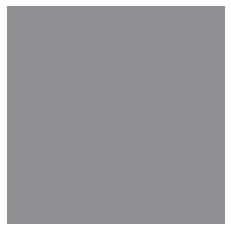

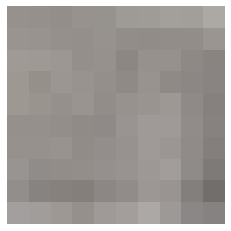

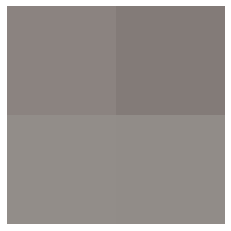

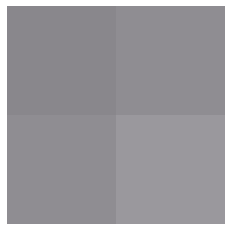

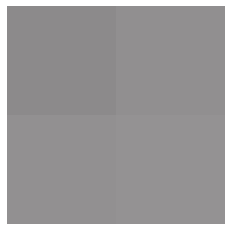

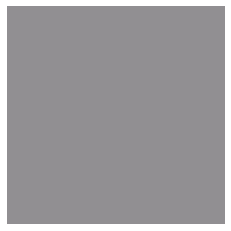

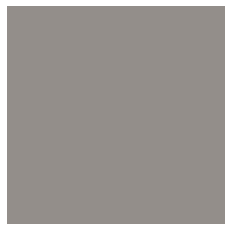

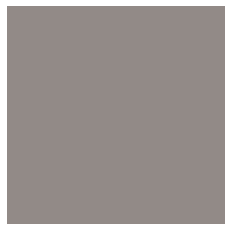

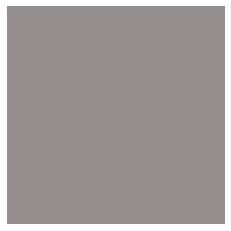

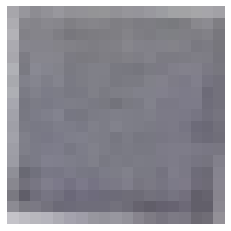

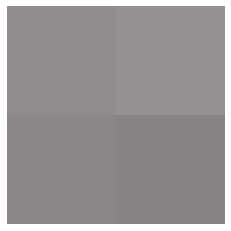

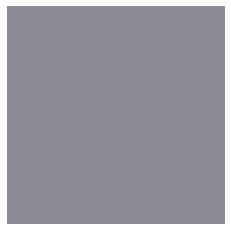

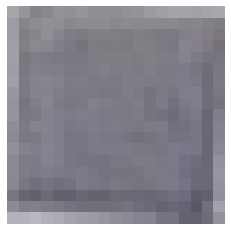

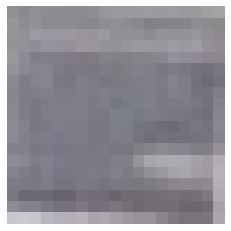

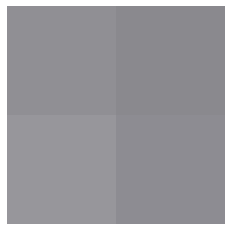

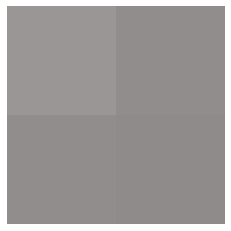

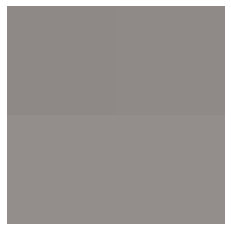

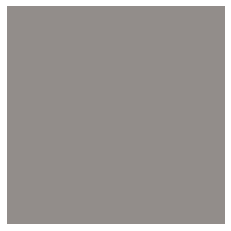

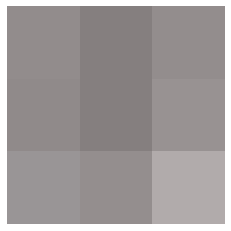

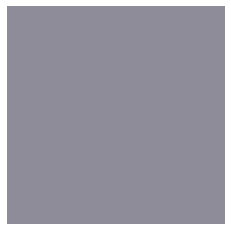

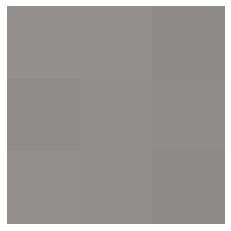

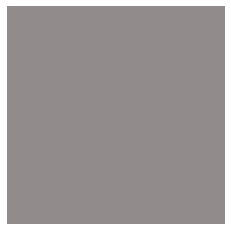

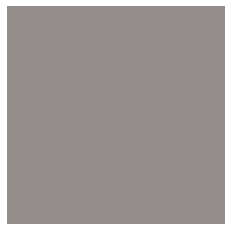

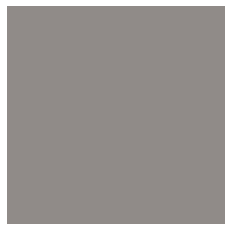

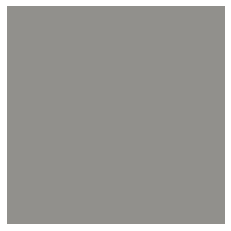

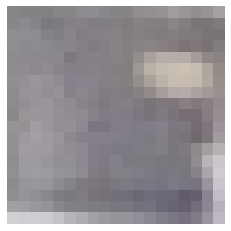

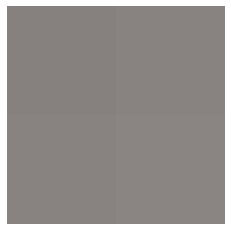

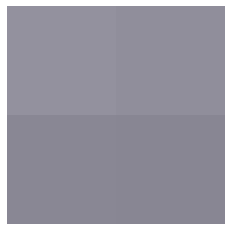

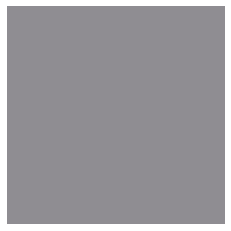

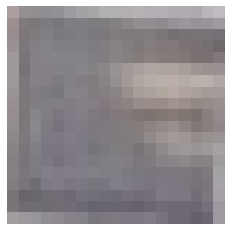

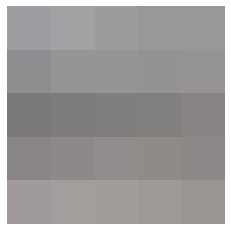

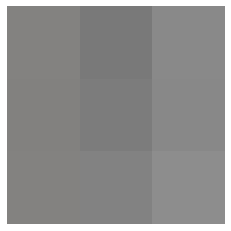

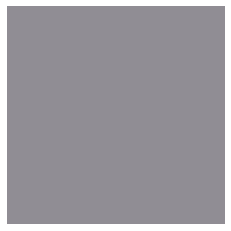

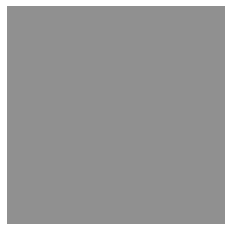

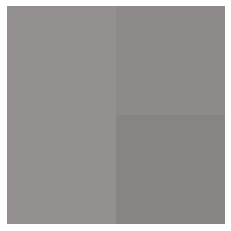

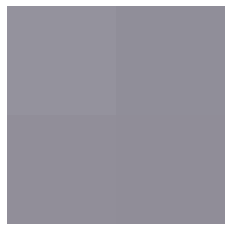

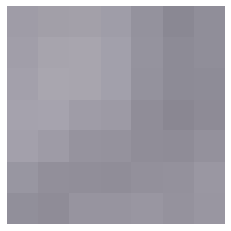

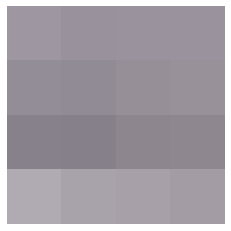

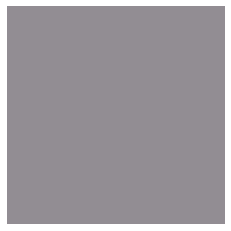

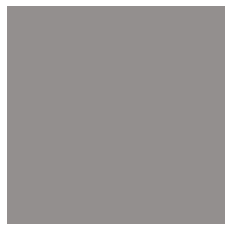

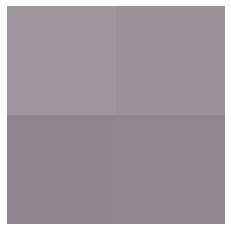

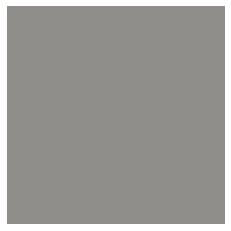

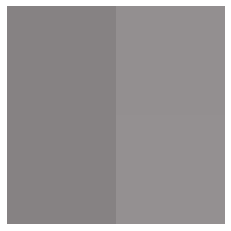

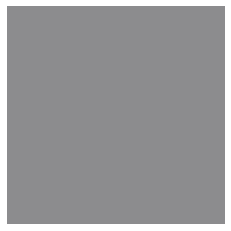

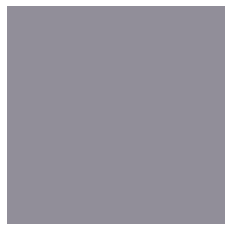

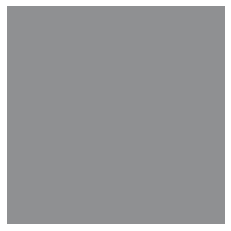

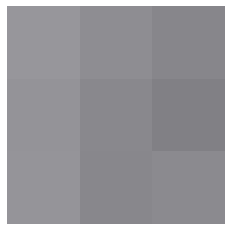

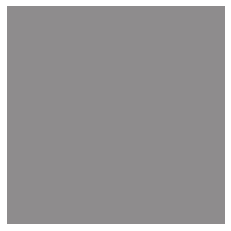

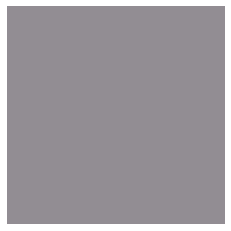

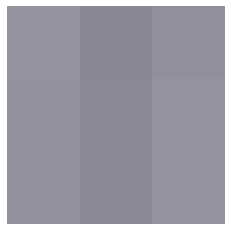

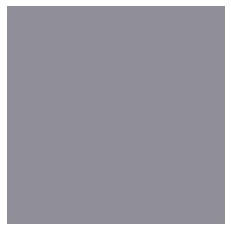

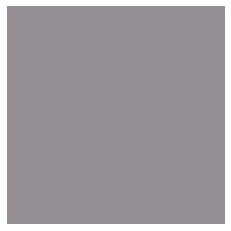

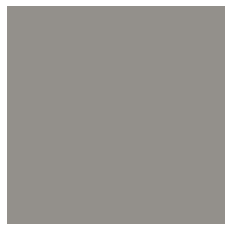

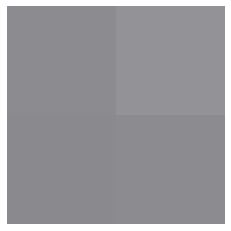

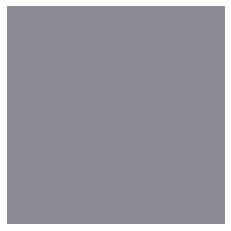

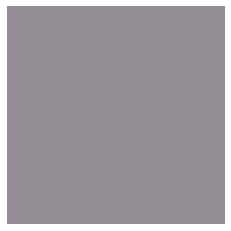

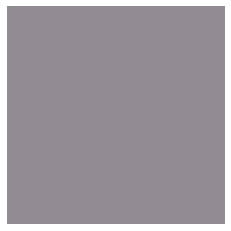

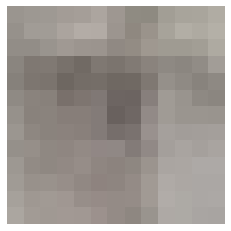

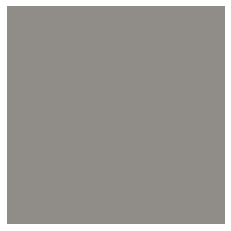

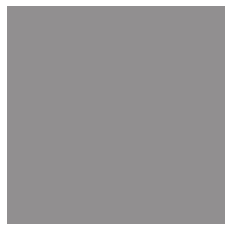

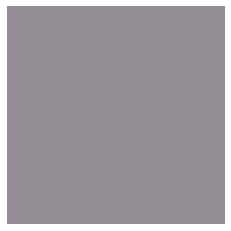

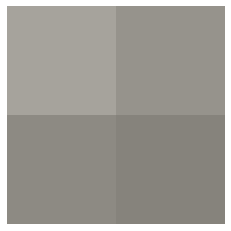

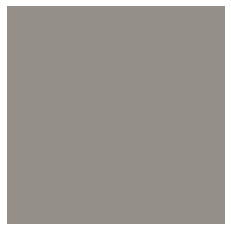

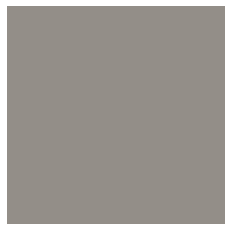

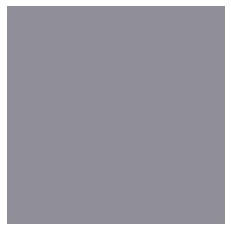

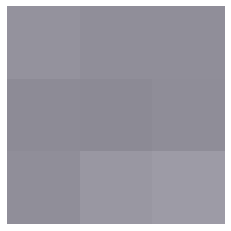

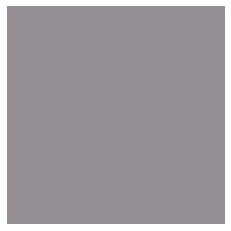

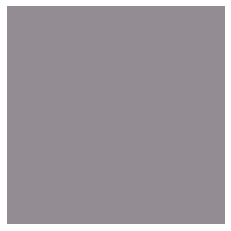

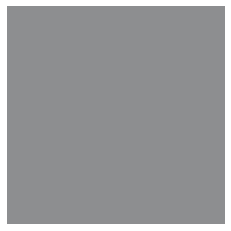

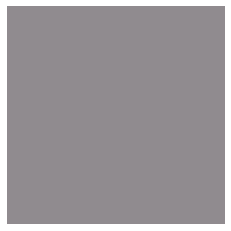

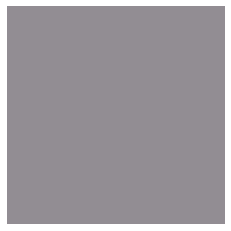

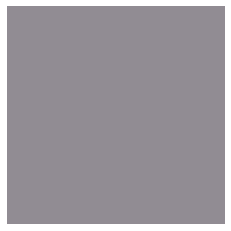

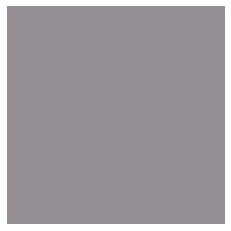

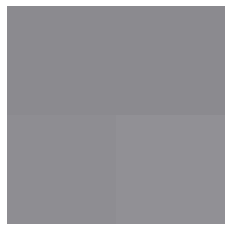

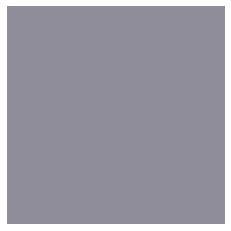

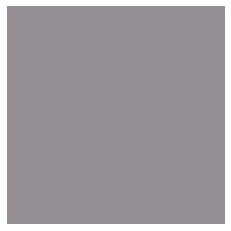

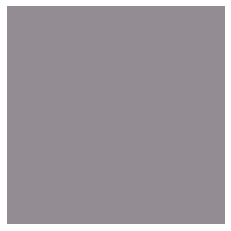

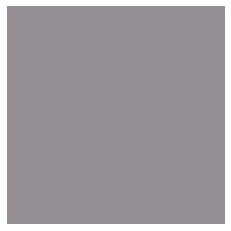

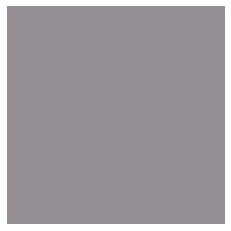

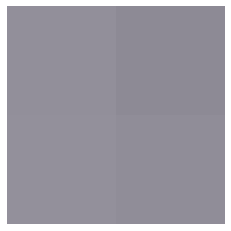

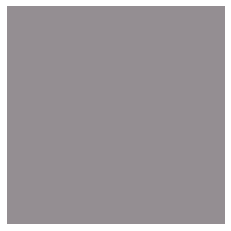

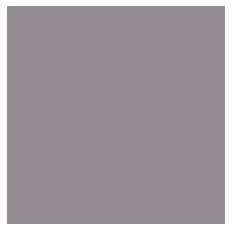

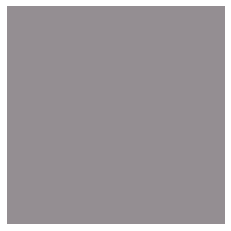

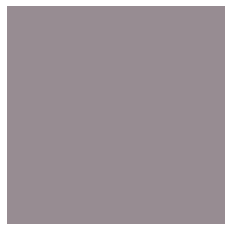

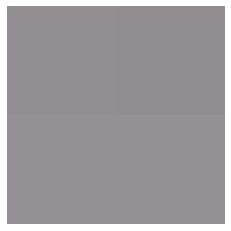

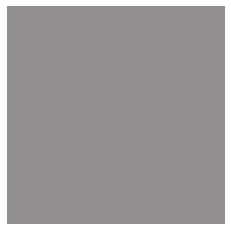

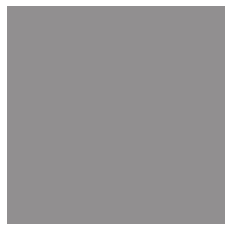

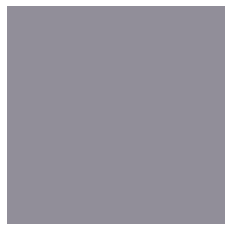

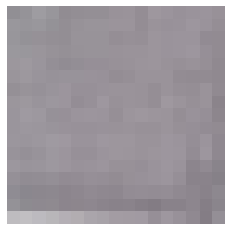

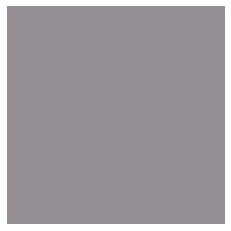

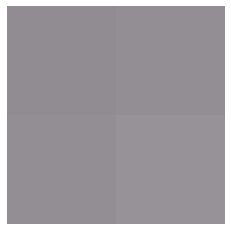

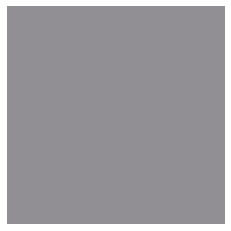

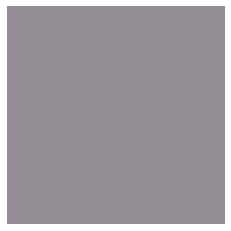

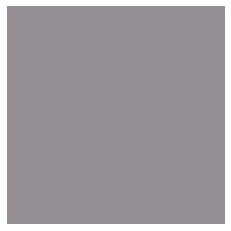

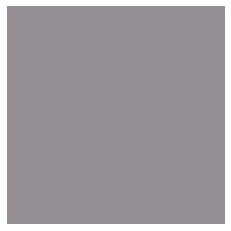

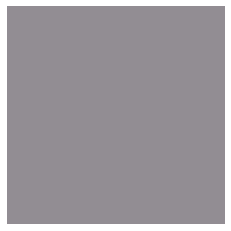

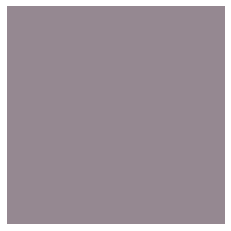

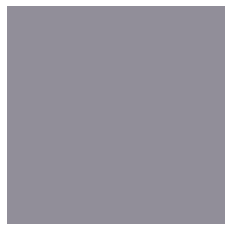

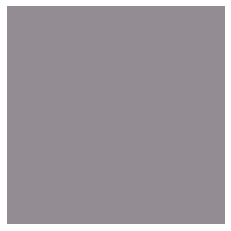

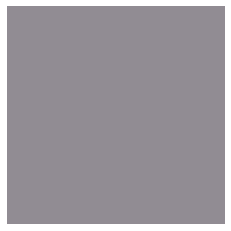

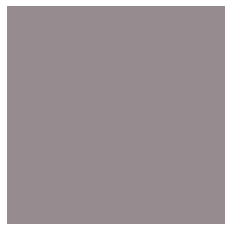

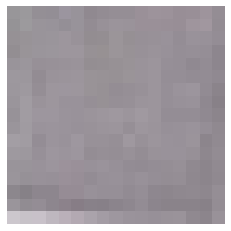

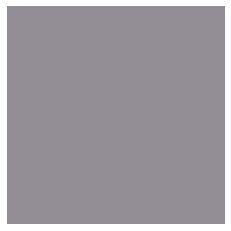

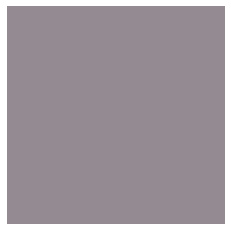

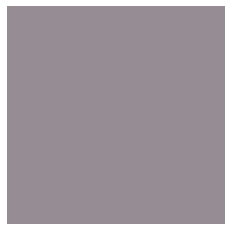

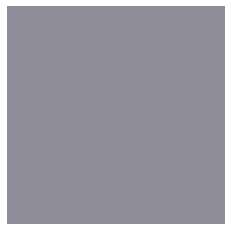

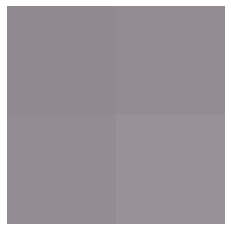

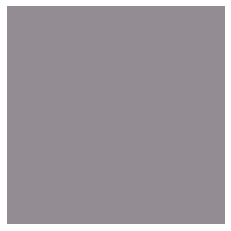

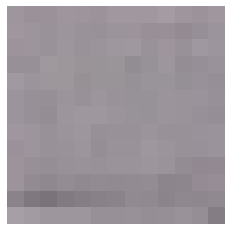

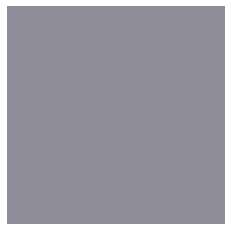

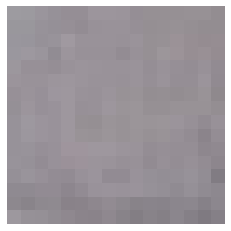

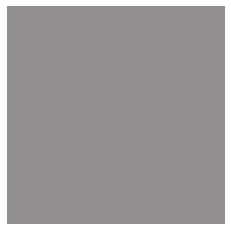

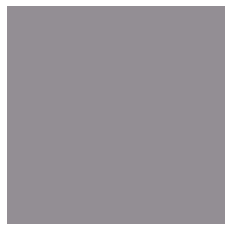

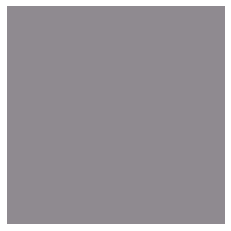

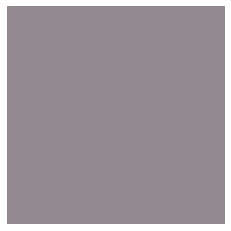

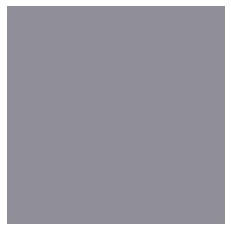

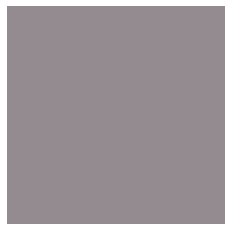

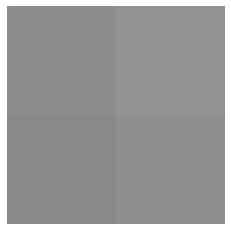

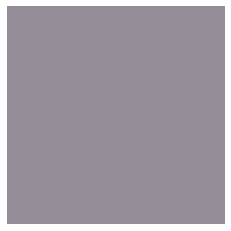

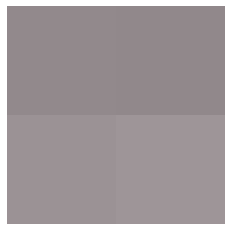

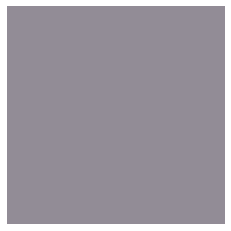

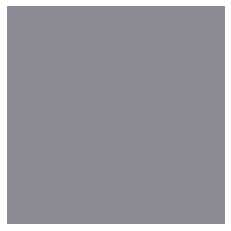

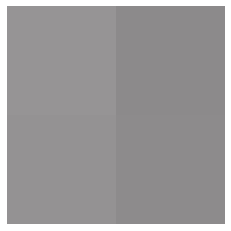

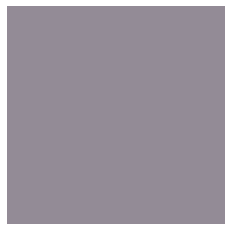

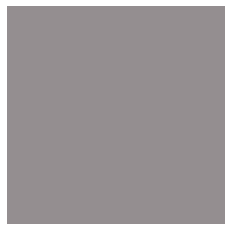

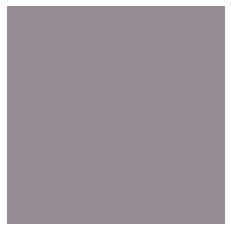

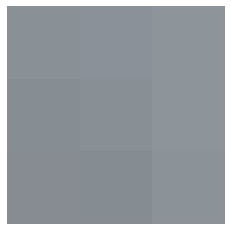

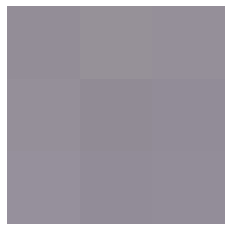

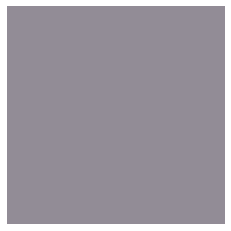

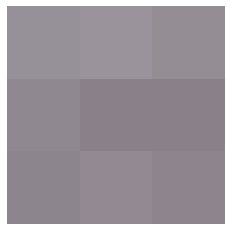

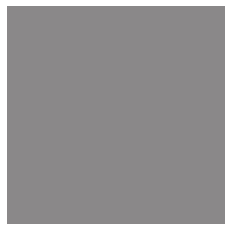

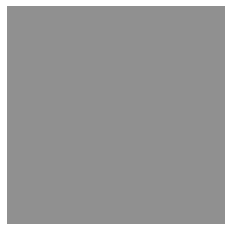

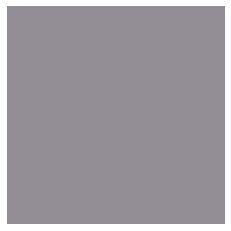

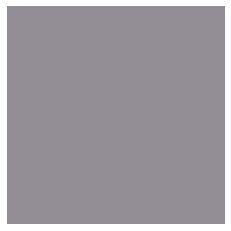

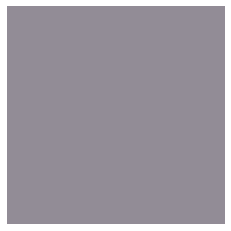

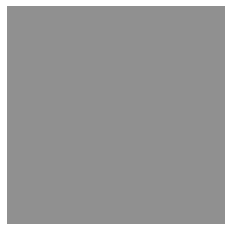

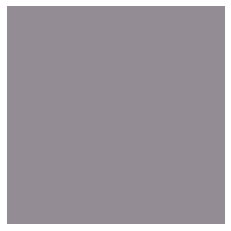

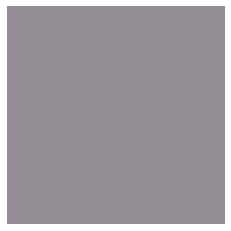

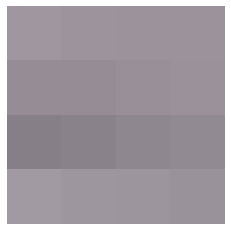

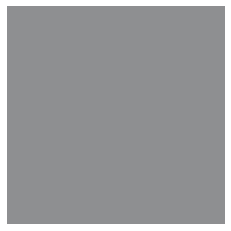

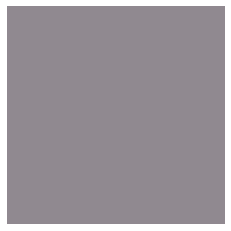

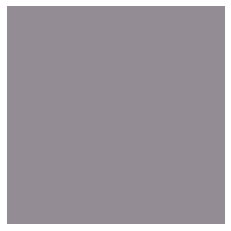

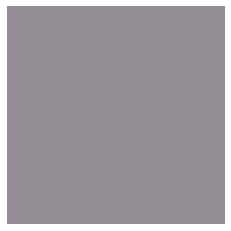

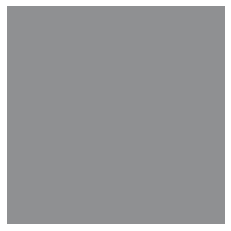

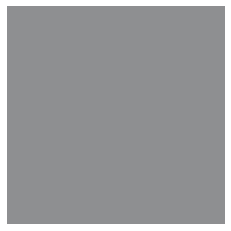

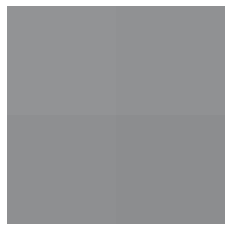

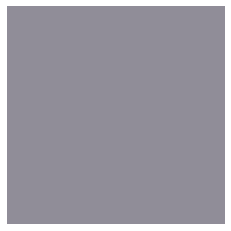

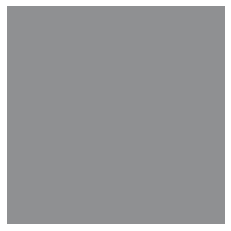

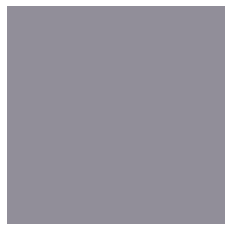

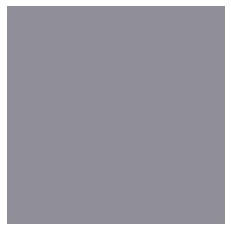

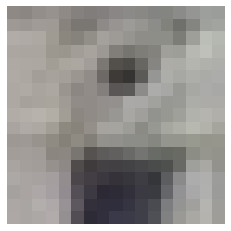

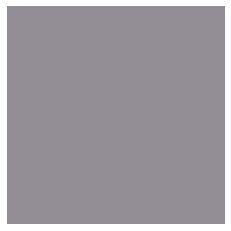

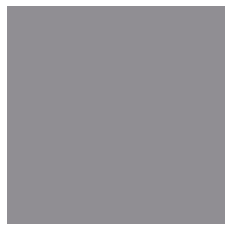

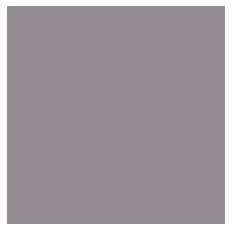

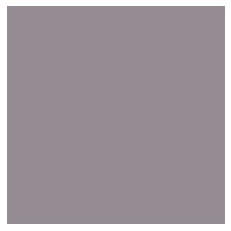

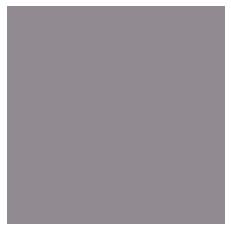

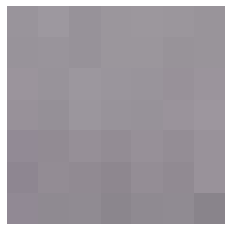

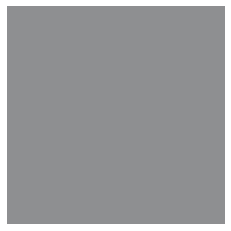

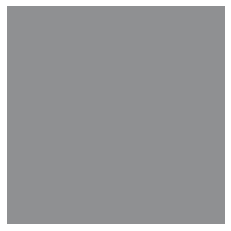

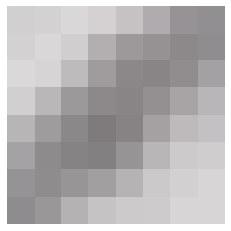

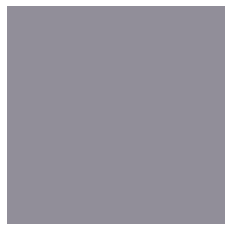

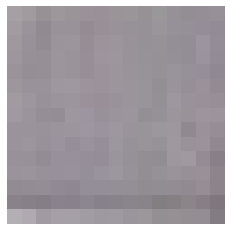

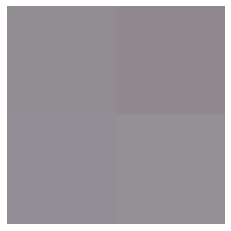

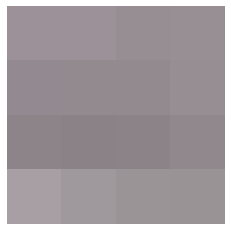

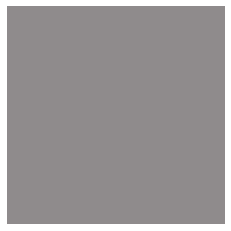

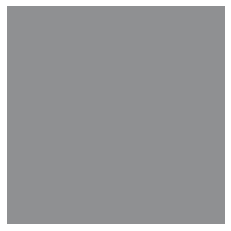

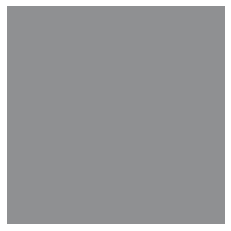

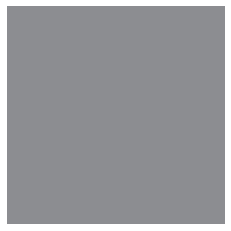

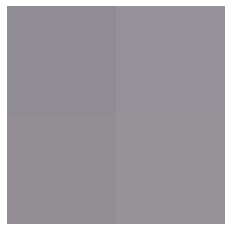

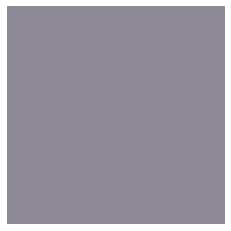

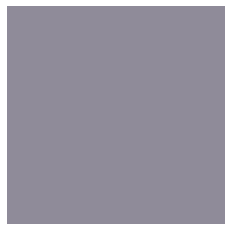

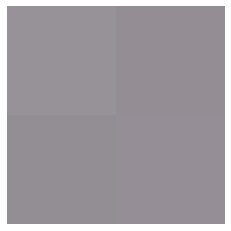

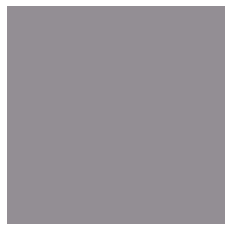

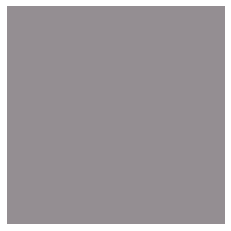

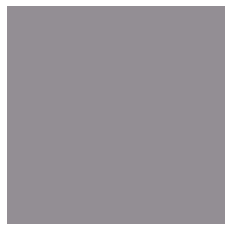

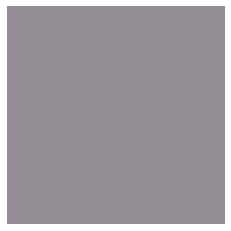

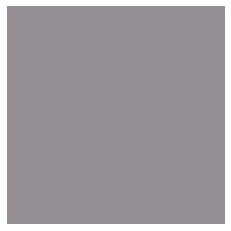

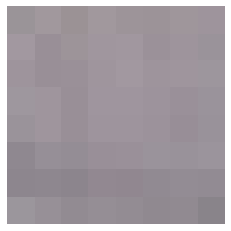

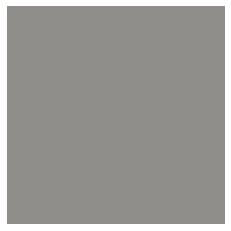

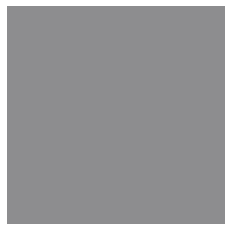

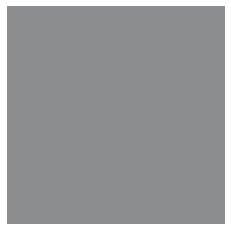

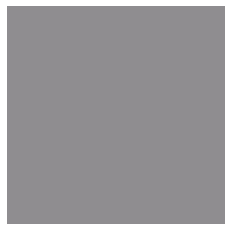

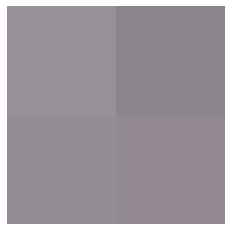

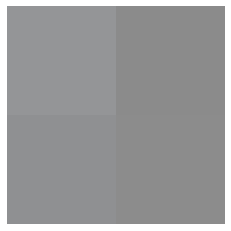

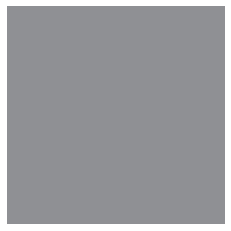

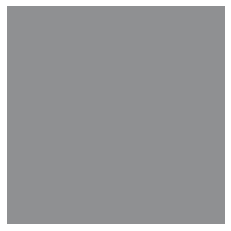

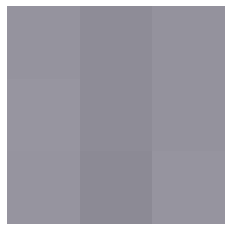

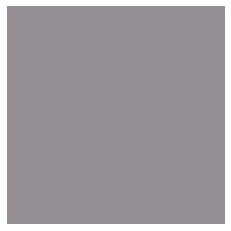

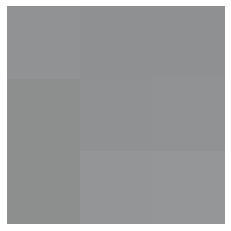

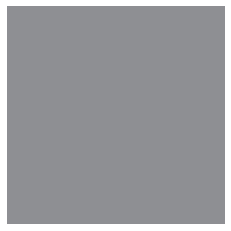

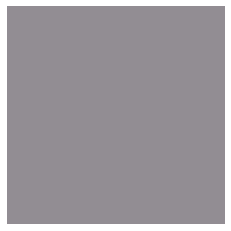

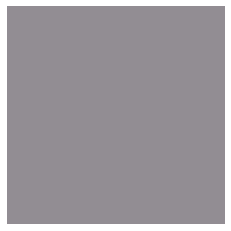

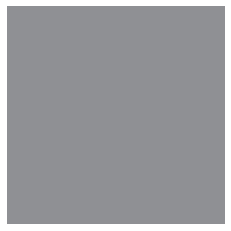

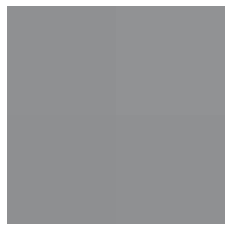

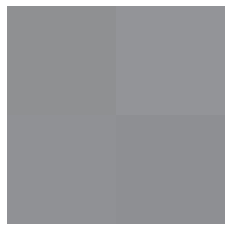

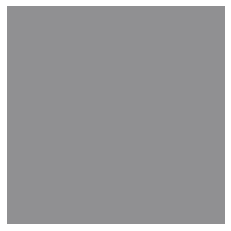

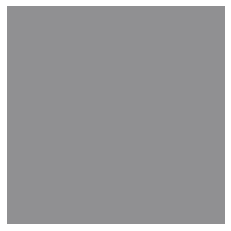

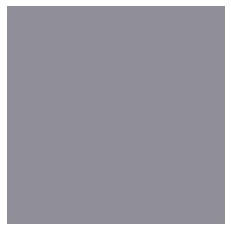

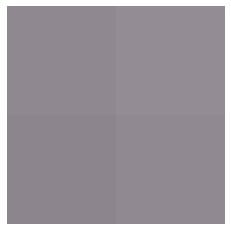

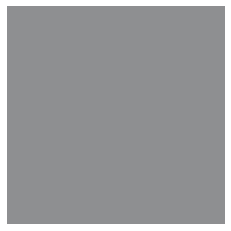

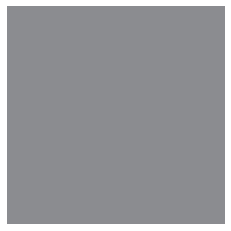

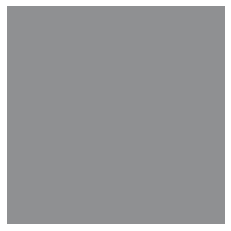

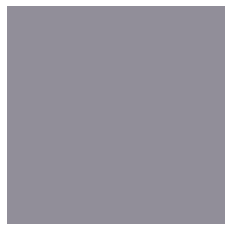

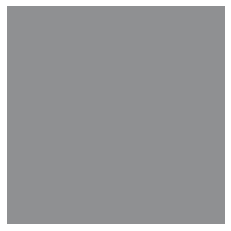

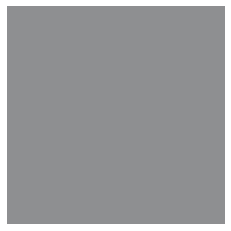

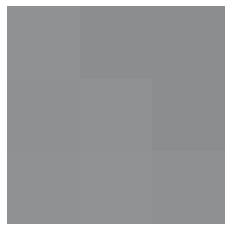

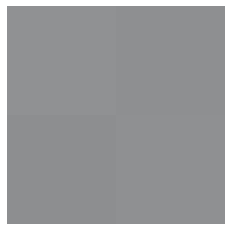

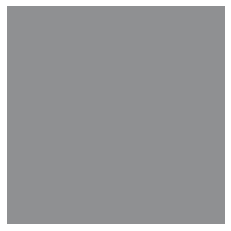

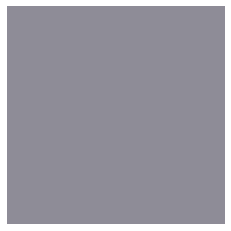

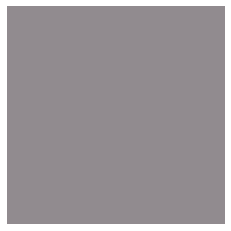

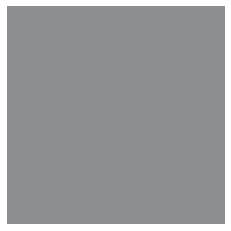

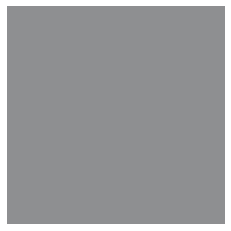

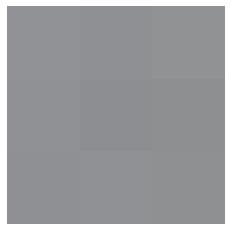

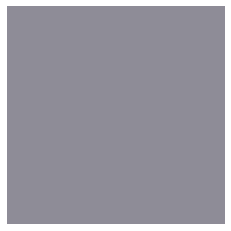

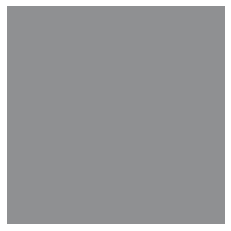

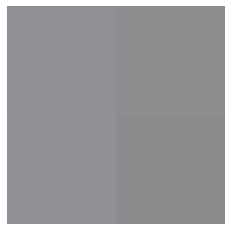

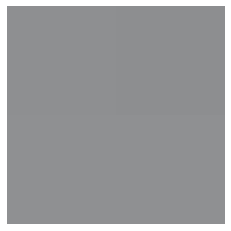

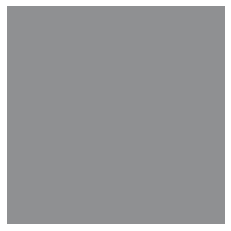

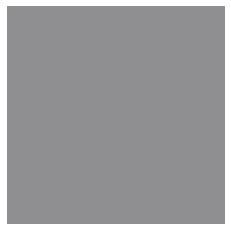

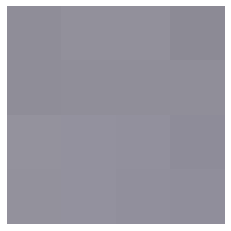

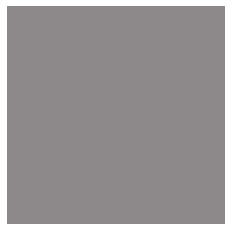

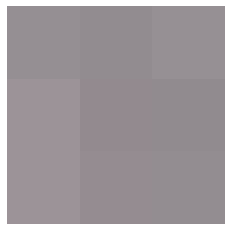

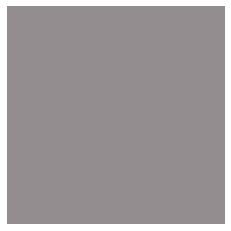

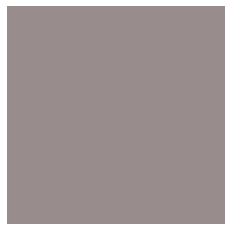

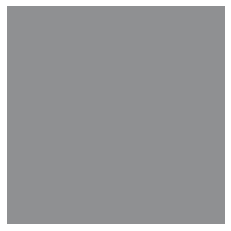

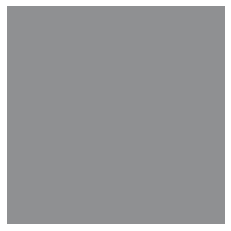

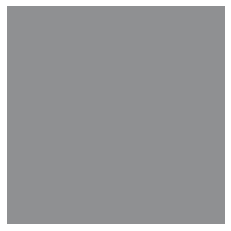

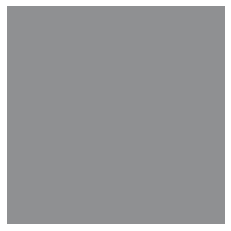

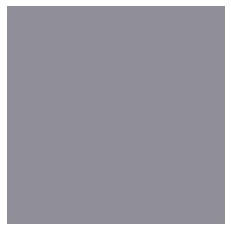

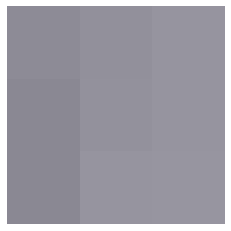

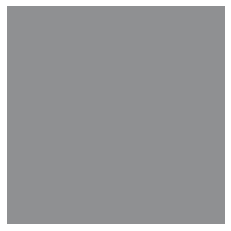

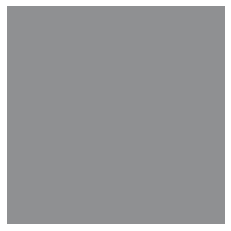

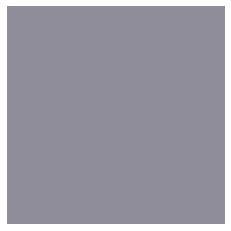

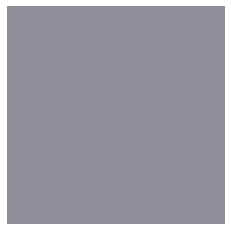

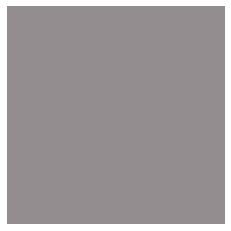

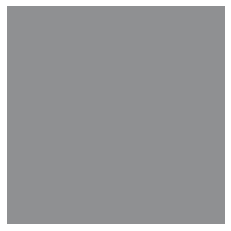

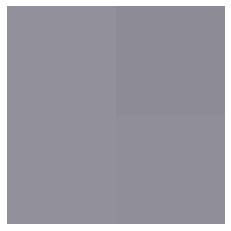

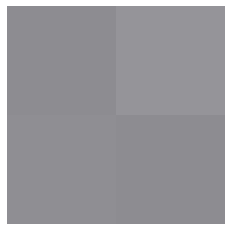

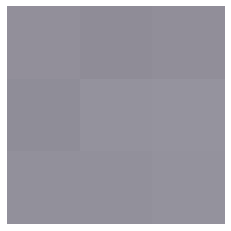

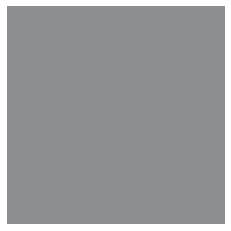

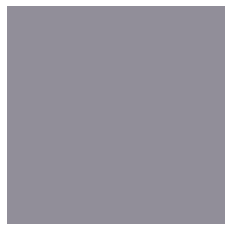

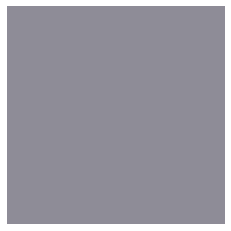

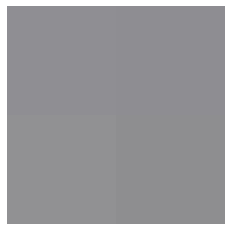

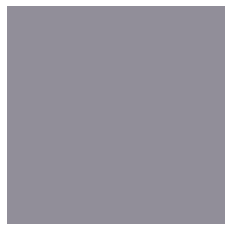

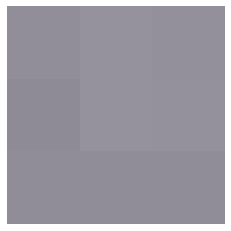

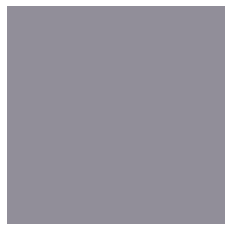

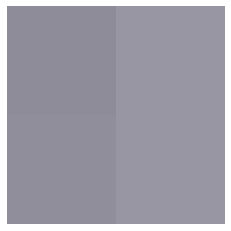

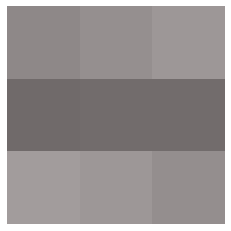

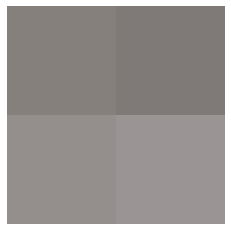

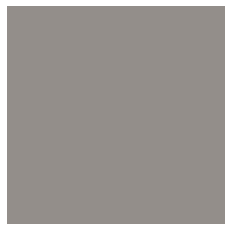

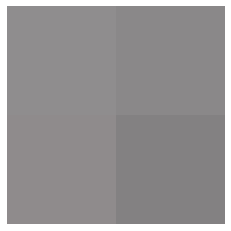

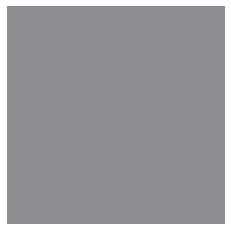

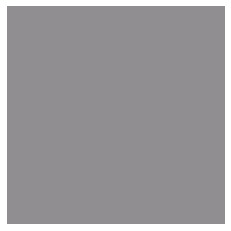

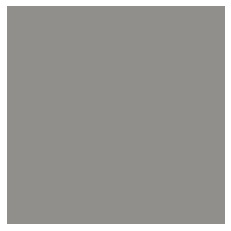

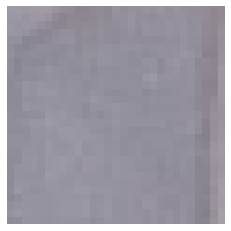

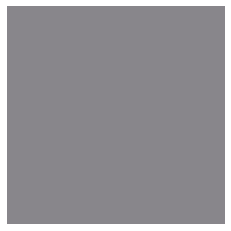

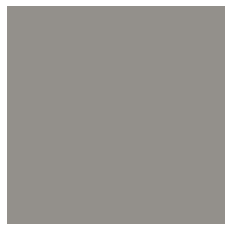

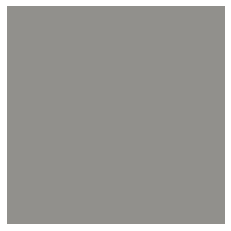

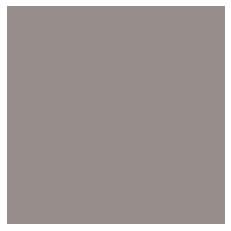

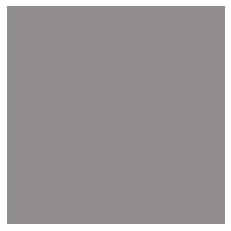

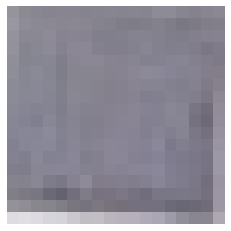

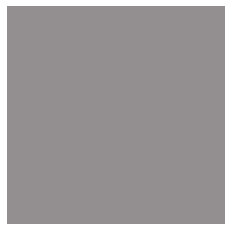

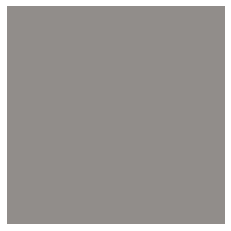

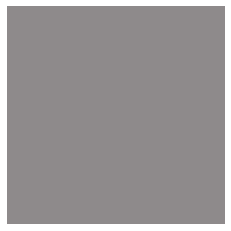

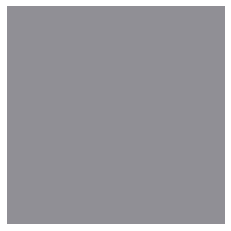

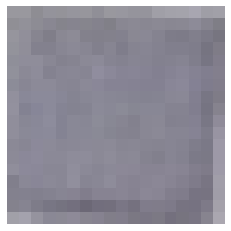

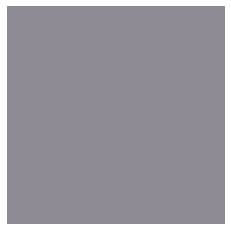

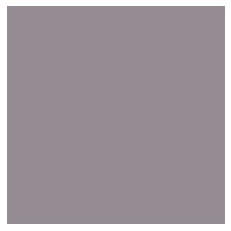

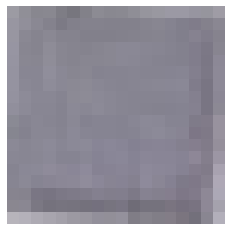

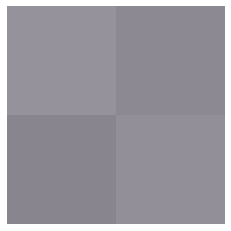

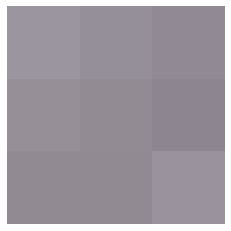

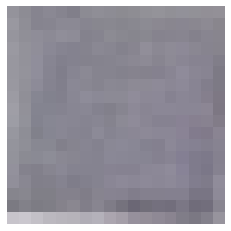

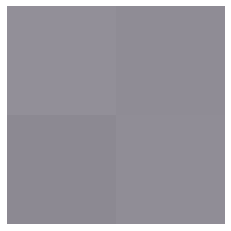

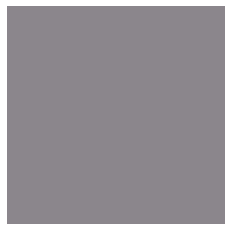

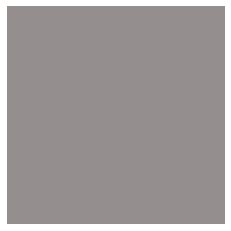

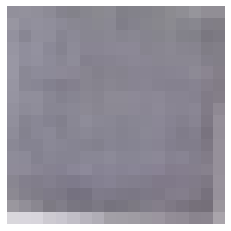

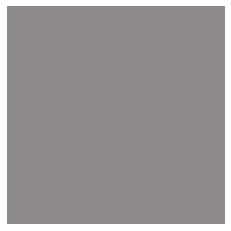

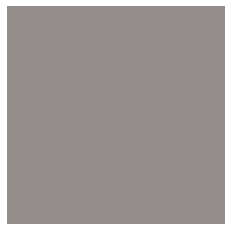

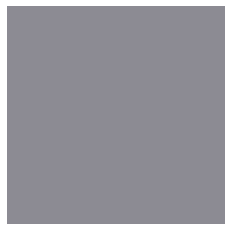

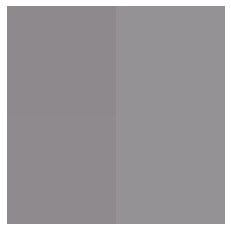

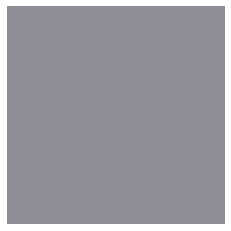

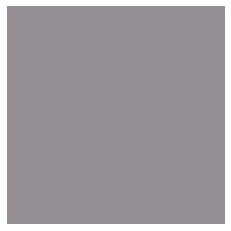

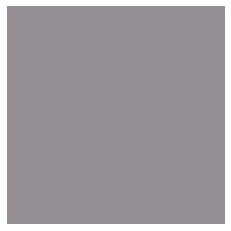

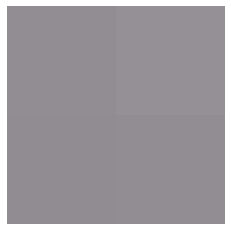

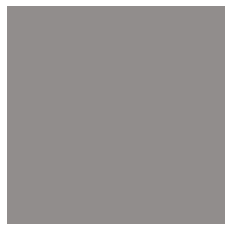

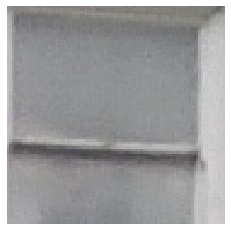

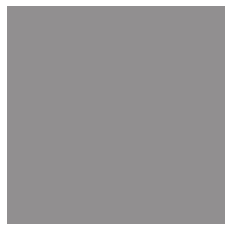

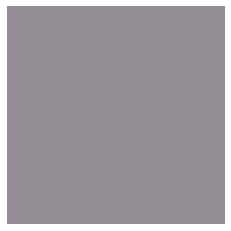

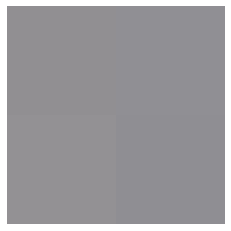

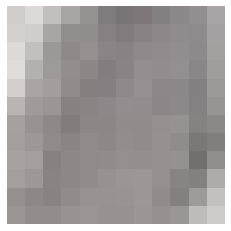

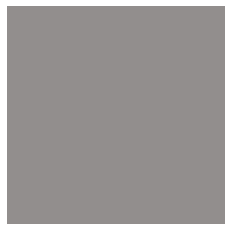

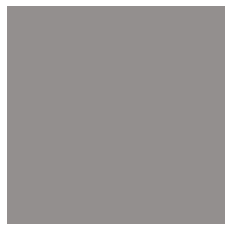

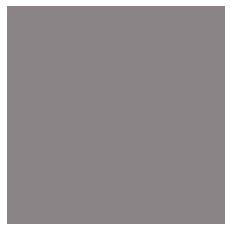

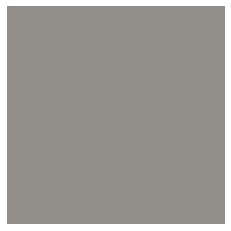

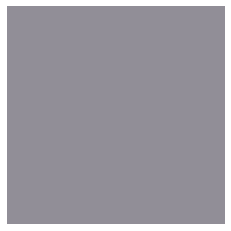

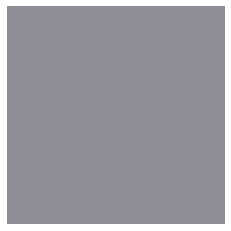

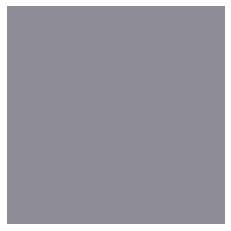

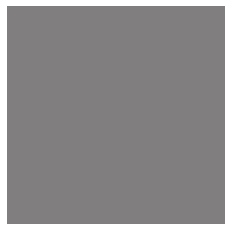

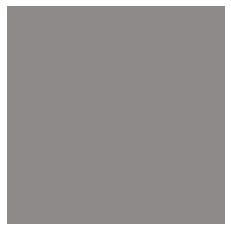

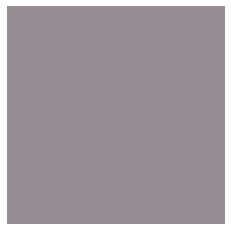

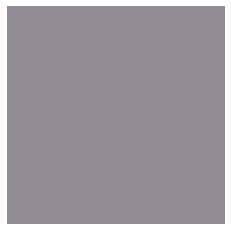

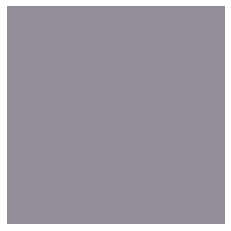

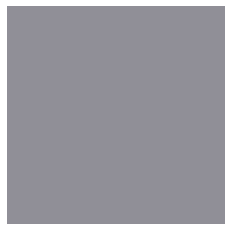

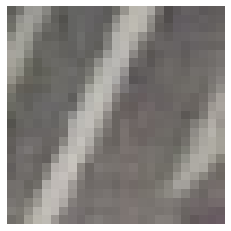

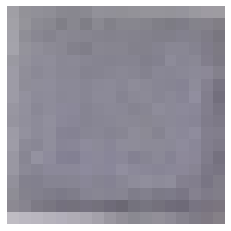

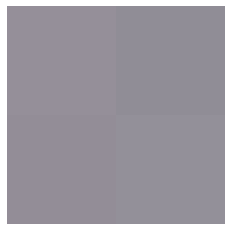

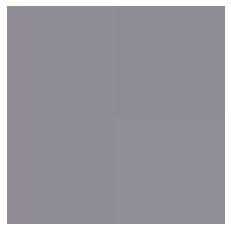

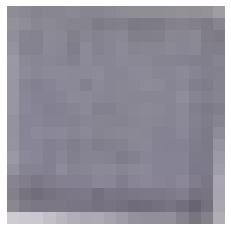

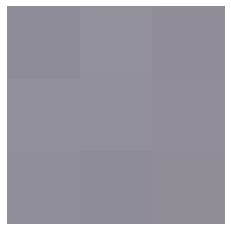

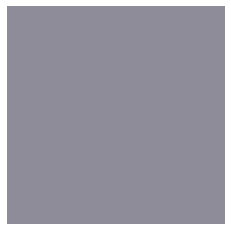

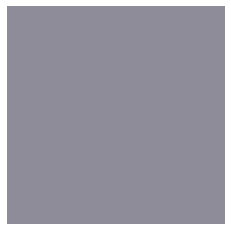

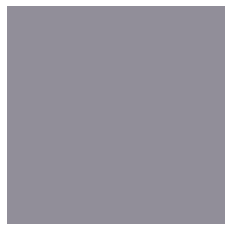

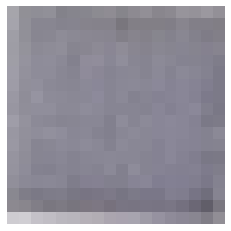

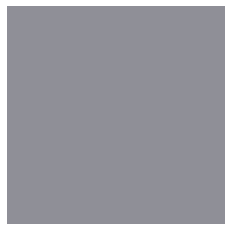

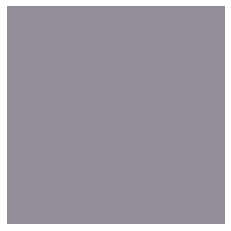

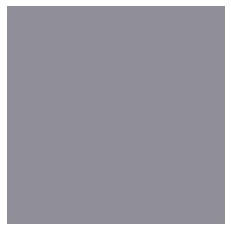

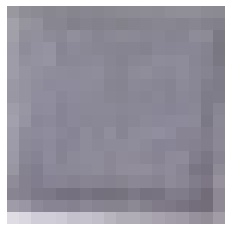

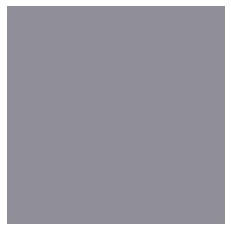

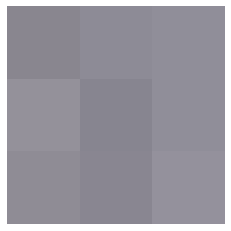

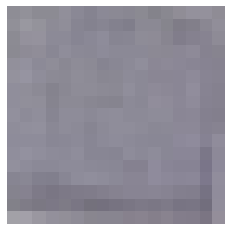

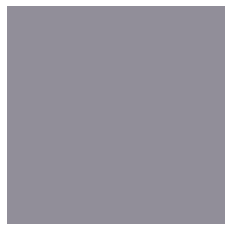

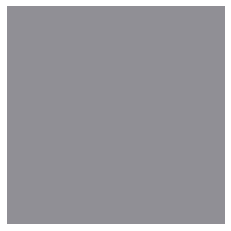

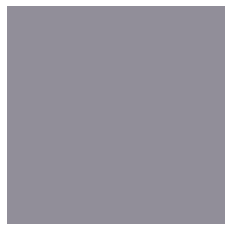

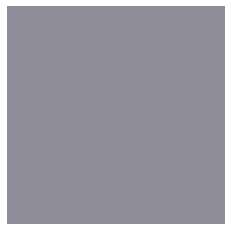

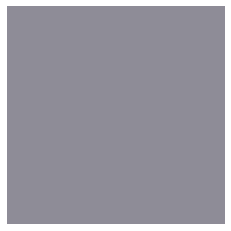

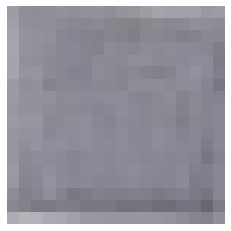

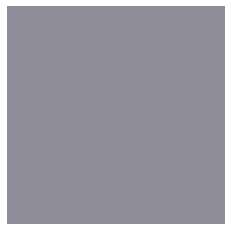

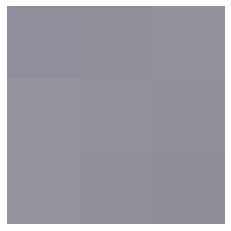

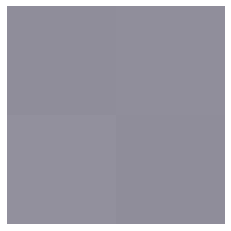

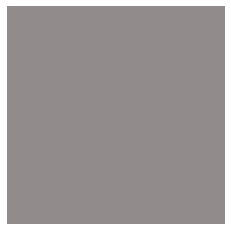

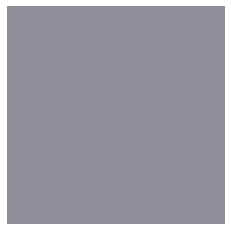

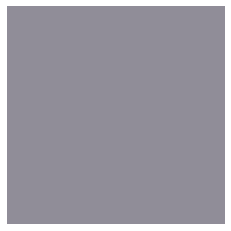

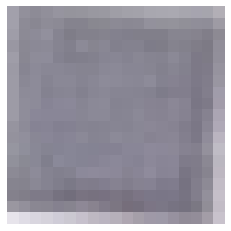

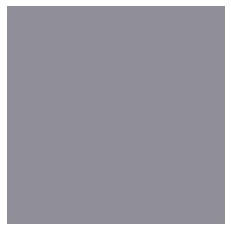

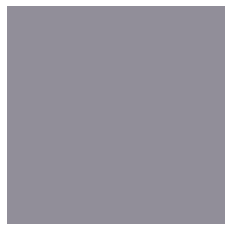

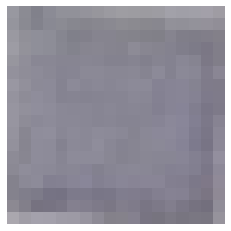

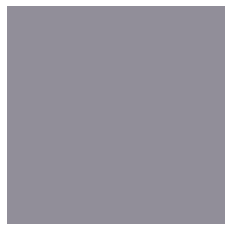

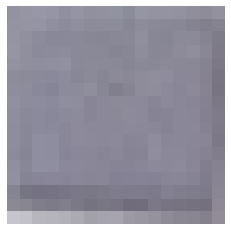

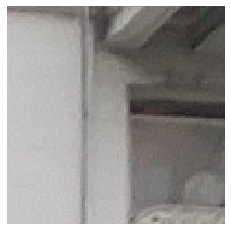

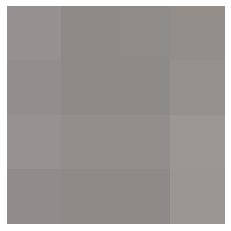

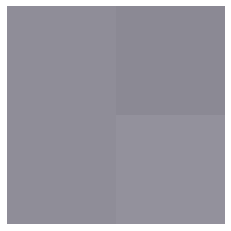

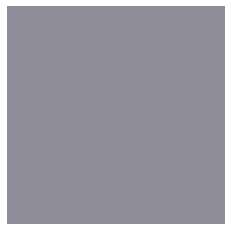

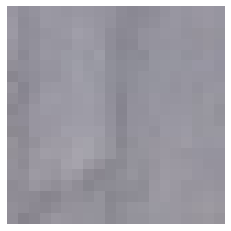

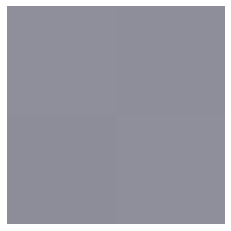

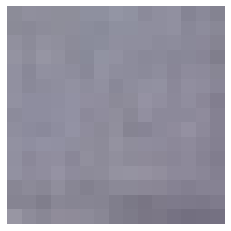

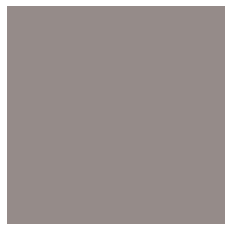

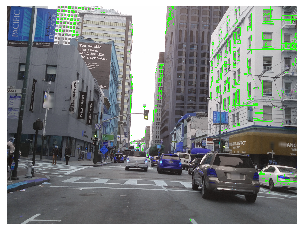

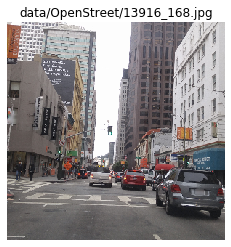

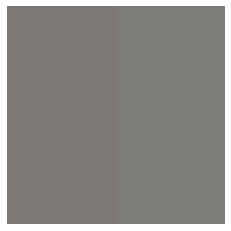

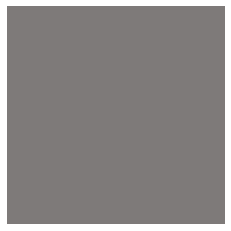

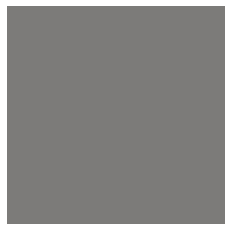

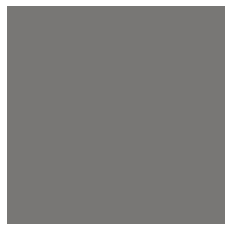

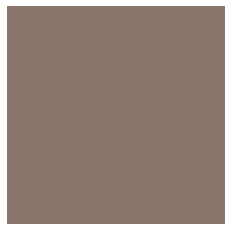

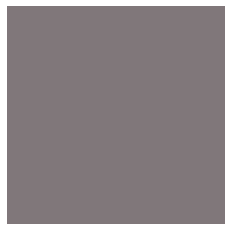

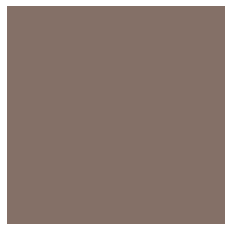

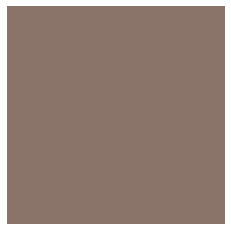

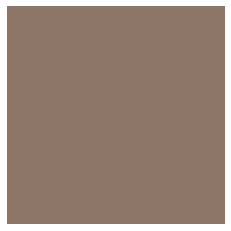

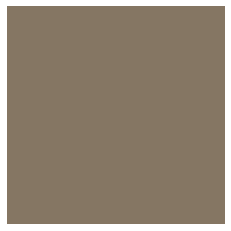

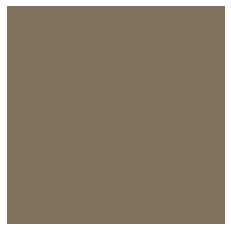

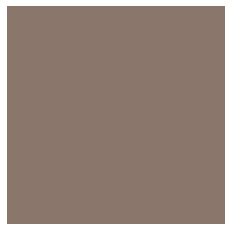

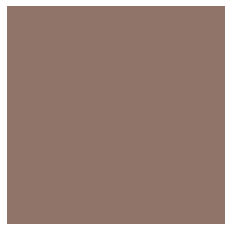

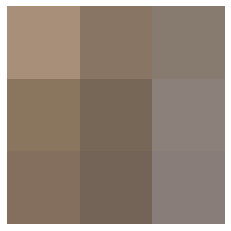

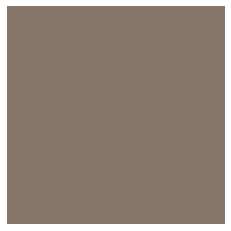

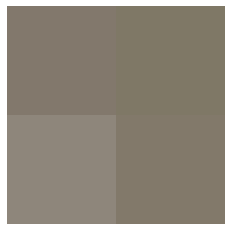

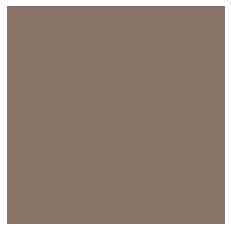

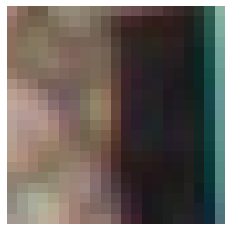

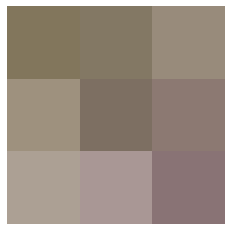

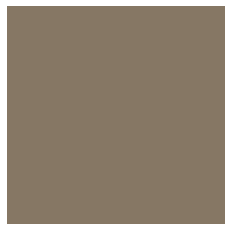

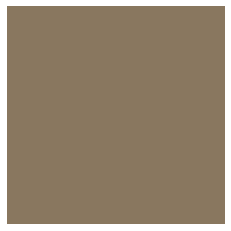

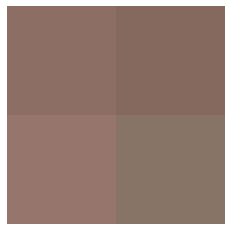

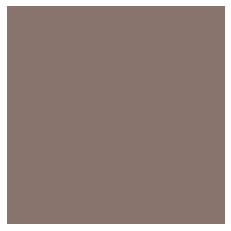

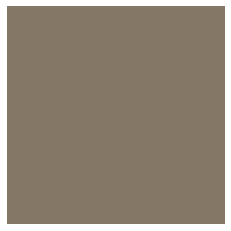

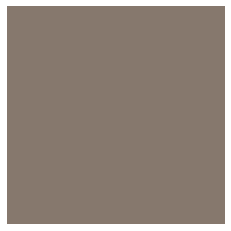

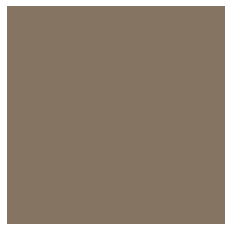

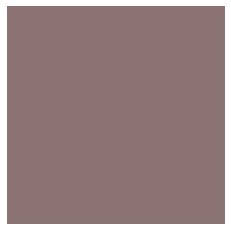

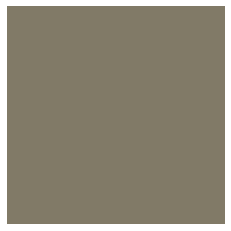

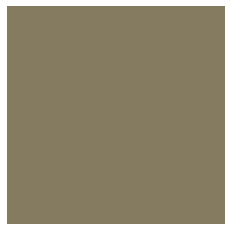

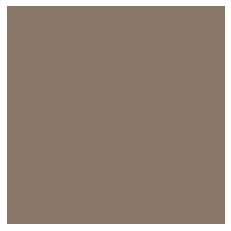

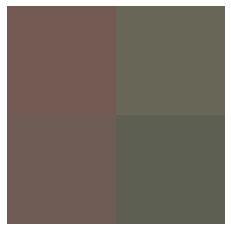

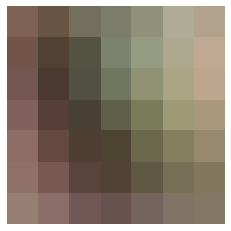

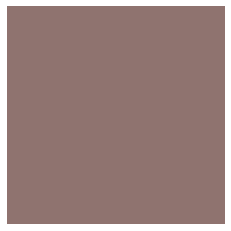

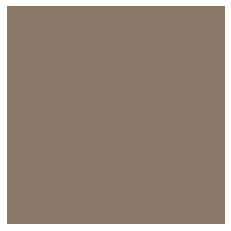

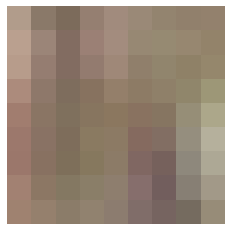

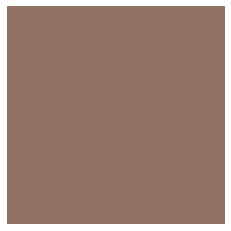

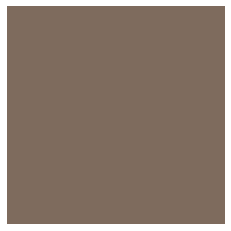

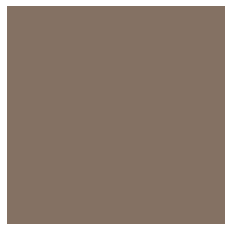

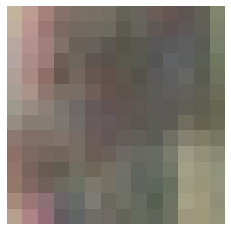

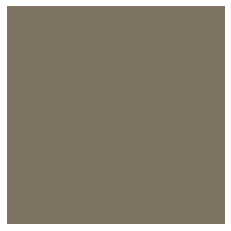

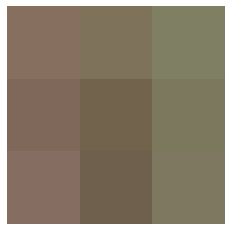

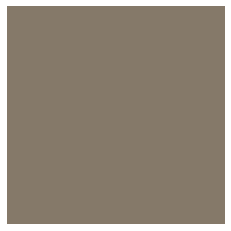

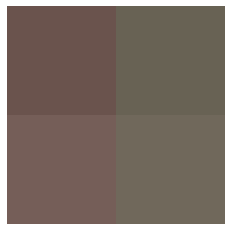

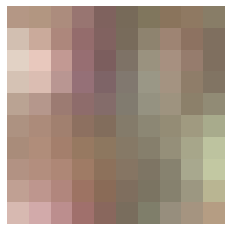

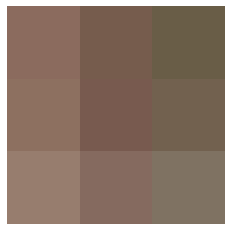

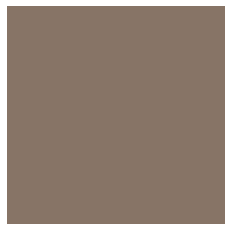

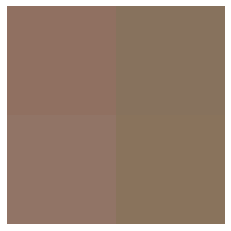

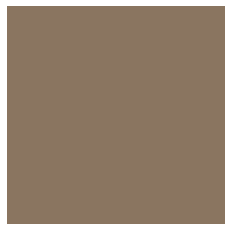

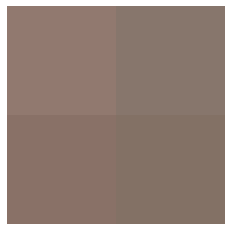

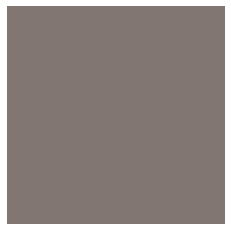

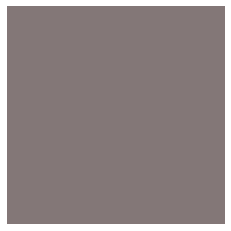

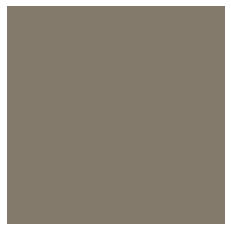

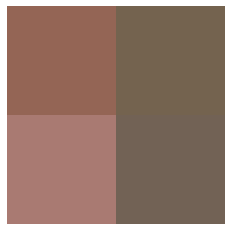

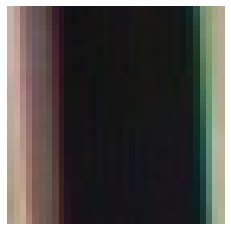

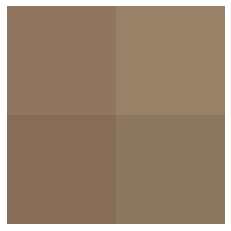

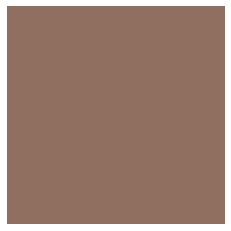

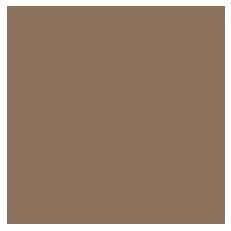

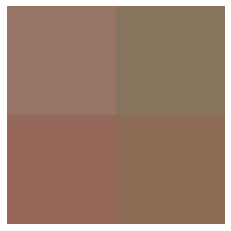

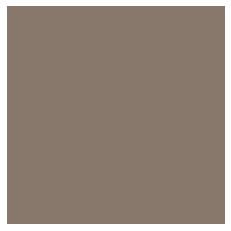

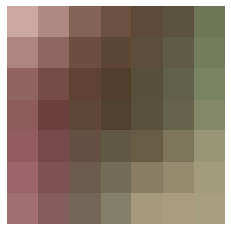

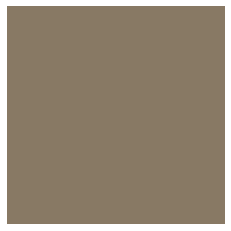

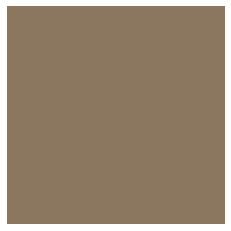

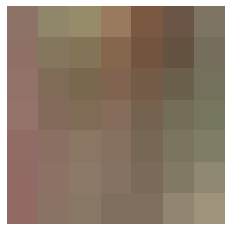

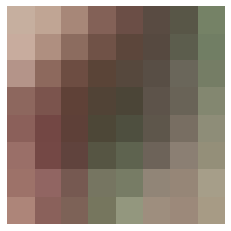

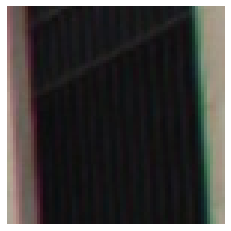

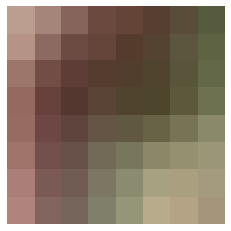

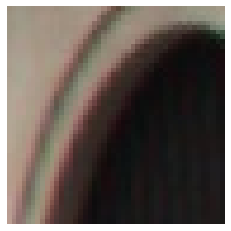

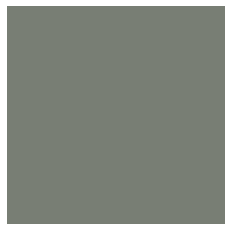

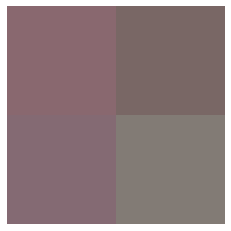

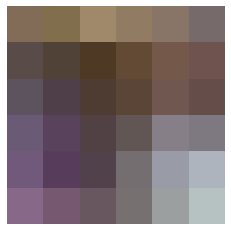

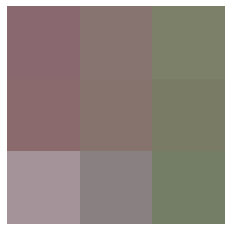

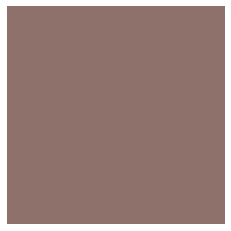

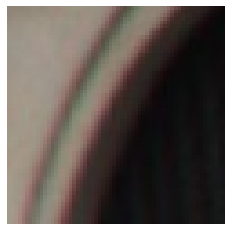

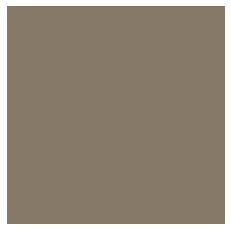

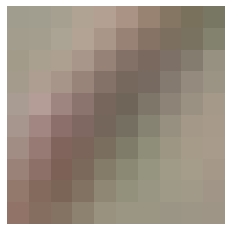

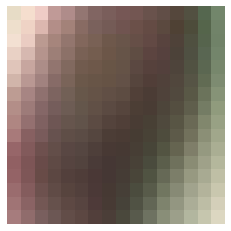

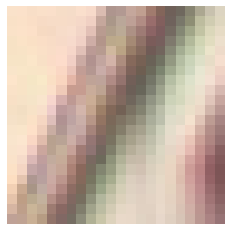

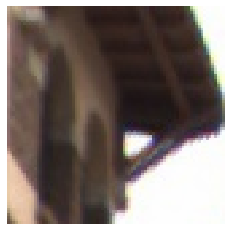

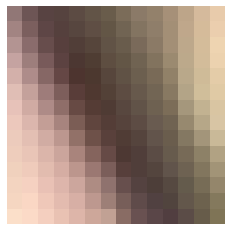

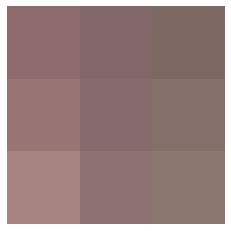

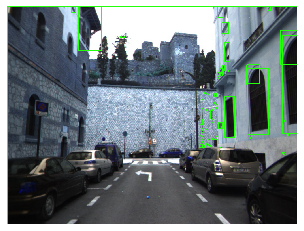

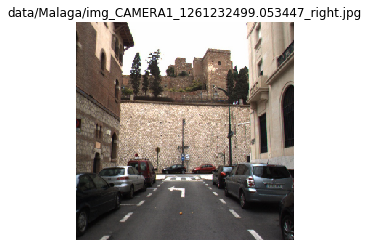

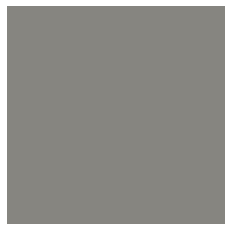

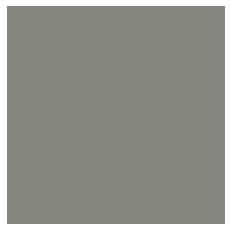

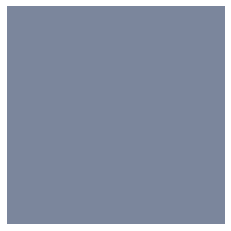

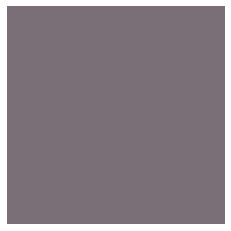

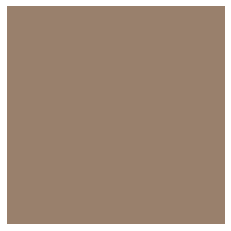

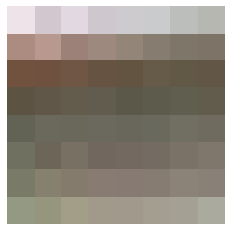

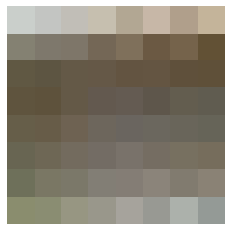

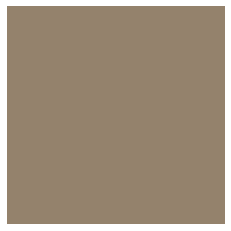

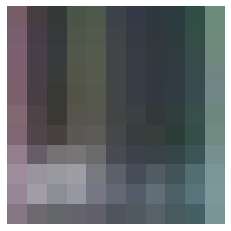

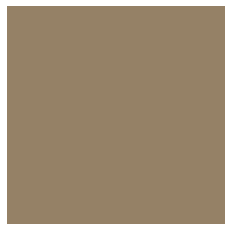

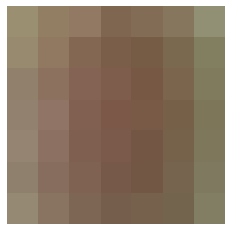

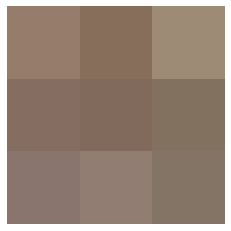

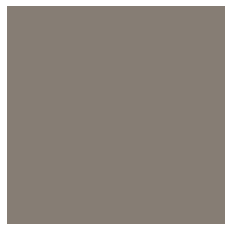

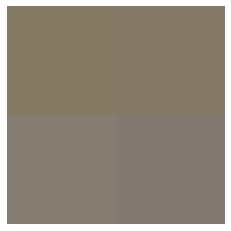

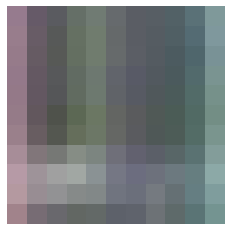

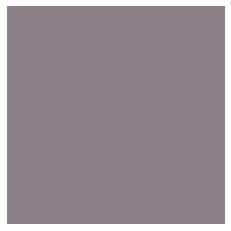

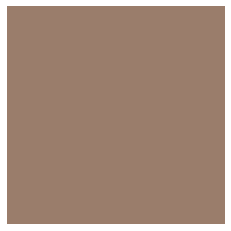

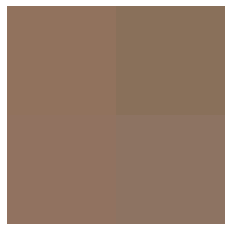

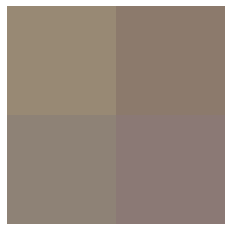

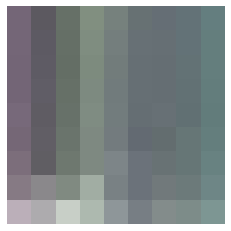

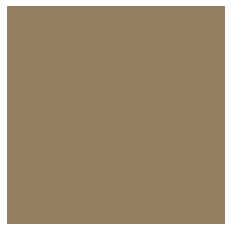

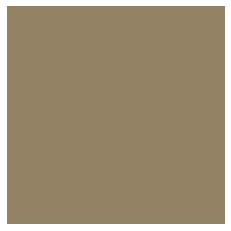

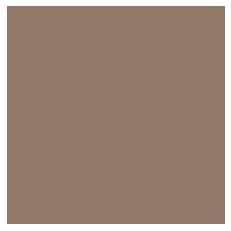

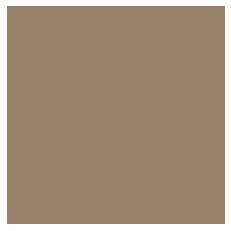

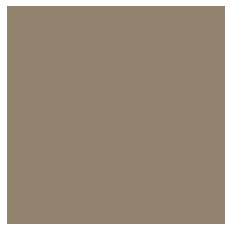

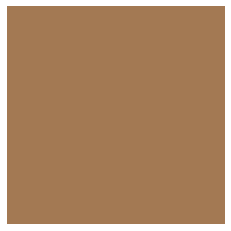

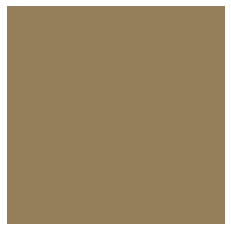

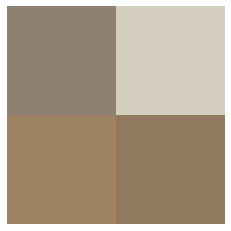

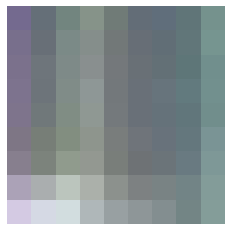

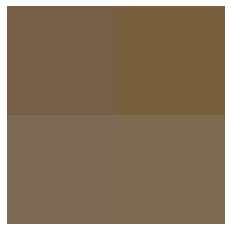

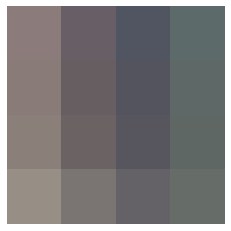

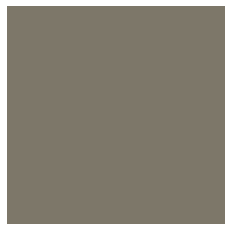

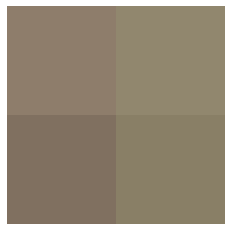

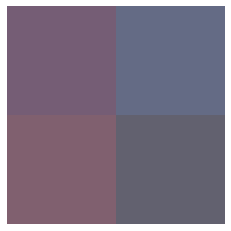

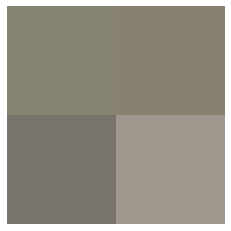

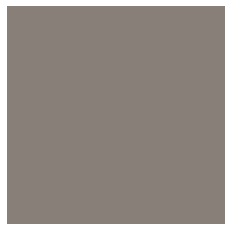

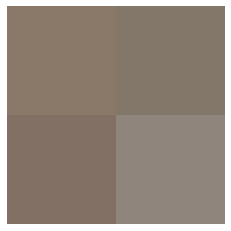

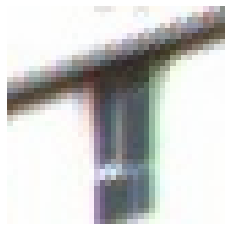

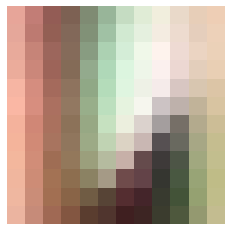

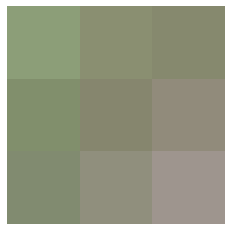

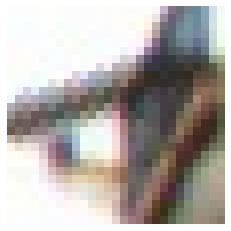

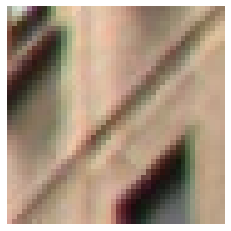

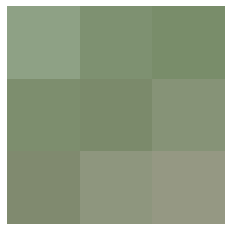

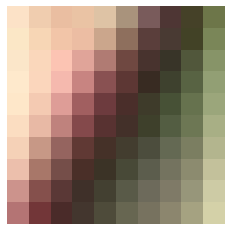

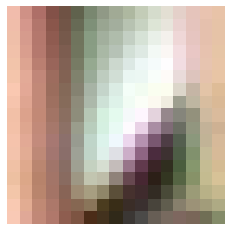

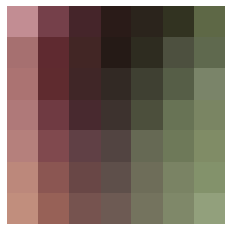

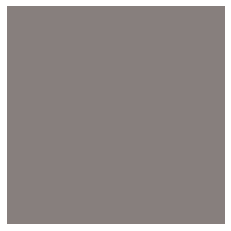

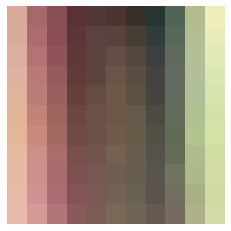

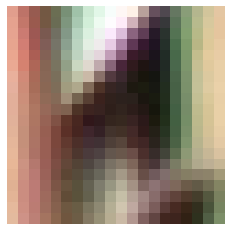

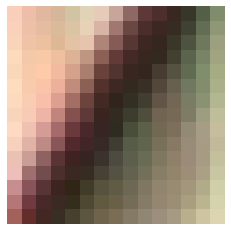

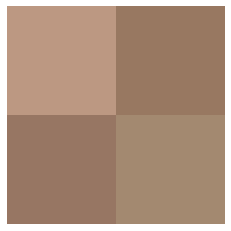

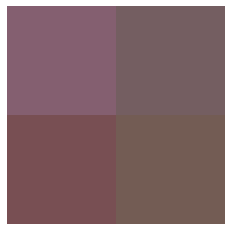

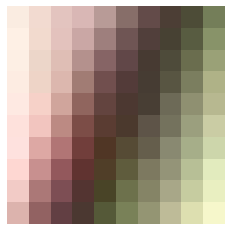

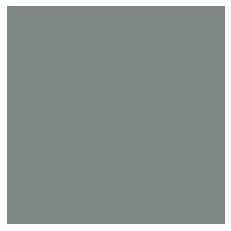

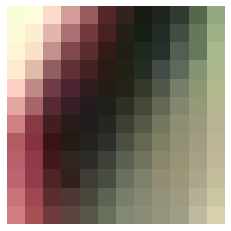

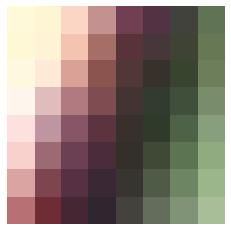

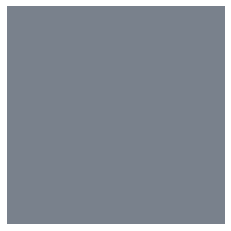

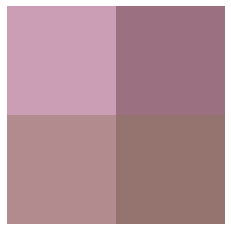

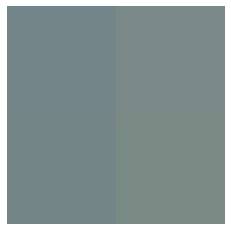

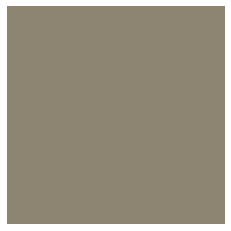

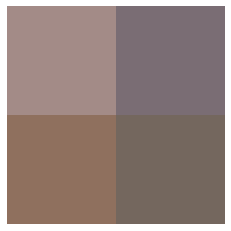

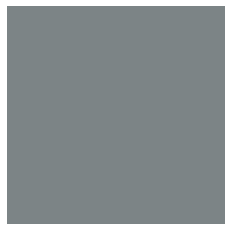

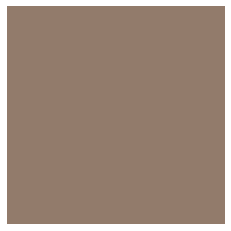

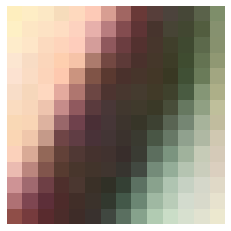

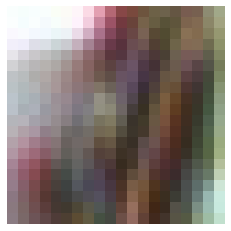

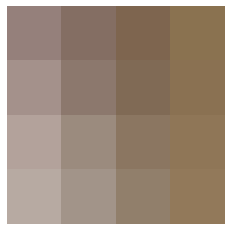

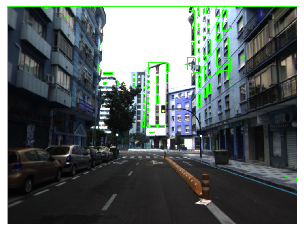

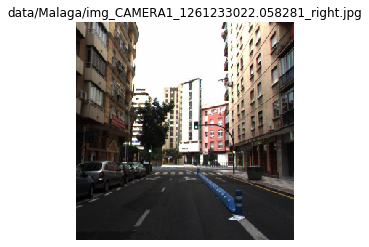

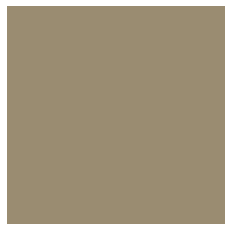

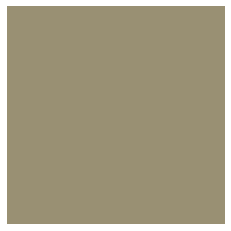

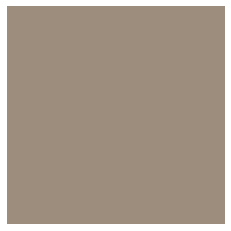

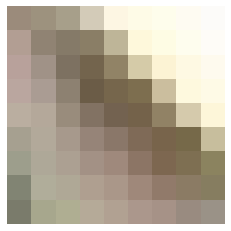

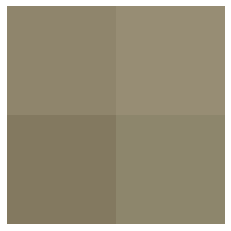

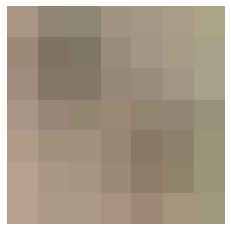

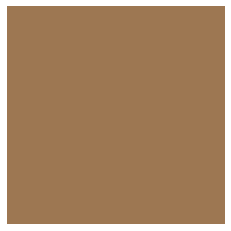

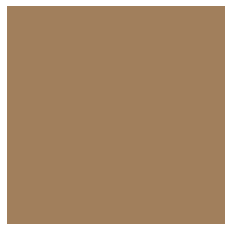

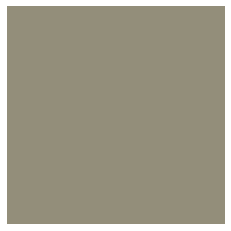

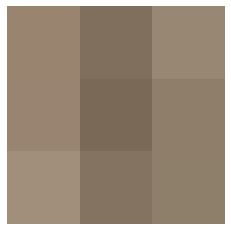

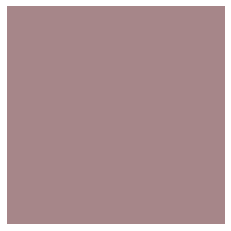

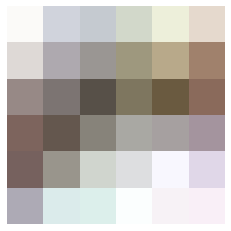

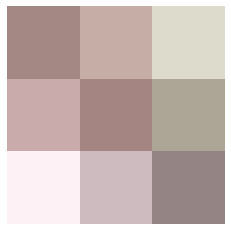

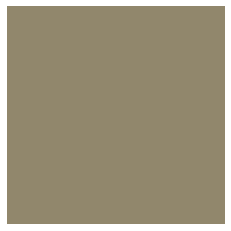

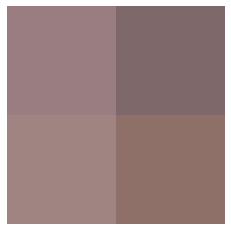

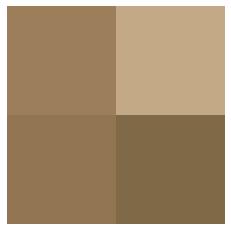

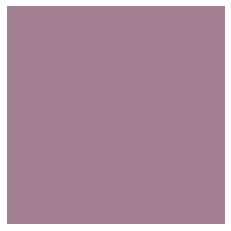

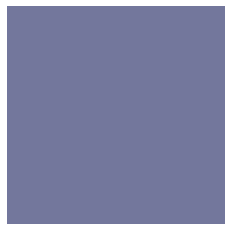

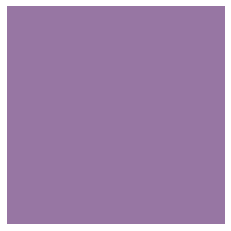

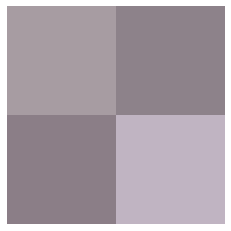

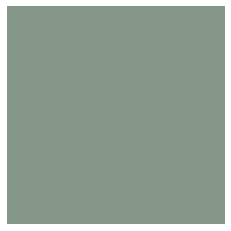

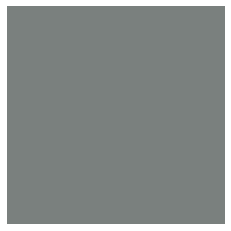

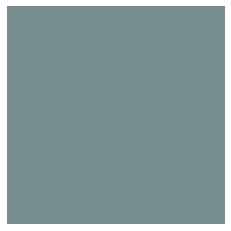

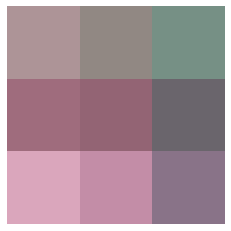

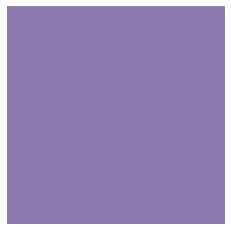

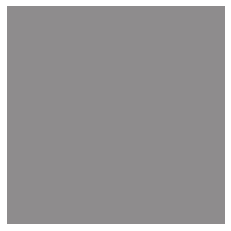

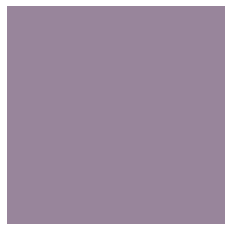

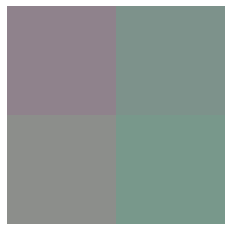

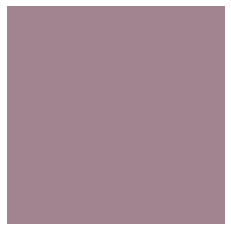

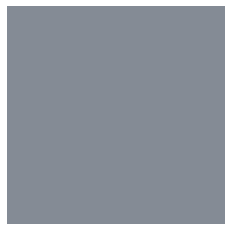

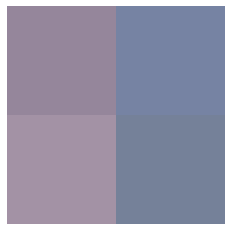

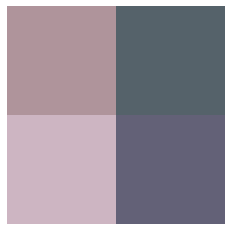

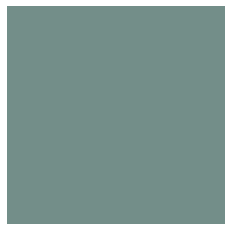

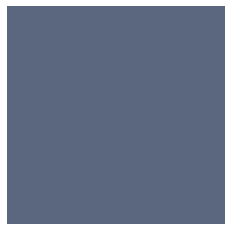

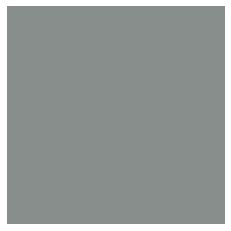

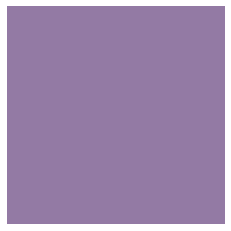

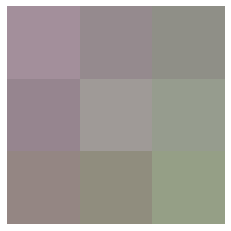

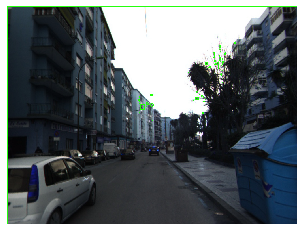

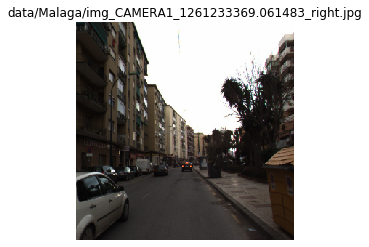

In [15]:
# Use Malaga and OpenStreet
test_sets = ['OpenStreet', 'Malaga']

for dataset in test_sets:
    print(f"Detecting objects in {dataset}")
    for img in os.listdir(f'data/{dataset}'):
        # Show image
        image_path = f"data/{dataset}/{img}"

        #### Object Detection -> Infer
        detect_objects(cv2.imread(image_path), best_model)
        
        #### Infer
        infer_img = preprocess_image(image_path)
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.title(image_path)
        plt.imshow(infer_img)

        infer(infer_img)